# [Maureen] Inftrain ABX Analysis

## Includes bilingual data

In [1]:
import json
import os
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from glob import glob
import warnings
import seaborn as sns

#better and bigger plots inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 250 # 200 e.g. is really fine, but slower

sns.set_theme()

HOME="/linkhome/rech/genini01/ucv88ce/"
models_path=os.path.join(HOME,"projects/MultilingualCPC/experiments/checkpoints/inftrain" )
eval_path='/linkhome/rech/genini01/ucv88ce/projects/MultilingualCPC/experiments/eval/inftrain'

* Functions definition

In [2]:
def retrieve_scores_kmeans( size= [50,100, 200, 400, 800, 1600, 3200], abx_type="both", easyfilter = False, models_path='/linkhome/rech/genini01/ucv88ce/projects/MultilingualCPC/experiments/checkpoints/inftrain'):
    fam_dict={}

    #columns = fam_id 	size 	eval_lang 	en_model 	fr_model 	bil_totalsize_A 	bil_totalsize_B 	same 	different 	bil_langsize 	bil_totalsize 	mono_avg (same and diff are just the scores from tje model corresponding to th train and eval)
    #do average of within and across
    langs=["EN","FR","EN+FR"]

    for s in sorted(size):
        s=int(s)
        for fam in ["{}".format(str(x).zfill(2)) for x in range(int(32/s*100))] :

            for eval_lang in ['en','fr']:
                k = fam+"_"+eval_lang+"_"+str(s)

                values = [fam, int(s), eval_lang]

                for model in langs:
                    
                    if model == "EN" or model == "FR" :
                        
                        path = os.path.join(models_path,model,str(s)+"h",fam,"kmeans50/ABX","**",eval_lang, "ABX_scores.json")
                        json_f = glob(path, recursive=True)
                        if easyfilter : 
                            json_f = [x for x in json_f if "1s_easyfilter" in x and "/0/" not in x]
                        else:
                            json_f = [x for x in json_f if "1s_easyfilter" not in x and "/0/" not in x] #remove easyfilter
                        
                        if len(json_f) > 1:
                            json_f = [max(json_f, key=os.path.getctime)]

                        if not json_f :
                            score = np.nan
                        else:
                            with open(json_f[0], "r") as f:

                                scores = json.load(f)
                            if abx_type == "both" :
                                score = np.mean([scores['within'],scores['across']]) * 100
                            else :
                                score = scores[abx_type]*100
                        values.append(score)

                    elif model == "EN+FR" :
                        bil_scores = []
                        for bil_fam in [str(int(fam)*2).zfill(2), str((int(fam)*2) + 1).zfill(2)] :
                            path = os.path.join(models_path,model,str(s)+"h",bil_fam,"kmeans100/ABX_CV","**", "last",eval_lang, "ABX_scores.json")
                            json_f = glob(path, recursive=True)
                            
                            
                            if easyfilter : 
                                json_f = [x for x in json_f if "1s_easyfilter" in x and "/0/" not in x]
                            else:
                                json_f = [x for x in json_f if "1s_easyfilter" not in x and "/0/" not in x] #remove easyfilter
                                                        
                            if len(json_f) > 1:
                                
                                json_f = [max(json_f, key=os.path.getctime)]

                            if not json_f :
                                score = np.nan
                            else:
                                with open(json_f[0], "r") as f:
                                    scores = json.load(f)
                                if abx_type == "both" :
                                    score = np.mean([scores['within'],scores['across']]) * 100
                                else :
                                    score = scores[abx_type]*100 
                                    
                            values.append(score)
                            
                            #below add langsize
                            if fam+"_"+eval_lang+"_"+str(int(s/2)) in fam_dict :
                                fam_dict[bil_fam+"_"+eval_lang+"_"+str(int(s/2))][-1] = score


                        
                    if model == "EN" and eval_lang == "en" :
                        same = score
                    elif model == "EN" and eval_lang == "fr" :
                        different = score
                    elif model == "FR" and eval_lang == "fr" :
                        same = score
                    elif model == "FR" and eval_lang == "en" :
                        different = score

                values.append(same)
                values.append(different)
                values.append(np.nan) #eate space for the "bil_add"
                fam_dict[k] = values
                


    

    df = pd.DataFrame.from_dict(fam_dict, orient='index', columns=["fam_id", "size", "eval_lang", "en_model", "fr_model", "bil_totalsize_A", "bil_totalsize_B", 'same', 'different', "bil_langsize"])
    df['bil_totalsize'] = df[["bil_totalsize_A", "bil_totalsize_B"]].mean(axis=1)
    df["mono_avg"] = df[["en_model", "fr_model"]].mean(axis=1)
    return df

## Retrieve ABX scores & datasets

*MDS - Todo : add lambda function to systematically retrieve latest checkpoint ABX score*

1. df_within : original ABX scores calculated "within speaker"
2. df_across : original ABX scores calculated "across speakers"
3. df_ef_within : "easyfilter" ABX scores calculated "within speaker"
4. df_ef_across : "easyfilter" ABX scores calculated "across speakers"


The "easyfilter" abx scores correspond, for the french scores, to the scores calculated on the "quickfix" item files (see [Google Document](https://docs.google.com/document/d/1XoGX52rBFOwue2twX02IuEhO_-ZktSZh-qdvpuBqK3I/edit?usp=sharing)). The english scores are the same as the original ones. 

In [3]:
abx_type="both"
abx_type="within"


df_within = retrieve_scores_kmeans(abx_type="within")
df_within_size = df_within.groupby(by="size").mean()

df_across = retrieve_scores_kmeans(abx_type="across")
df_across_size = df_across.groupby(by="size").mean()

err_within=df_within.groupby('size').std()
err_across=df_across.groupby('size').std()

In [4]:
df_within

fam_id  size eval_lang   en_model   fr_model  bil_totalsize_A  \
00_en_50       00    50        en  26.706165  33.413154              NaN   
00_fr_50       00    50        fr  28.705347  31.028271              NaN   
01_en_50       01    50        en  29.006475  30.956197              NaN   
01_fr_50       01    50        fr  29.505792  29.051667              NaN   
02_en_50       02    50        en  32.203782  36.249718              NaN   
...           ...   ...       ...        ...        ...              ...   
00_fr_1600     00  1600        fr  21.550433  21.196027        24.494852   
01_en_1600     01  1600        en  18.040411  25.178596        22.536373   
01_fr_1600     01  1600        fr  21.212339  21.552339        29.941341   
00_en_3200     00  3200        en  17.194891  24.387354        20.617759   
00_fr_3200     00  3200        fr  20.271827  19.535062        20.300849   

            bil_totalsize_B       same  different  bil_langsize  \
00_en_50                NaN  26.706165  33.413154     29.983041   
00_fr_50                NaN  31.028271  28.705347     31.971121   
01_en_50                NaN  29.006475  30.956197     30.782118   
01_fr_50                NaN  29.051667  29.505792     29.775536   
02_en_50                NaN  32.203782  36.249718     36.063457   
...                     ...        ...        ...           ...   
00_fr_1600        31.657091  21.196027  21.550433     20.300849   
01_en_1600        28.001484  18.040411  25.178596     20.530754   
01_fr_1600        26.963633  21.552339  21.212339     22.610906   
00_en_3200        20.530754  17.194891  24.387354           NaN   
00_fr_3200        22.610906  19.535062  20.271827           NaN   

            bil_totalsize   mono_avg  
00_en_50              NaN  30.059659  
00_fr_50              NaN  29.866809  
01_en_50              NaN  29.981336  
01_fr_50              NaN  29.278730  
02_en_50              NaN  34.226750  
...                   ...        ...  
00_fr_1600      28.075971  21.373230  
01_en_1600      25.268929  21.609504  
01_fr_1600      28.452487  21.382339  
00_en_3200      20.574257  20.791122  
00_fr_3200      21.455877  19.903444  

[254 rows x 12 columns]

# Figures

## A. Boxplots of ABX scores in function of training size for the different model types

### A1 - ABX across speakers - original
- Test set : average of French and English
- Df : Original

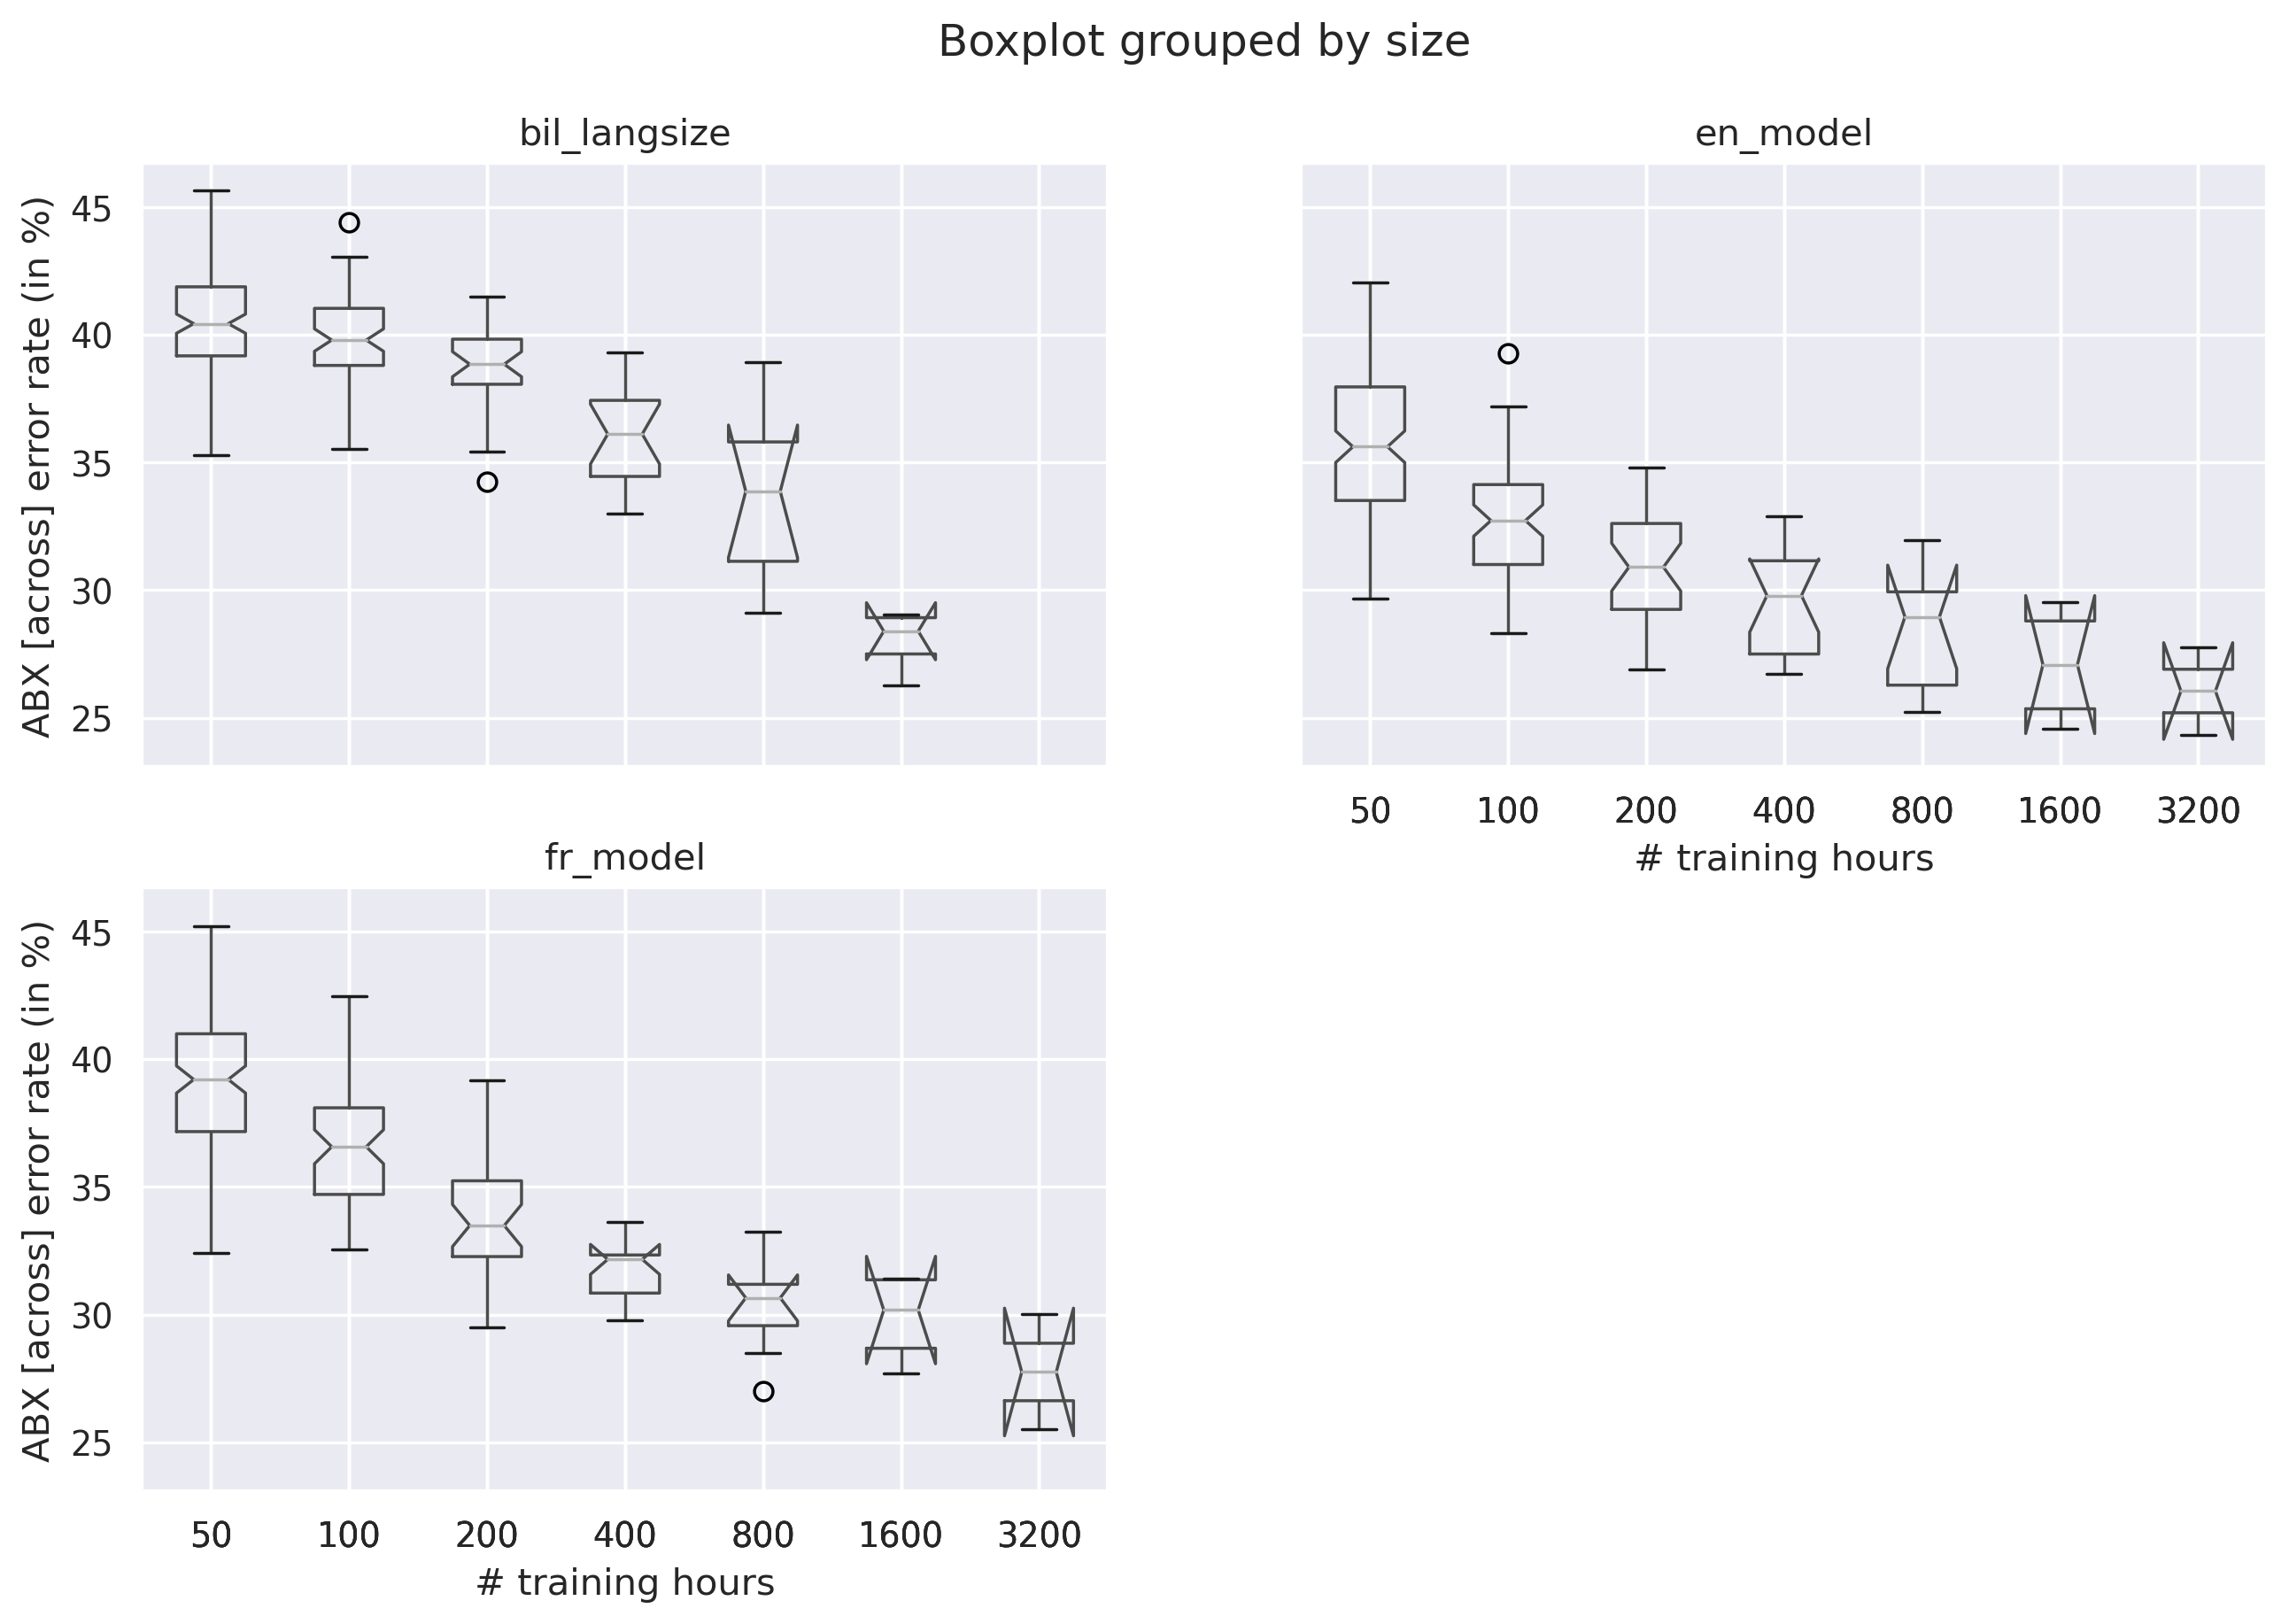

In [5]:
#boxplot = df_across[['size','en_model', 'fr_model',  'eval_lang']].boxplot(notch=True,by='size', return_type='axes')
boxplot = df_across[['size','en_model','bil_langsize', 'fr_model',  'eval_lang']].boxplot(notch=True,by='size', return_type='axes')

for bp in boxplot: 
    bp.set_ylabel('ABX [across] error rate (in %)')
    bp.set_xlabel('# training hours')


Text(0.5, 0, 'test set')

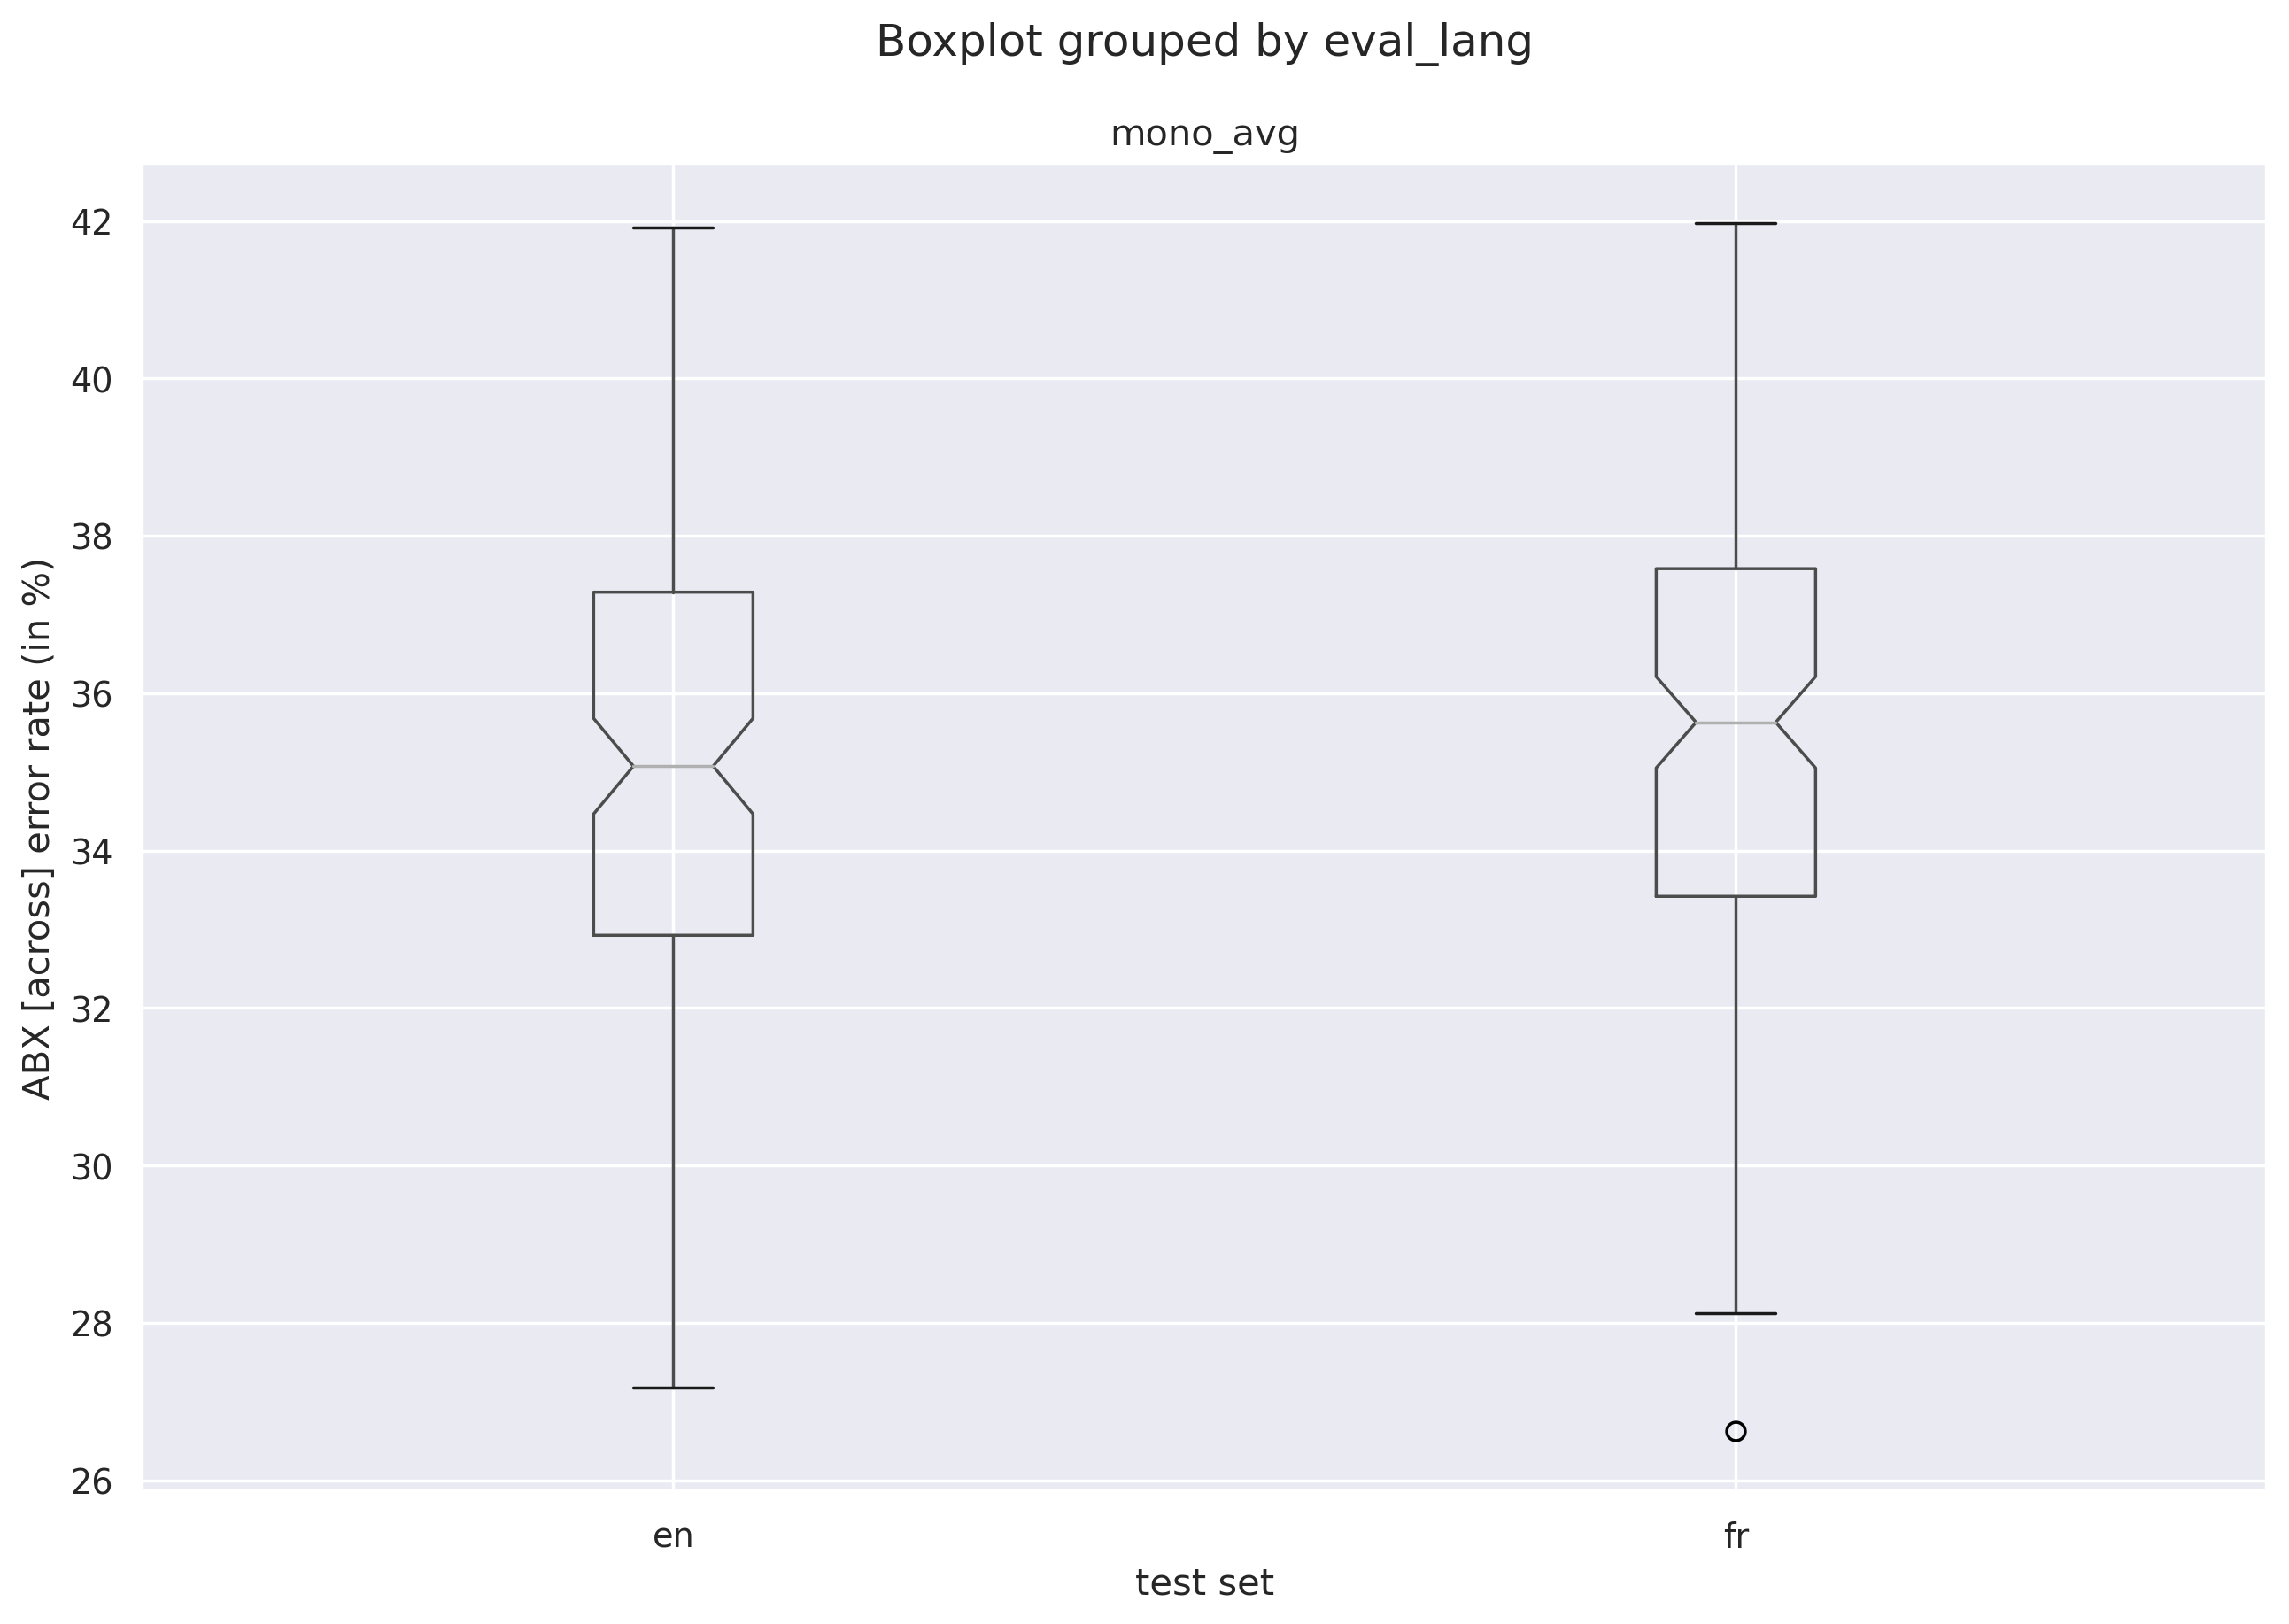

In [6]:
#boxplot = df_across[['size','en_model', 'fr_model',  'eval_lang']].boxplot(notch=True,by='size', return_type='axes')
boxplot = df_across[['mono_avg',  'eval_lang']].boxplot(by="eval_lang",notch=True, return_type='axes')

plt.ylabel('ABX [across] error rate (in %)')
plt.xlabel('test set')


### A2 - ABX within speakers  - original
- Test set : average of French and English
- Df : Original

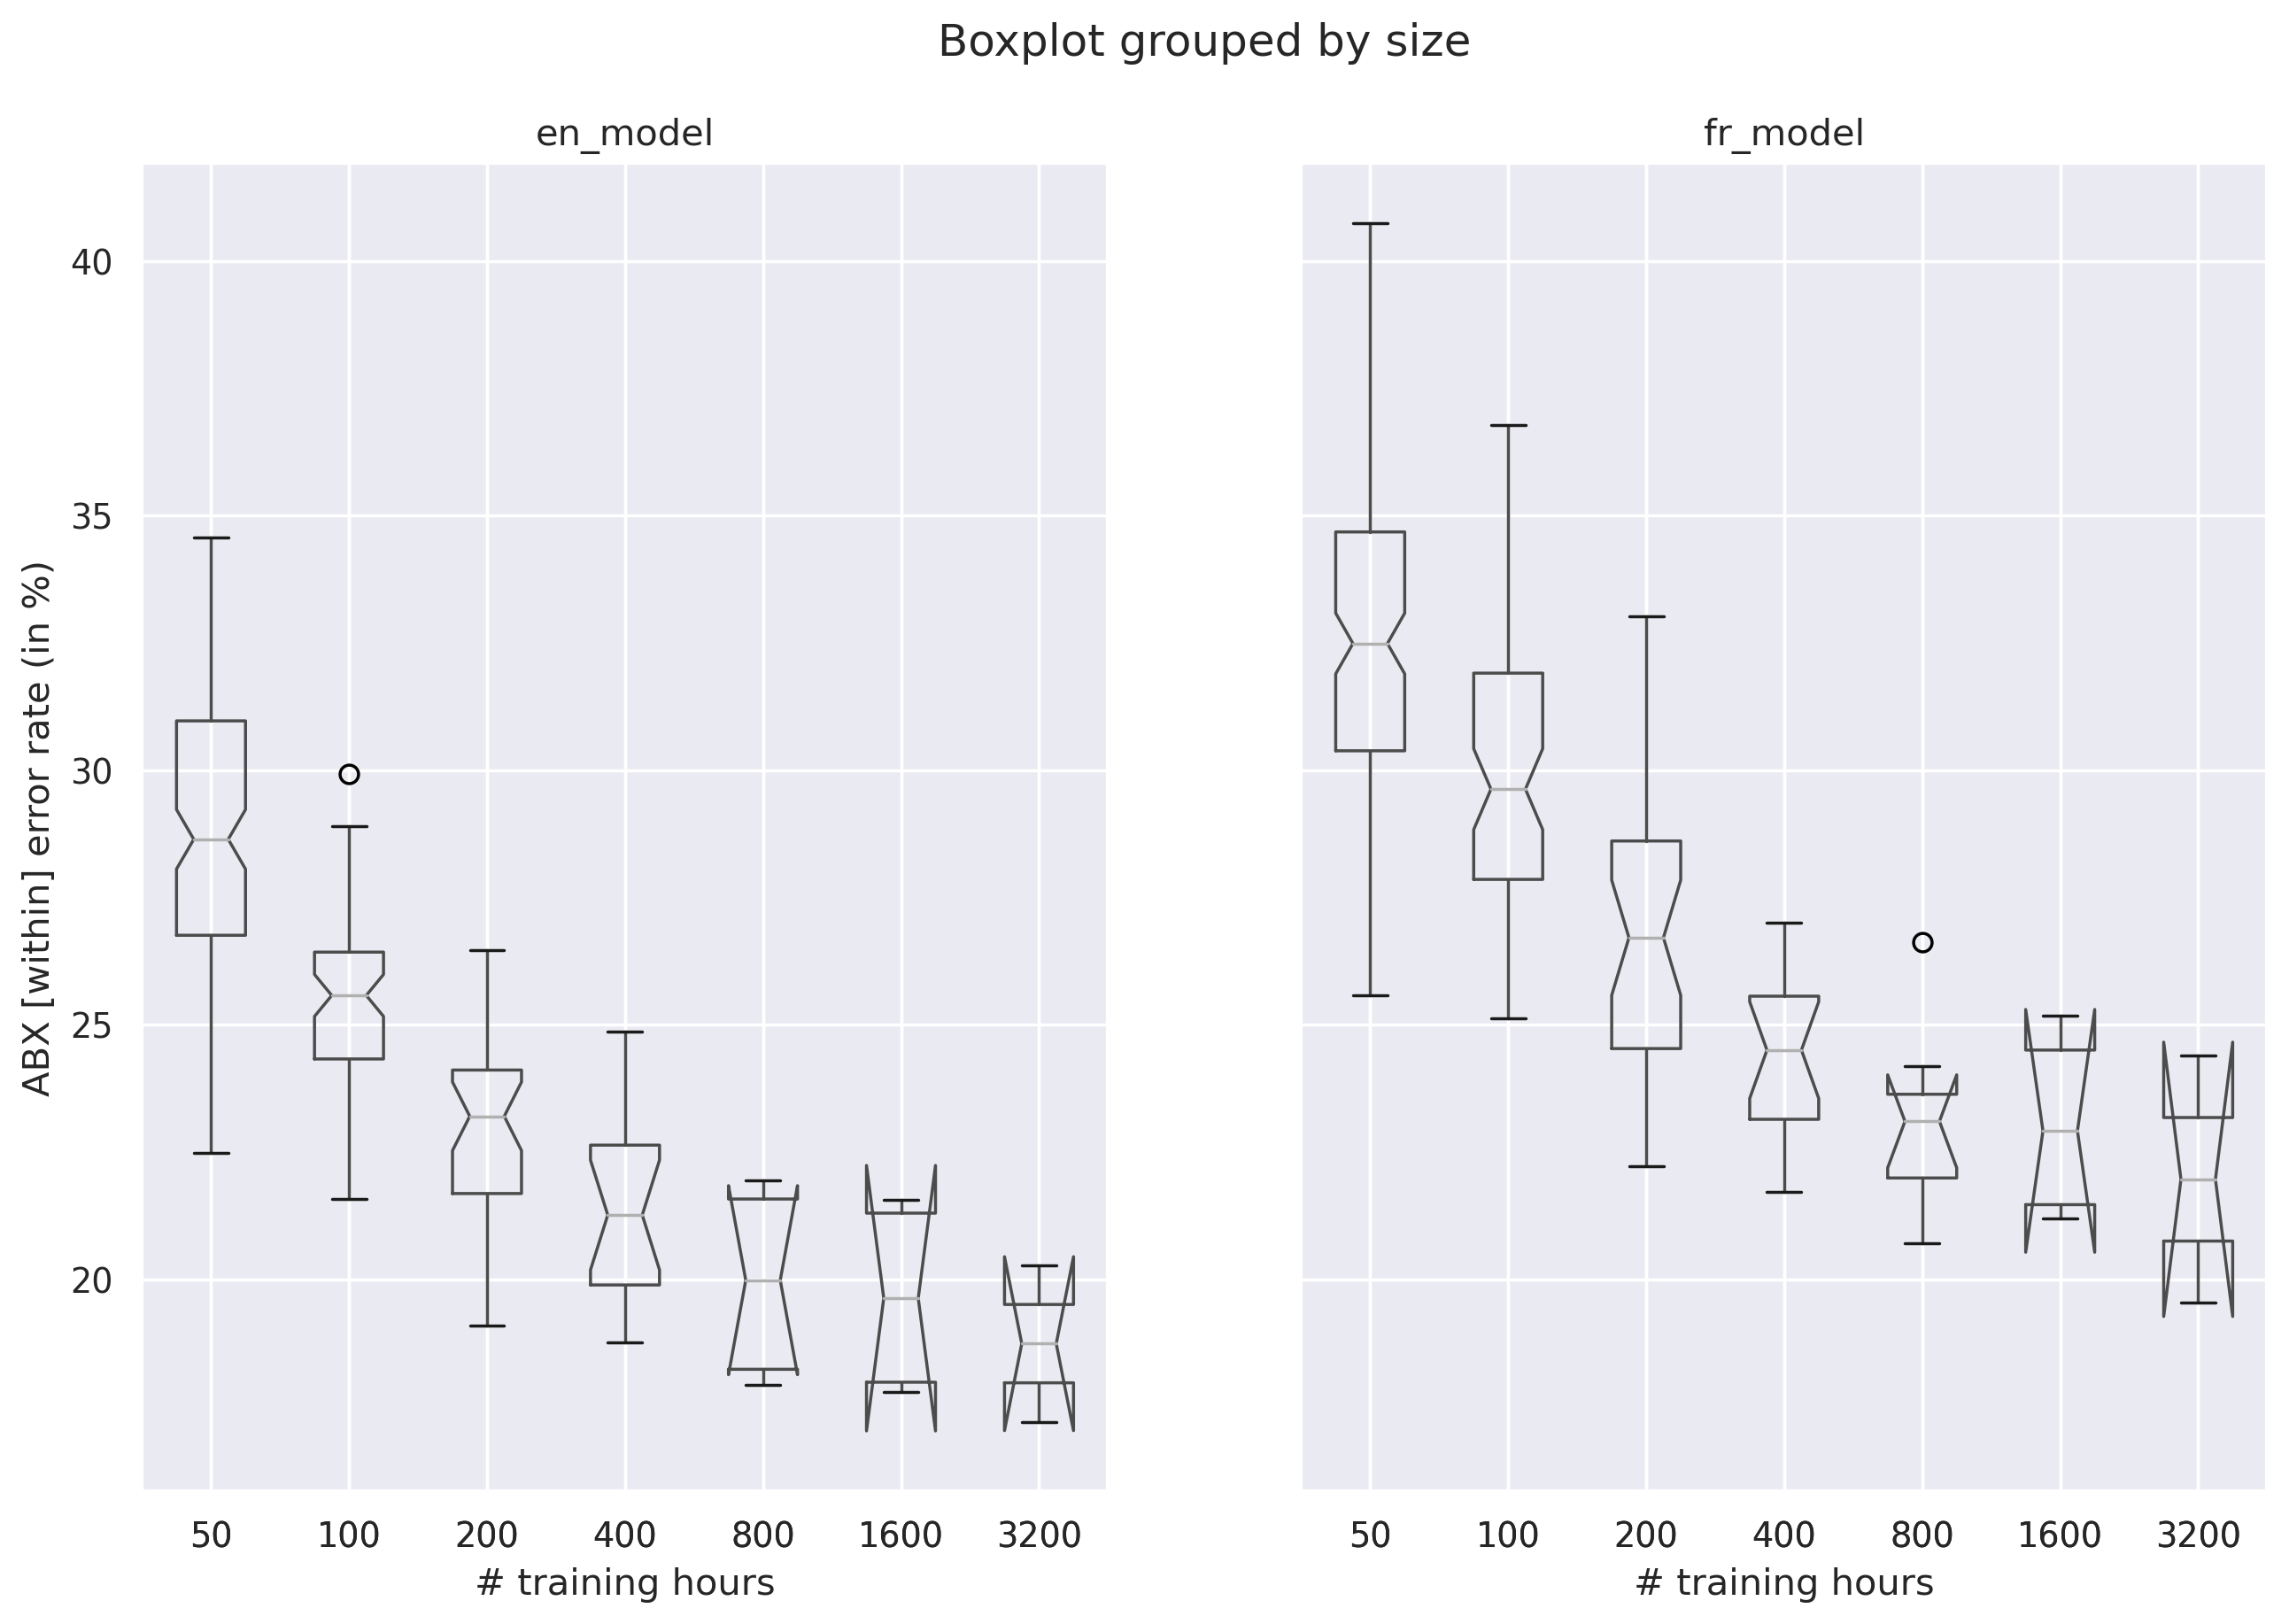

In [7]:
boxplot = df_within[['size','en_model', 'fr_model',  'eval_lang']].boxplot(notch=True,by='size', return_type='axes')
#boxplot = df_across[['size','en_model','bil_langsize', 'fr_model',  'eval_lang']].boxplot(notch=True,by='size', return_type='axes')

for bp in boxplot: 
    bp.set_ylabel('ABX [within] error rate (in %)')
    bp.set_xlabel('# training hours')


Text(0.5, 0, 'test set')

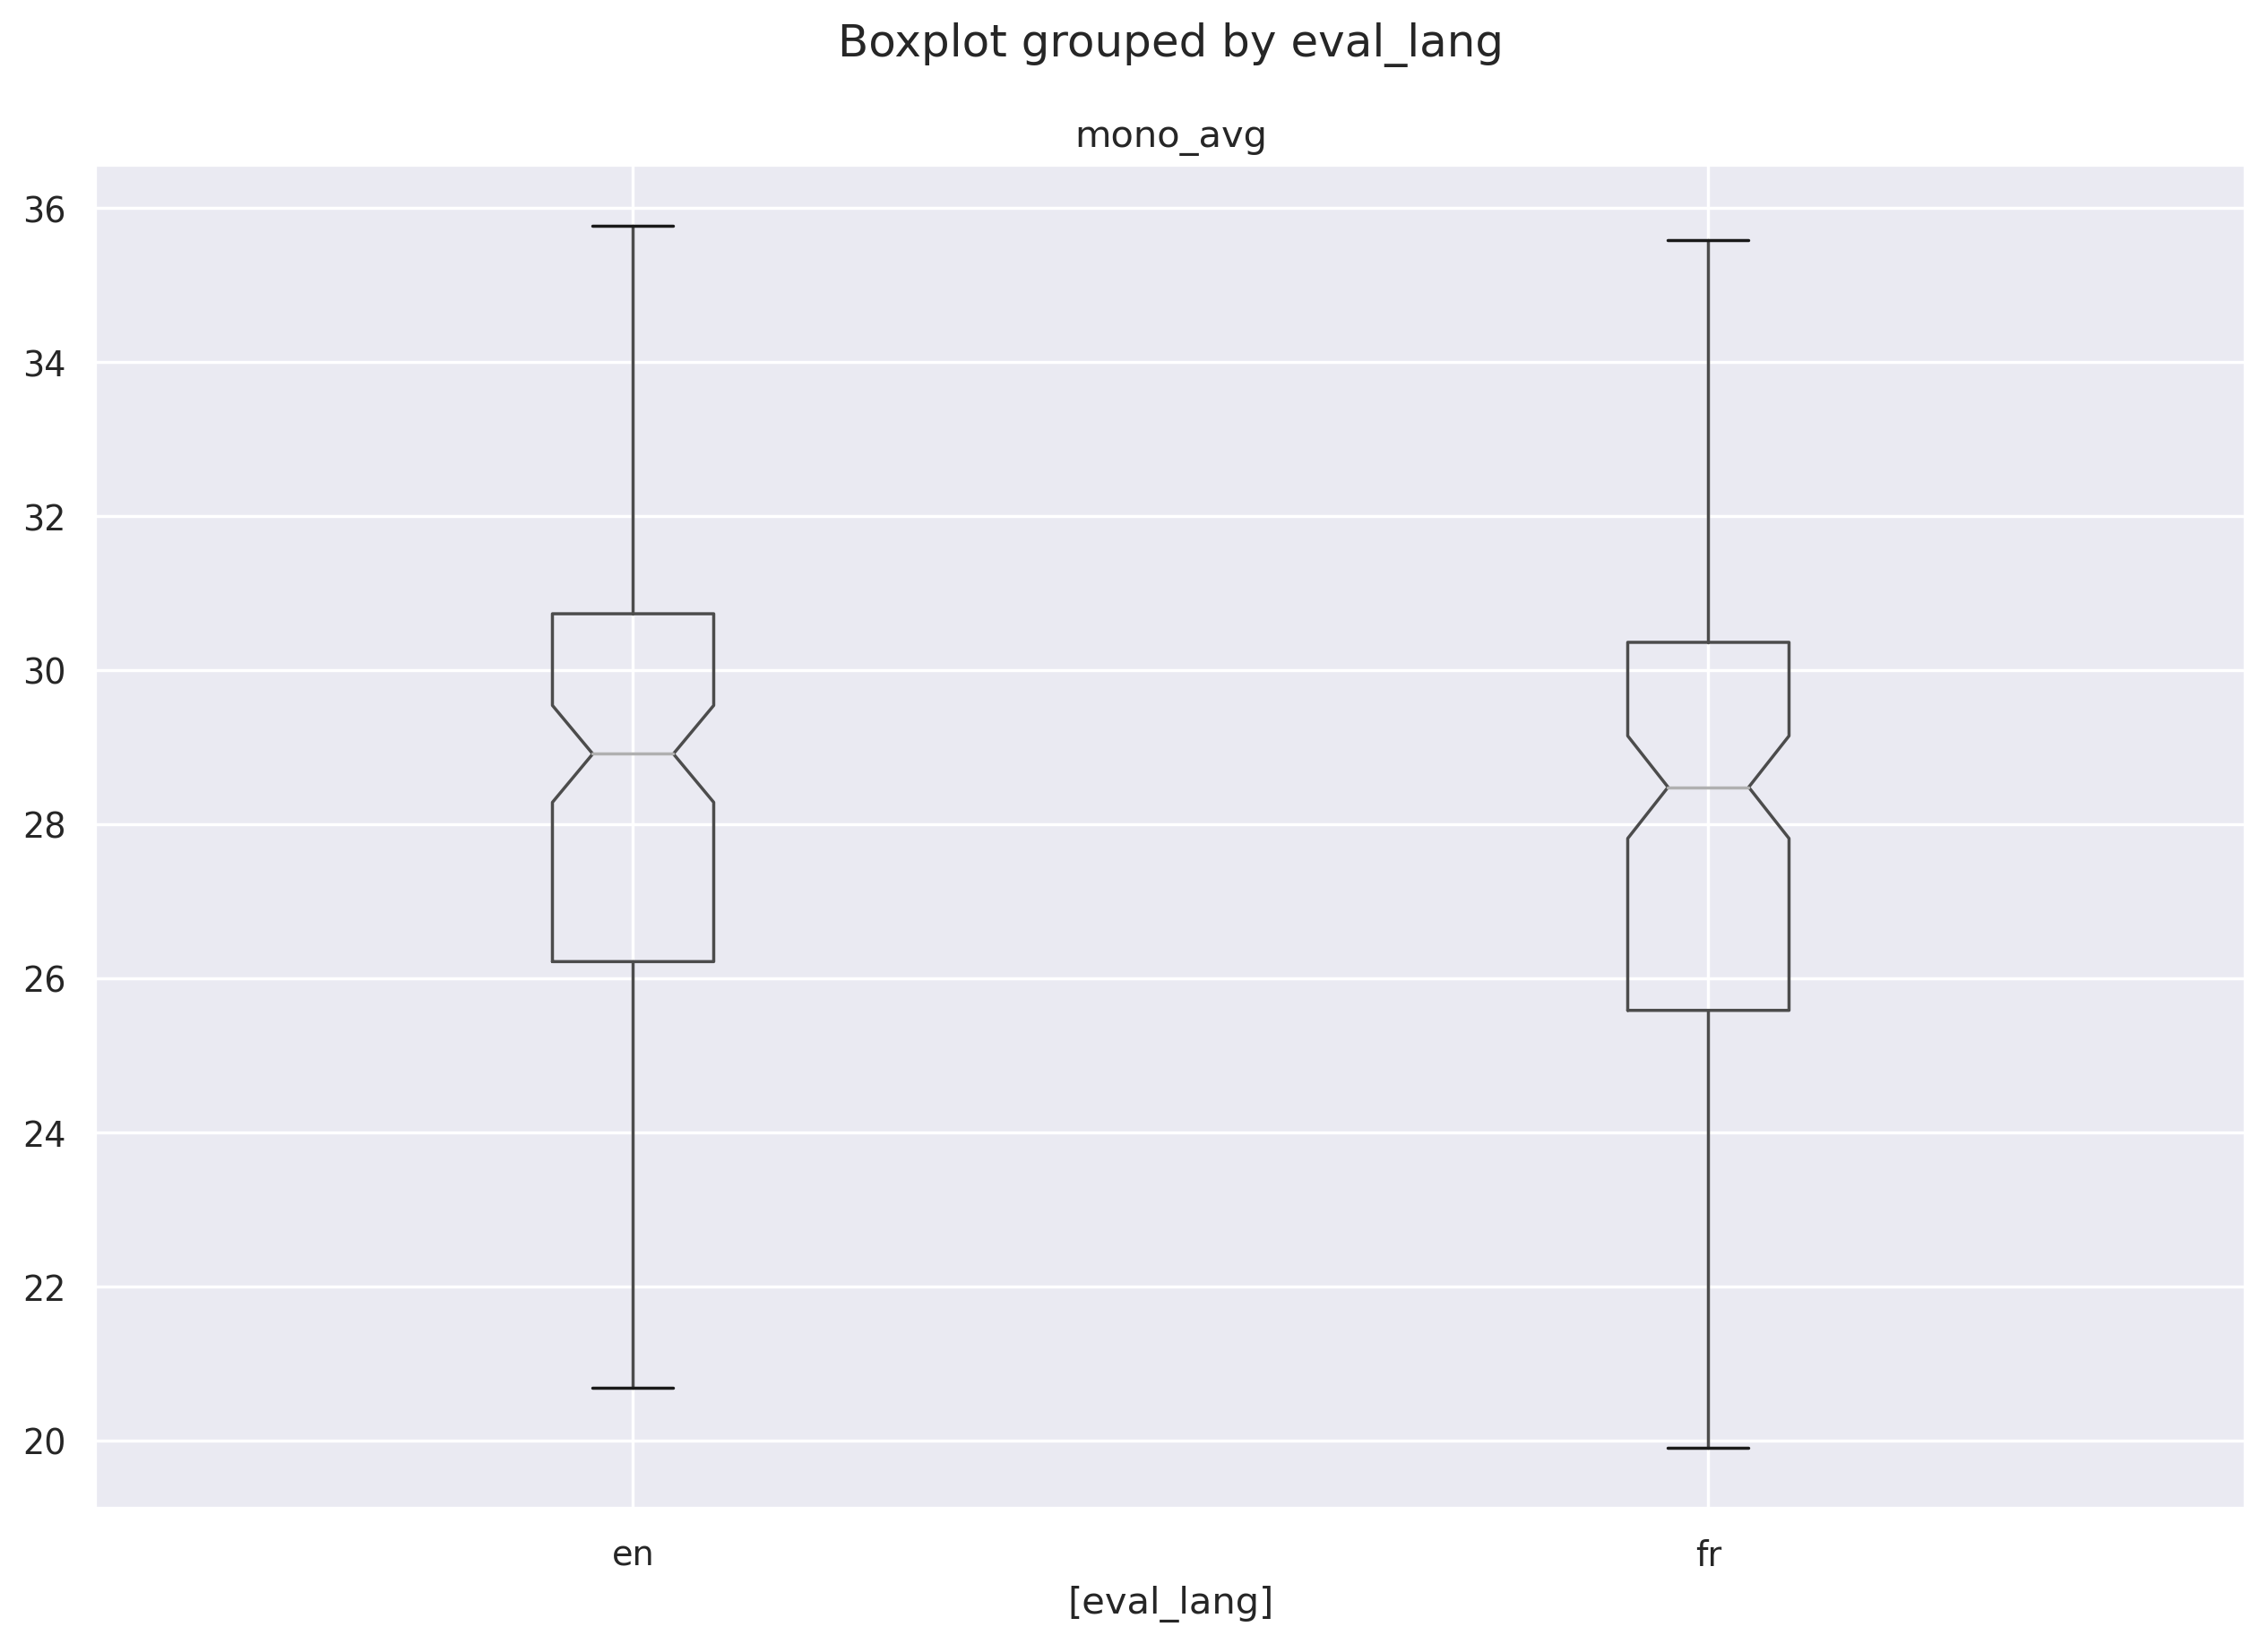

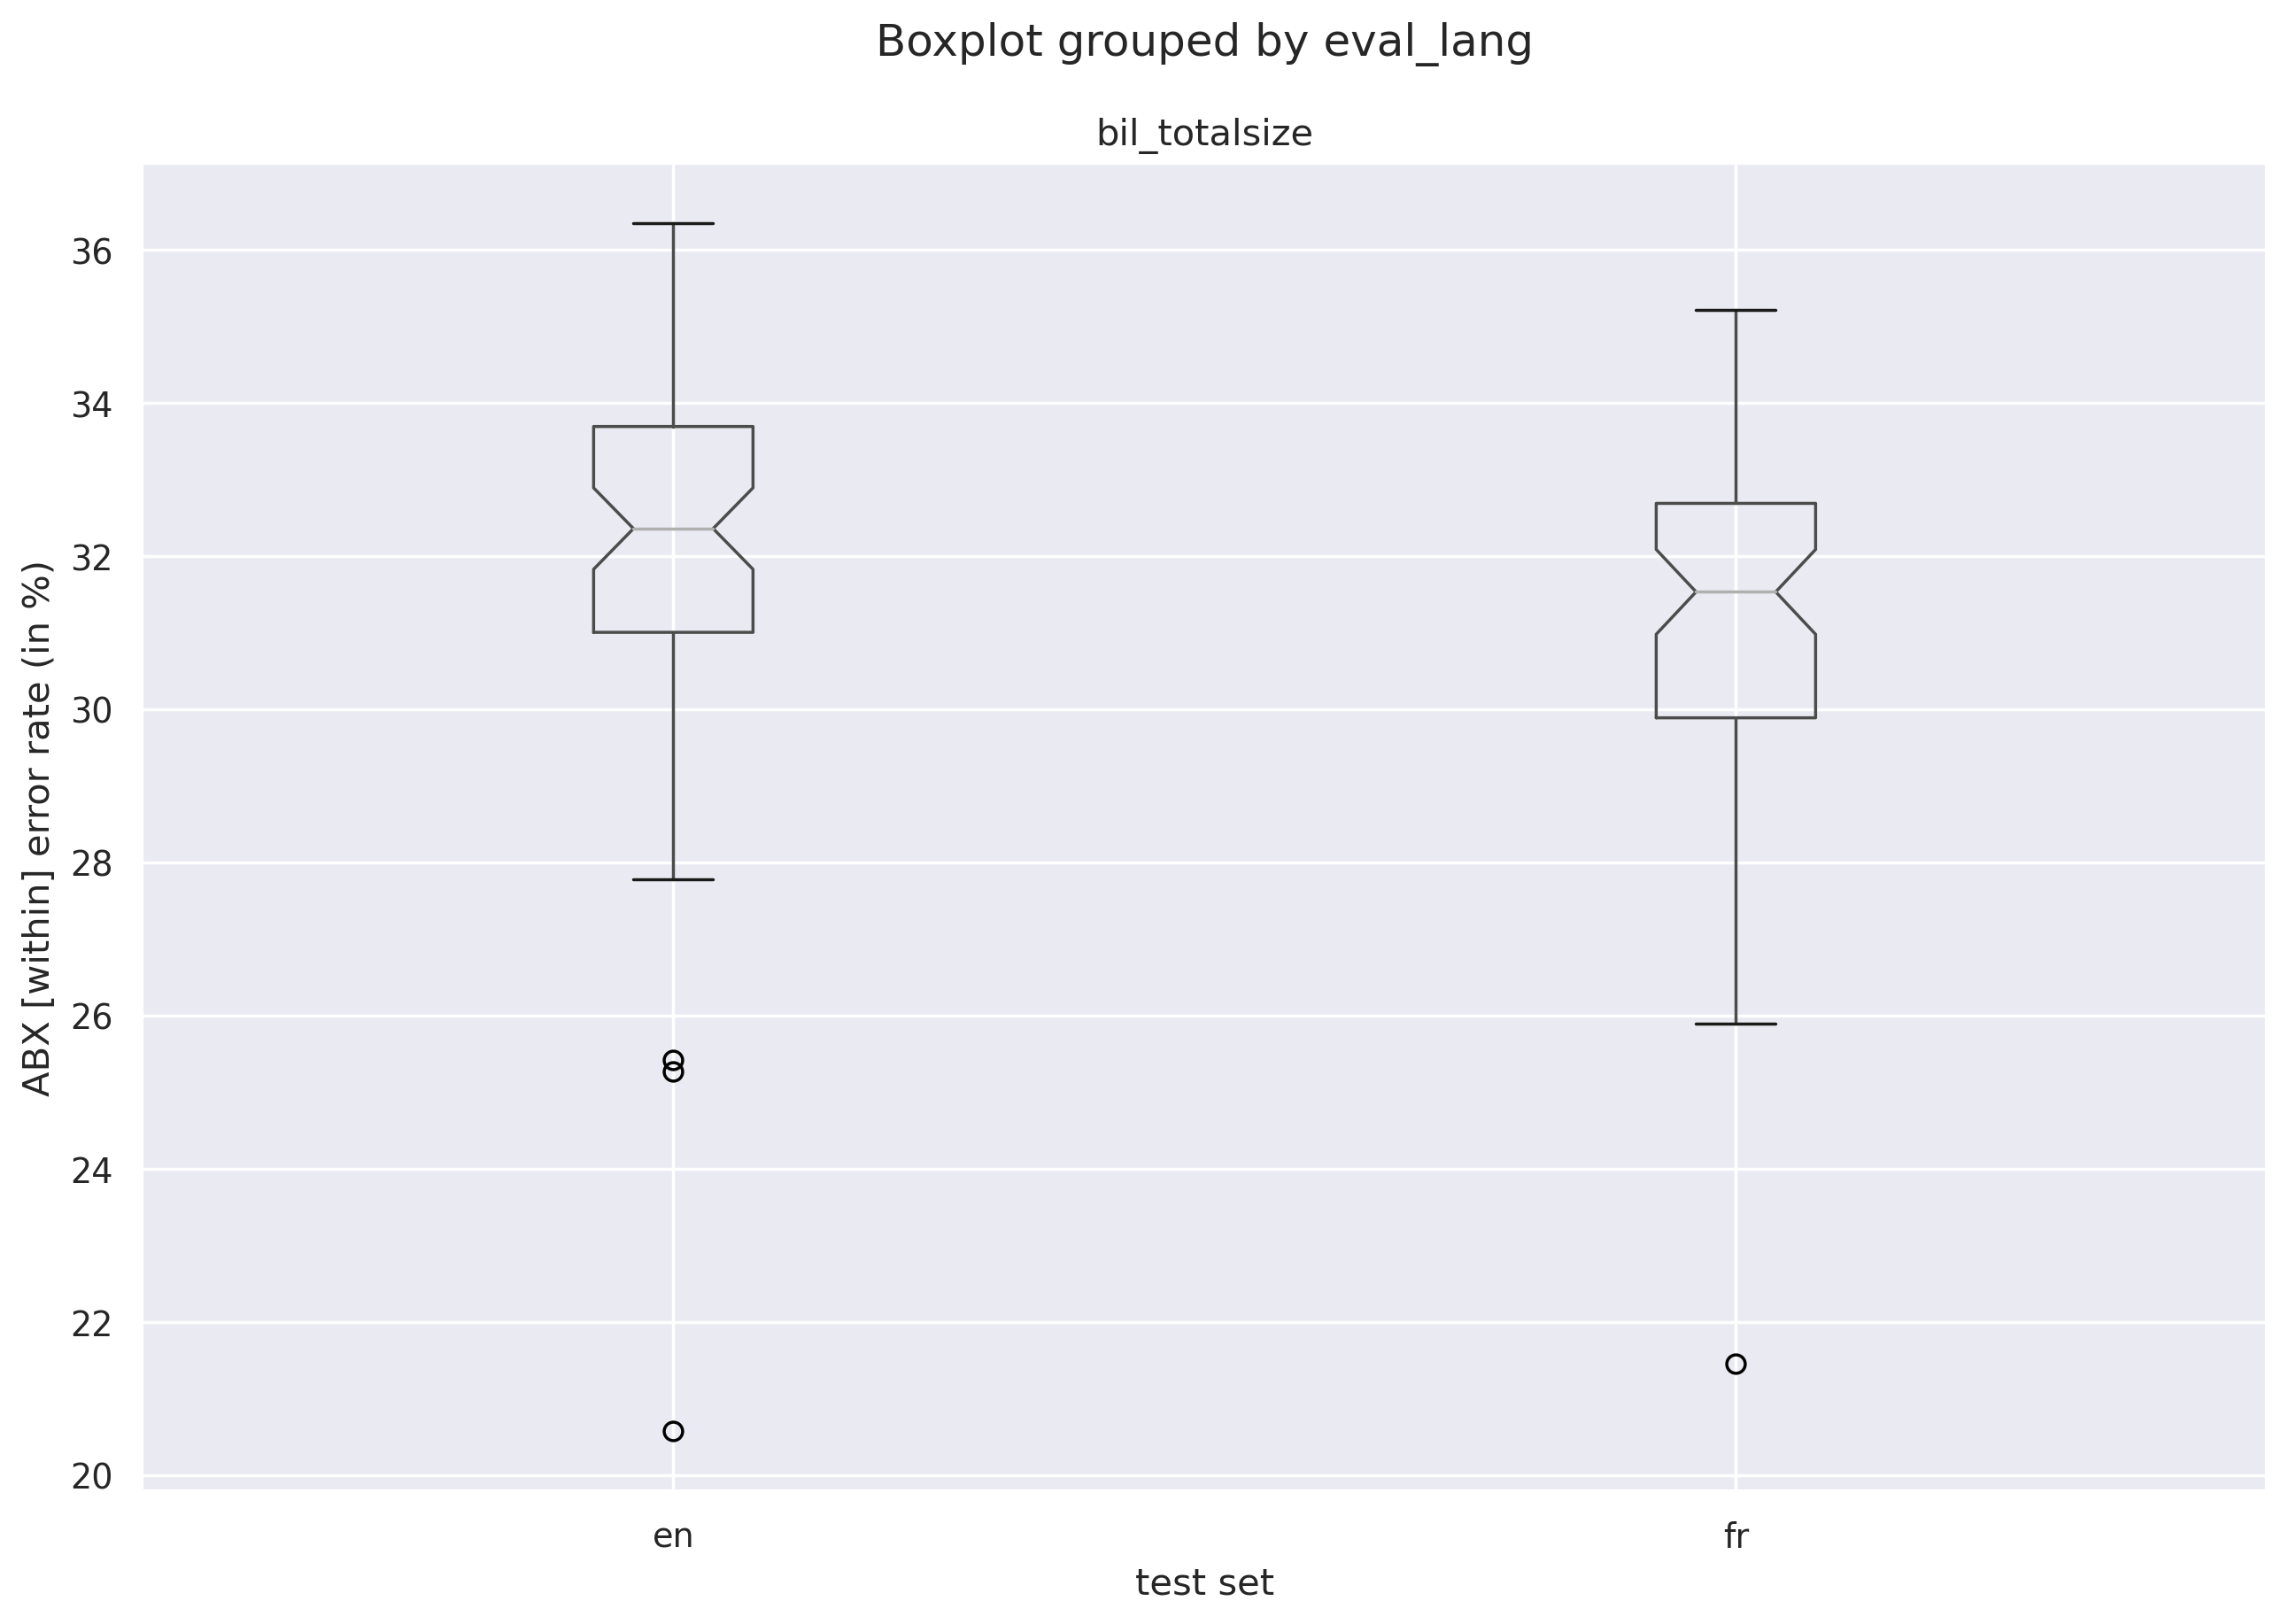

In [8]:
#boxplot = df_across[['size','en_model', 'fr_model',  'eval_lang']].boxplot(notch=True,by='size', return_type='axes')
boxplot = df_within[['mono_avg',  'eval_lang']].boxplot(by="eval_lang",notch=True, return_type='axes')

boxplot = df_within[['bil_totalsize',  'eval_lang']].boxplot(by="eval_lang",notch=True, return_type='axes')

plt.ylabel('ABX [within] error rate (in %)')
plt.xlabel('test set')


## C. Comparing Monolingual vs Bilingual ABX scores 



### C1. French vs English vs Bilingual TotalSize (original)
- ABX : within
- Test set : average English + French
These scores are not calculated on the 50h dataset to ensure reliable comparison

Text(0.5, 1.0, 'ABX [within] error rate calculated on the English and French evaluation sets, using the models trained of 100h, 200h, 400h and 800h')

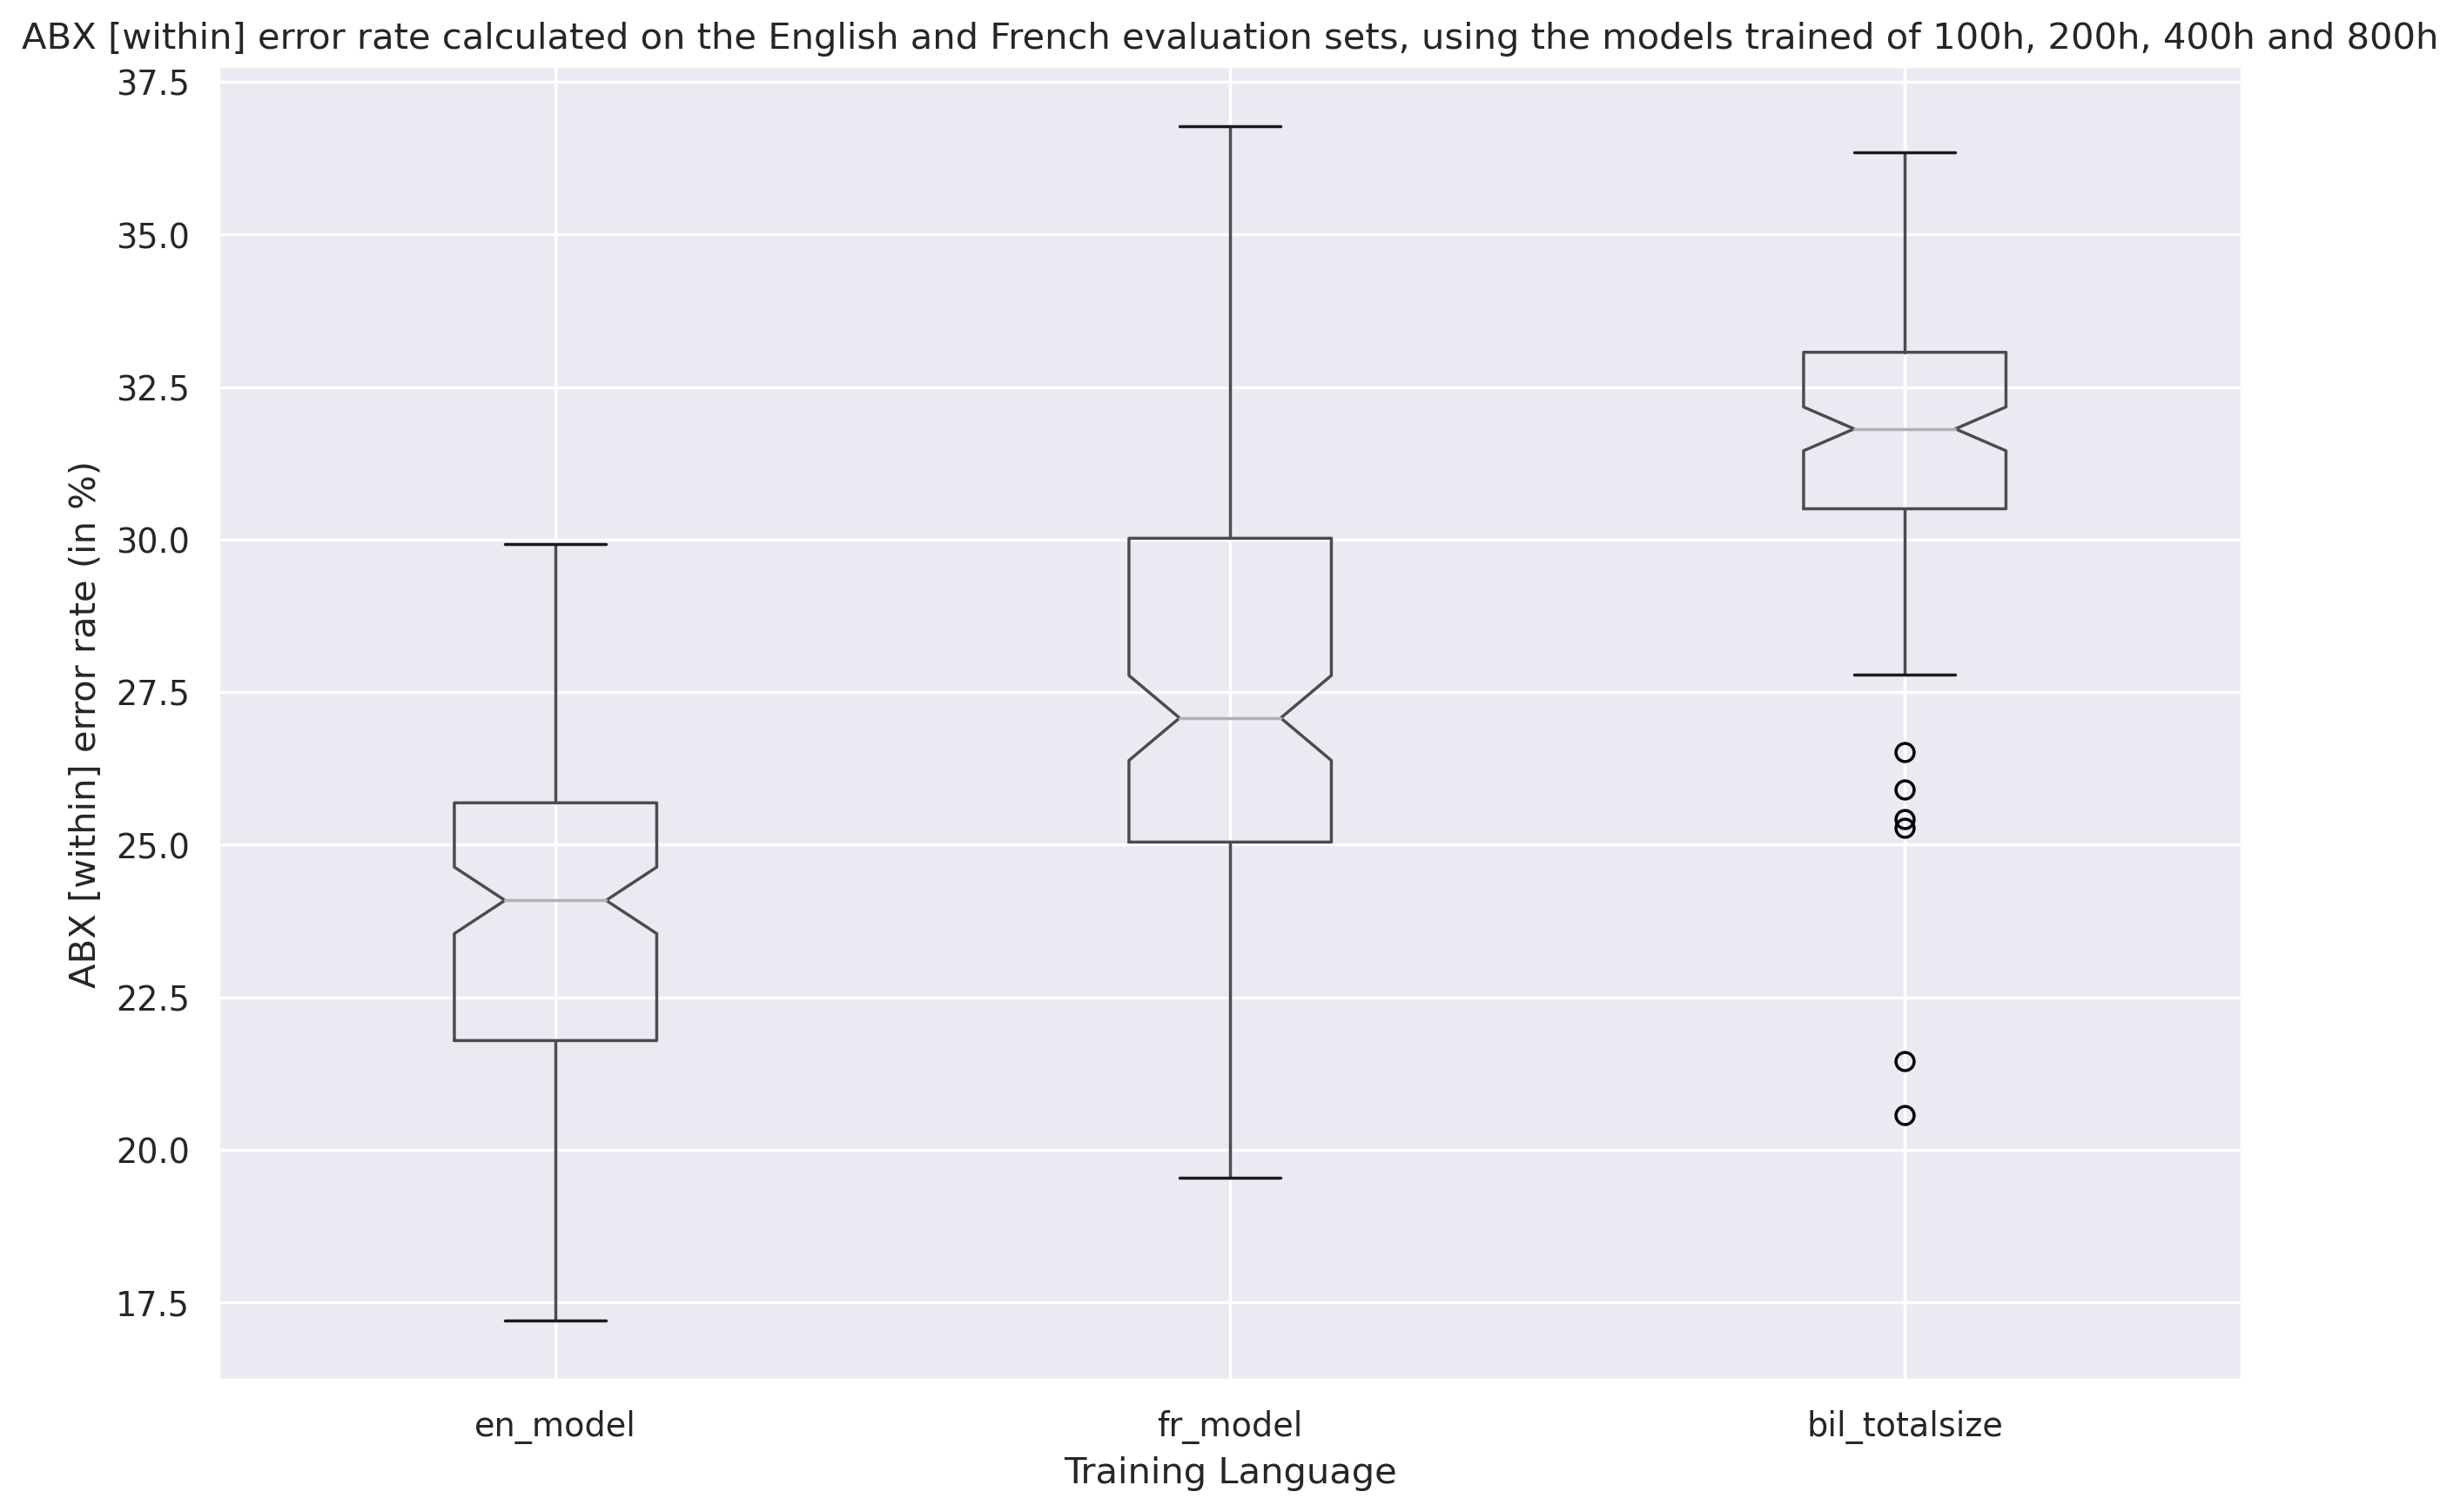

In [9]:
boxplot = df_within[['en_model', 'fr_model', 'bil_totalsize','eval_lang']][df_within["size"] > 50].boxplot(notch=True, return_type='axes')

plt.ylabel('ABX [within] error rate (in %)')
plt.xlabel('Training Language')
plt.title('ABX [within] error rate calculated on the English and French evaluation sets, using the models trained of 100h, 200h, 400h and 800h')



Text(0.5, 1.0, 'ABX [within] error rate calculated on the same and different evaluation sets, using the models trained of 100h, 200h, 400h, 800h, 1600h and 3200h')

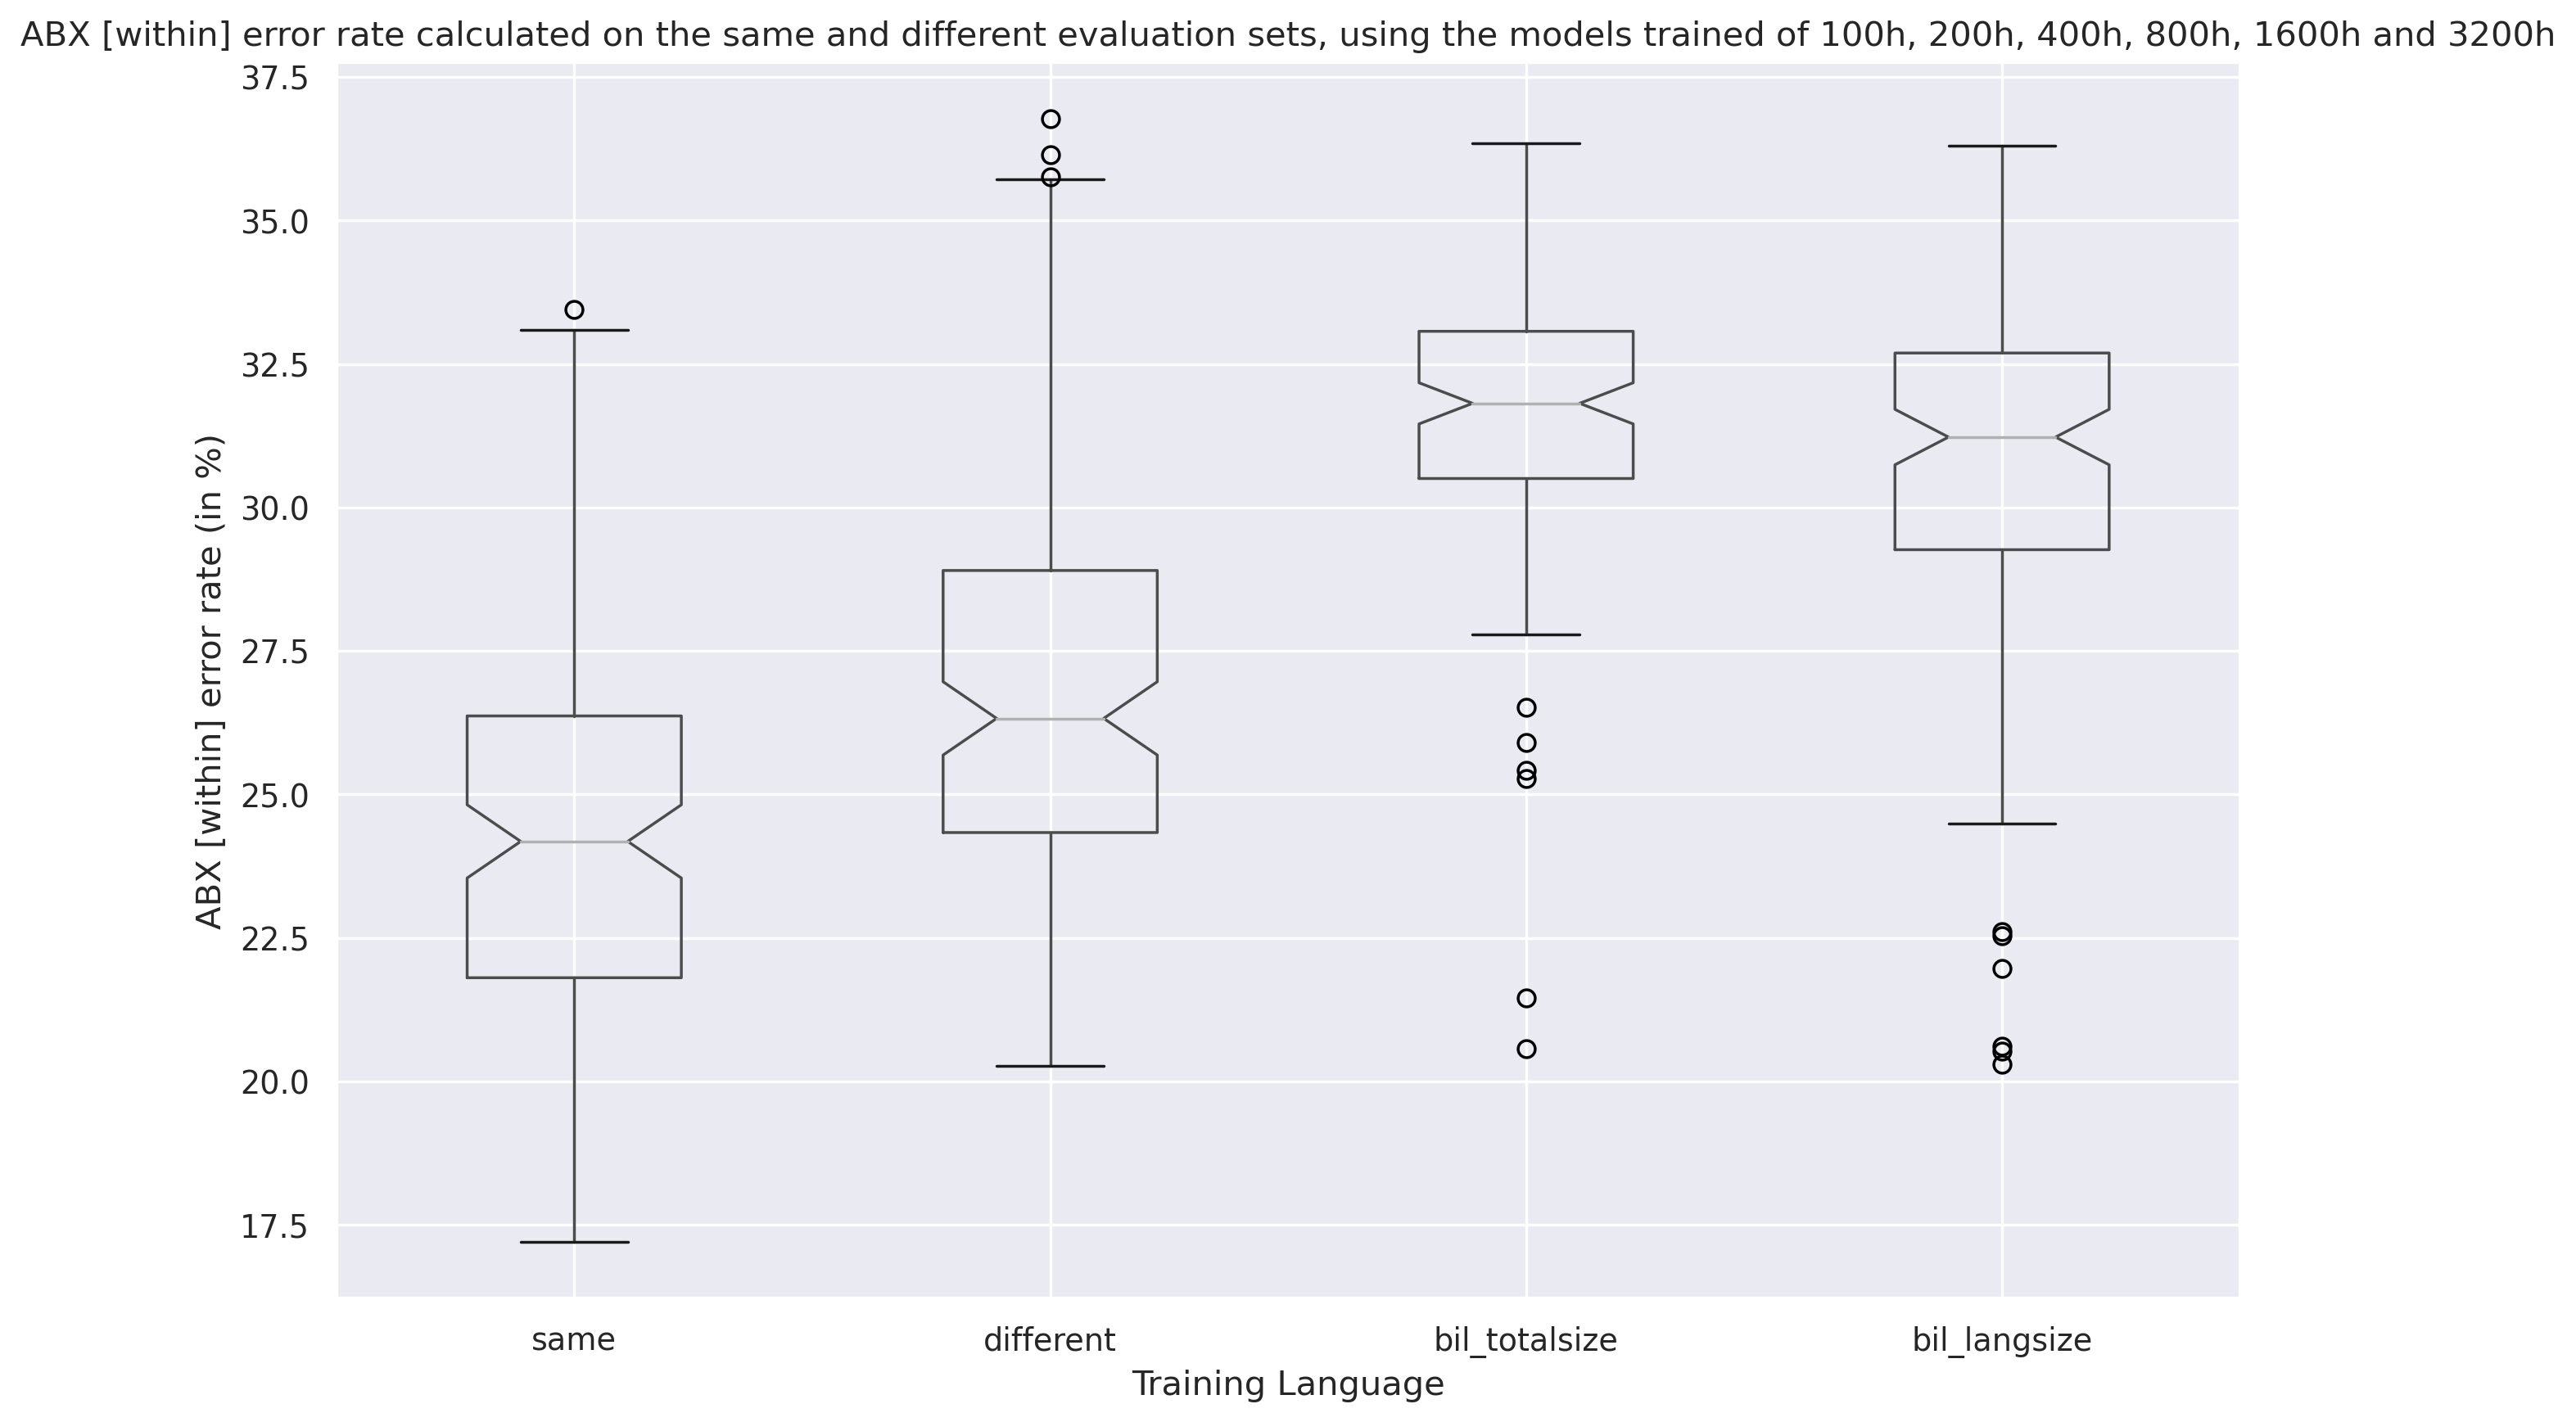

In [10]:
boxplot = df_within[['same', 'different', 'bil_totalsize','bil_langsize','eval_lang']][df_within["size"] > 50].boxplot(notch=True, return_type='axes')

plt.ylabel('ABX [within] error rate (in %)')
plt.xlabel('Training Language')
plt.title('ABX [within] error rate calculated on the same and different evaluation sets, using the models trained of 100h, 200h, 400h, 800h, 1600h and 3200h')



### C2. Monolingual vs Bilingual TotalSize (original)
- ABX : within
- Test set : average English + French
These scores are not calculated on the 50h dataset to ensure reliable comparison

Text(0.5, 1.0, 'ABX [within] error rate calculated on the English and French evaluation sets, using the models trained of 50h, 100h, 200h, 400h and 800h')

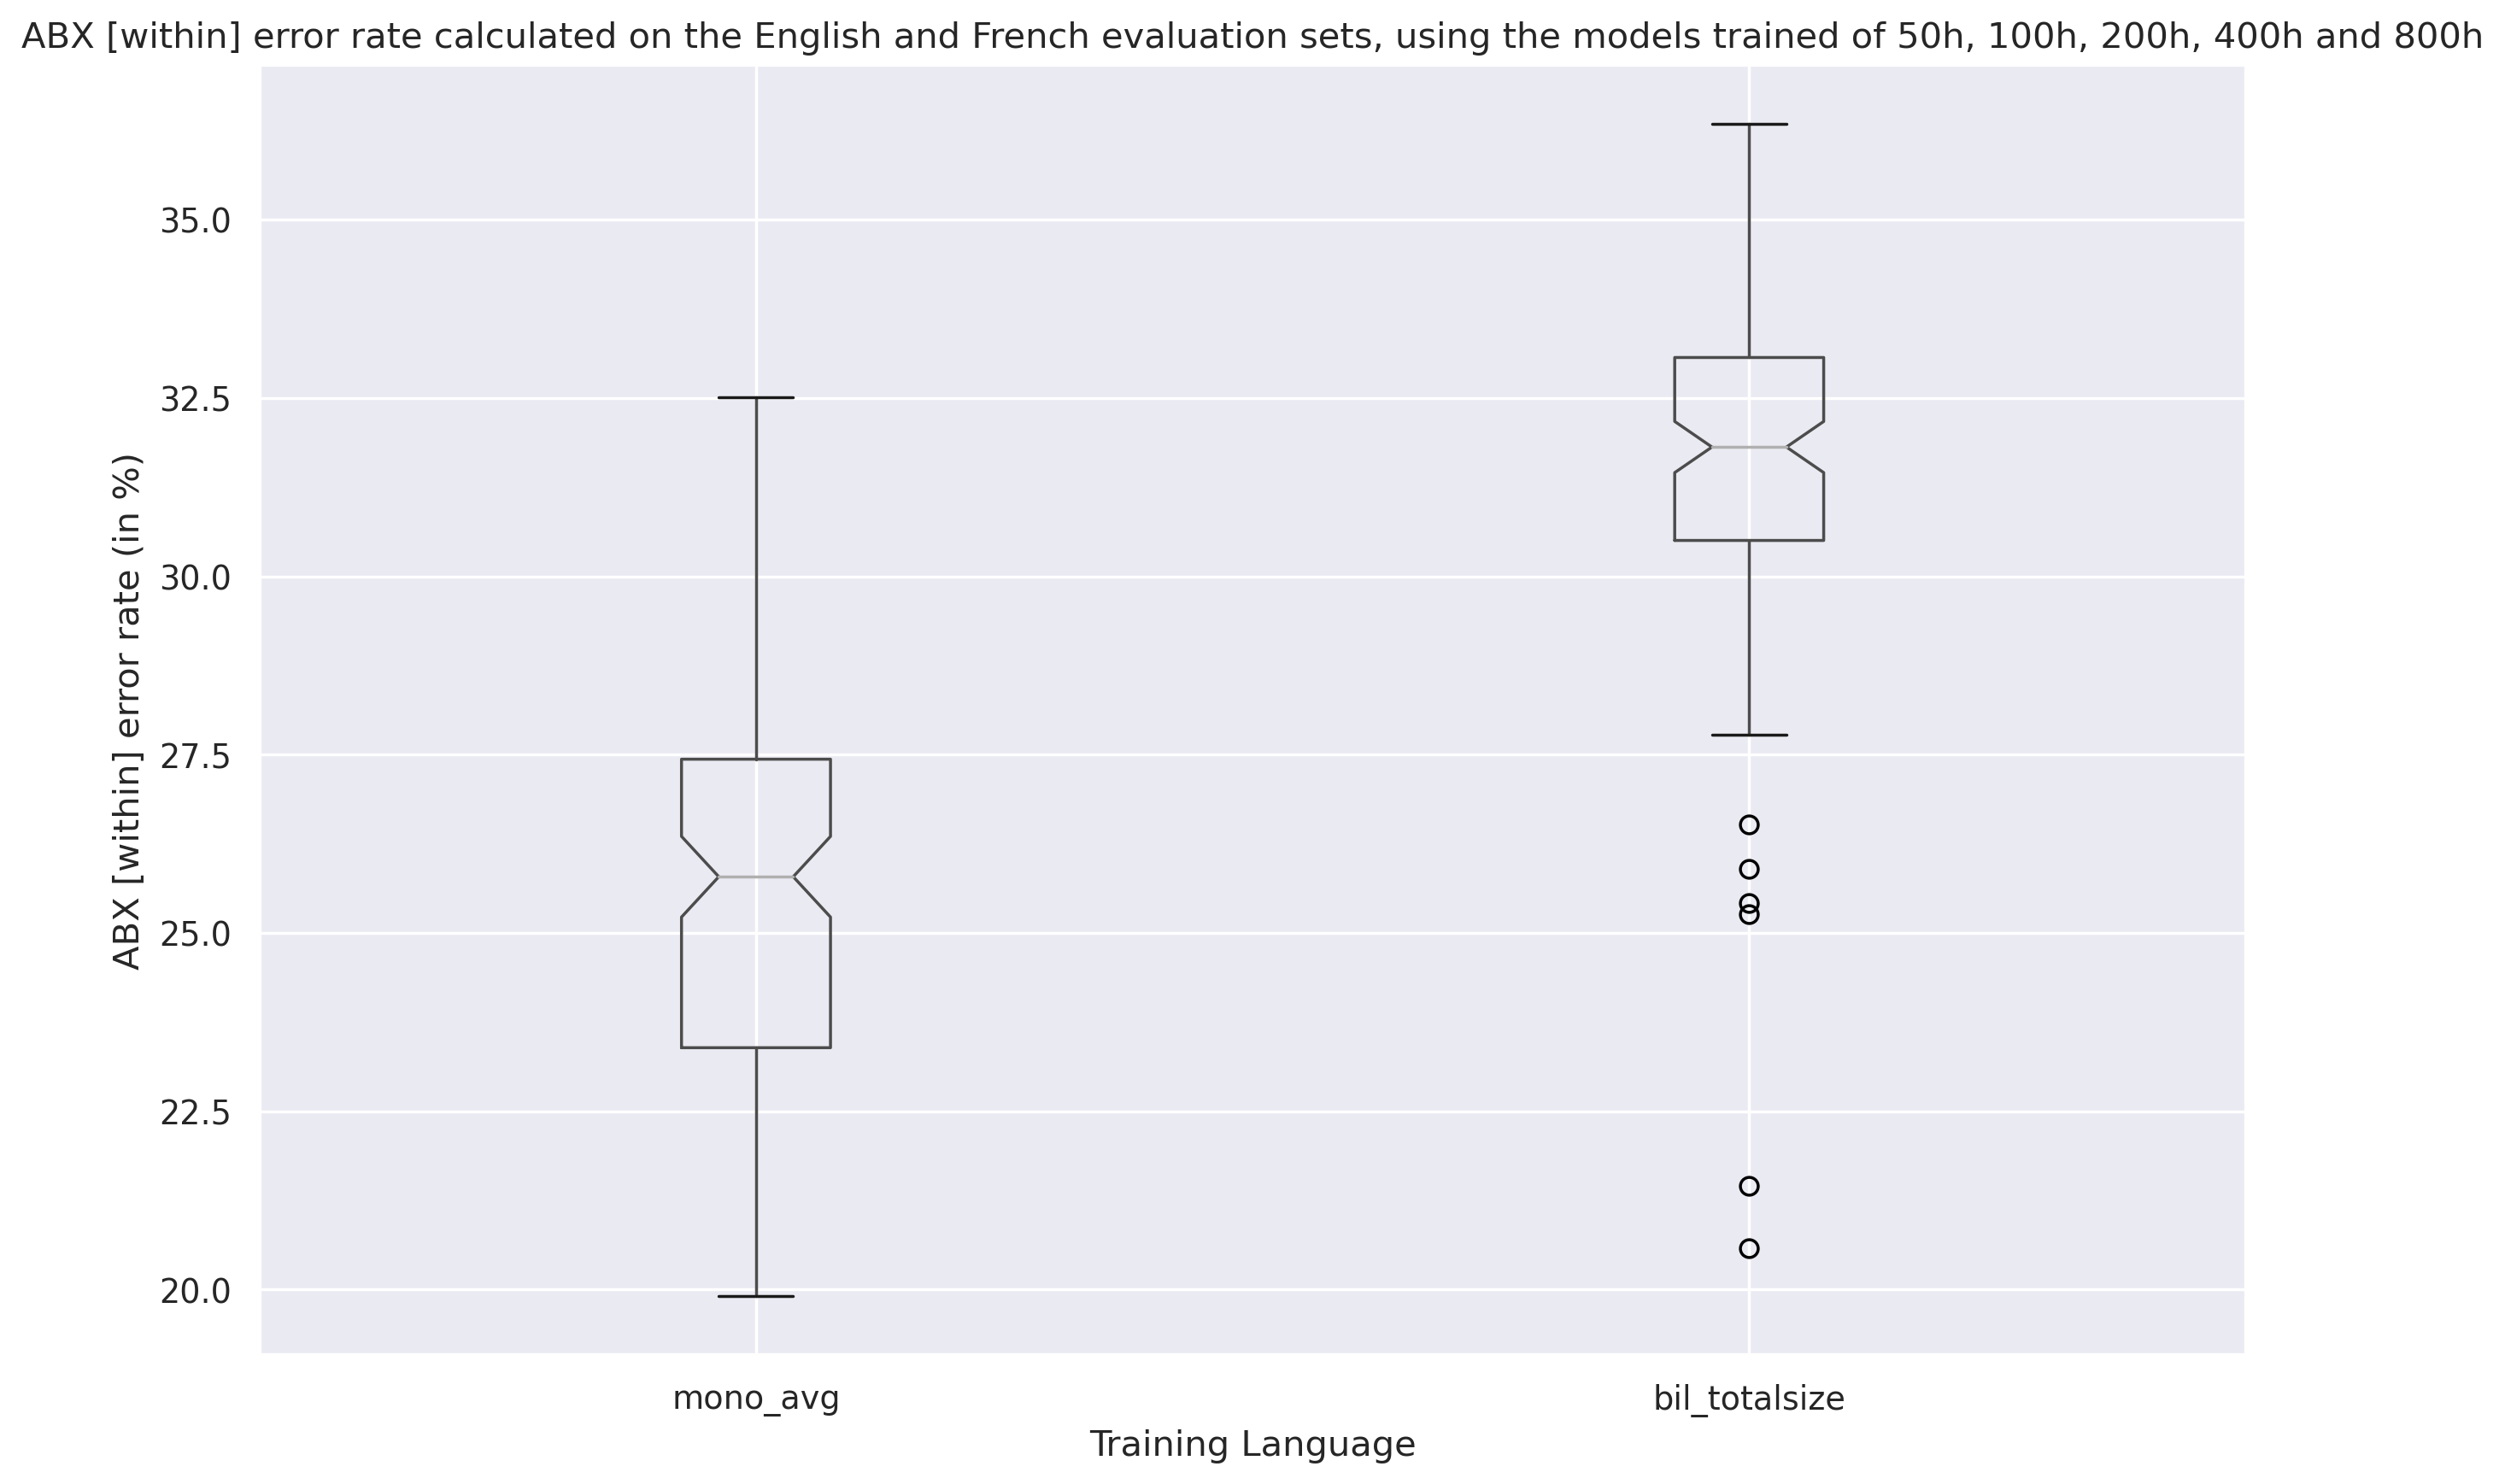

In [11]:
boxplot = df_within[['mono_avg', 'bil_totalsize','eval_lang']].dropna().boxplot(notch=True, return_type='axes')

plt.ylabel('ABX [within] error rate (in %)')
plt.xlabel('Training Language')
plt.title('ABX [within] error rate calculated on the English and French evaluation sets, using the models trained of 50h, 100h, 200h, 400h and 800h')



### C3. Monolingual vs Bilingual LangSize (original)
- ABX : within
- Test set : average English + French
These scores are not calculated on the largest dataset to ensure reliable comparison

Text(0.5, 1.0, 'ABX [within] error rate calculated on the English and French evaluation sets, using the models trained of 50h, 100h, 200h, 400h')

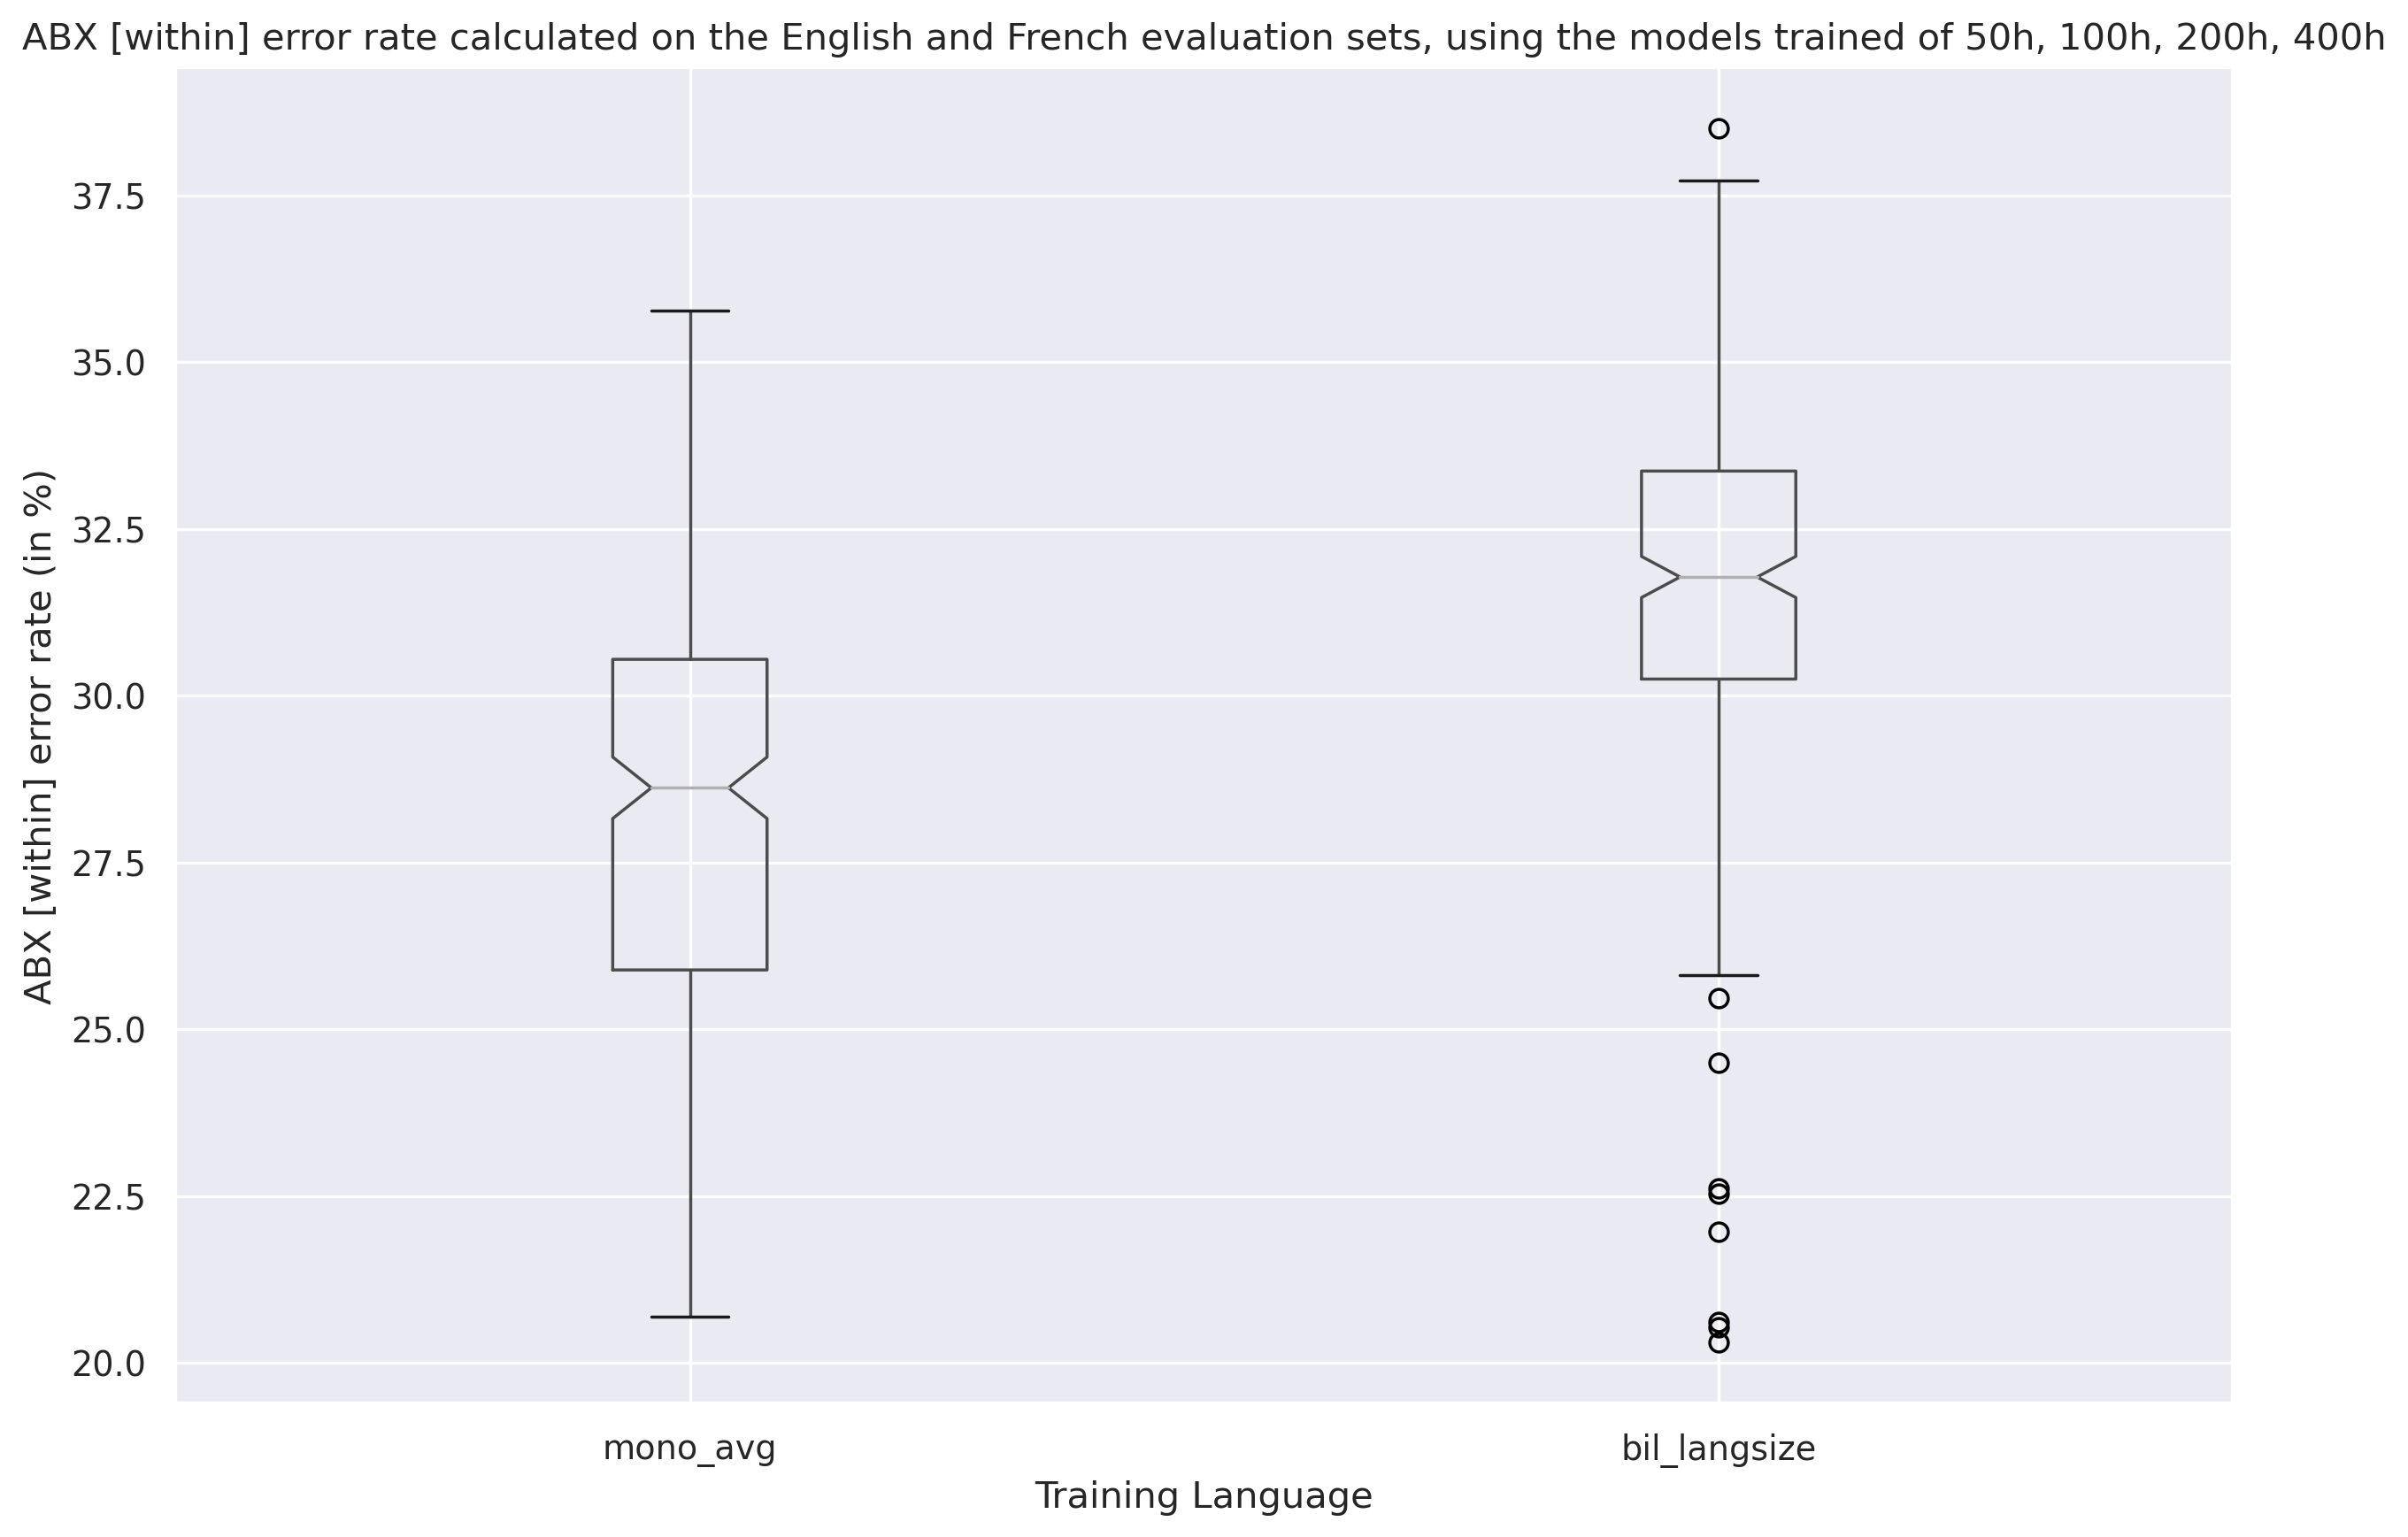

In [12]:
boxplot = df_within[['mono_avg', 'bil_langsize','eval_lang']].dropna().boxplot(notch=True, return_type='axes')

plt.ylabel('ABX [within] error rate (in %)')
plt.xlabel('Training Language')
plt.title('ABX [within] error rate calculated on the English and French evaluation sets, using the models trained of 50h, 100h, 200h, 400h')



## D. Developmental graphs

In [13]:
style_dict =  {'same': 'go-', 'different': 'ro-', 'bil_totalsize': 'bo:', 'bil_langsize':'co:', 'en_model' : 'go--', 'fr_model' : 'ro--', 'mono_avg':'wo-.'}


### D1. Developmental [within] ABX  on both test sets (original)

Text(0.5, 1.0, 'ABX [within] error rate depending on the model type and number of training hours')

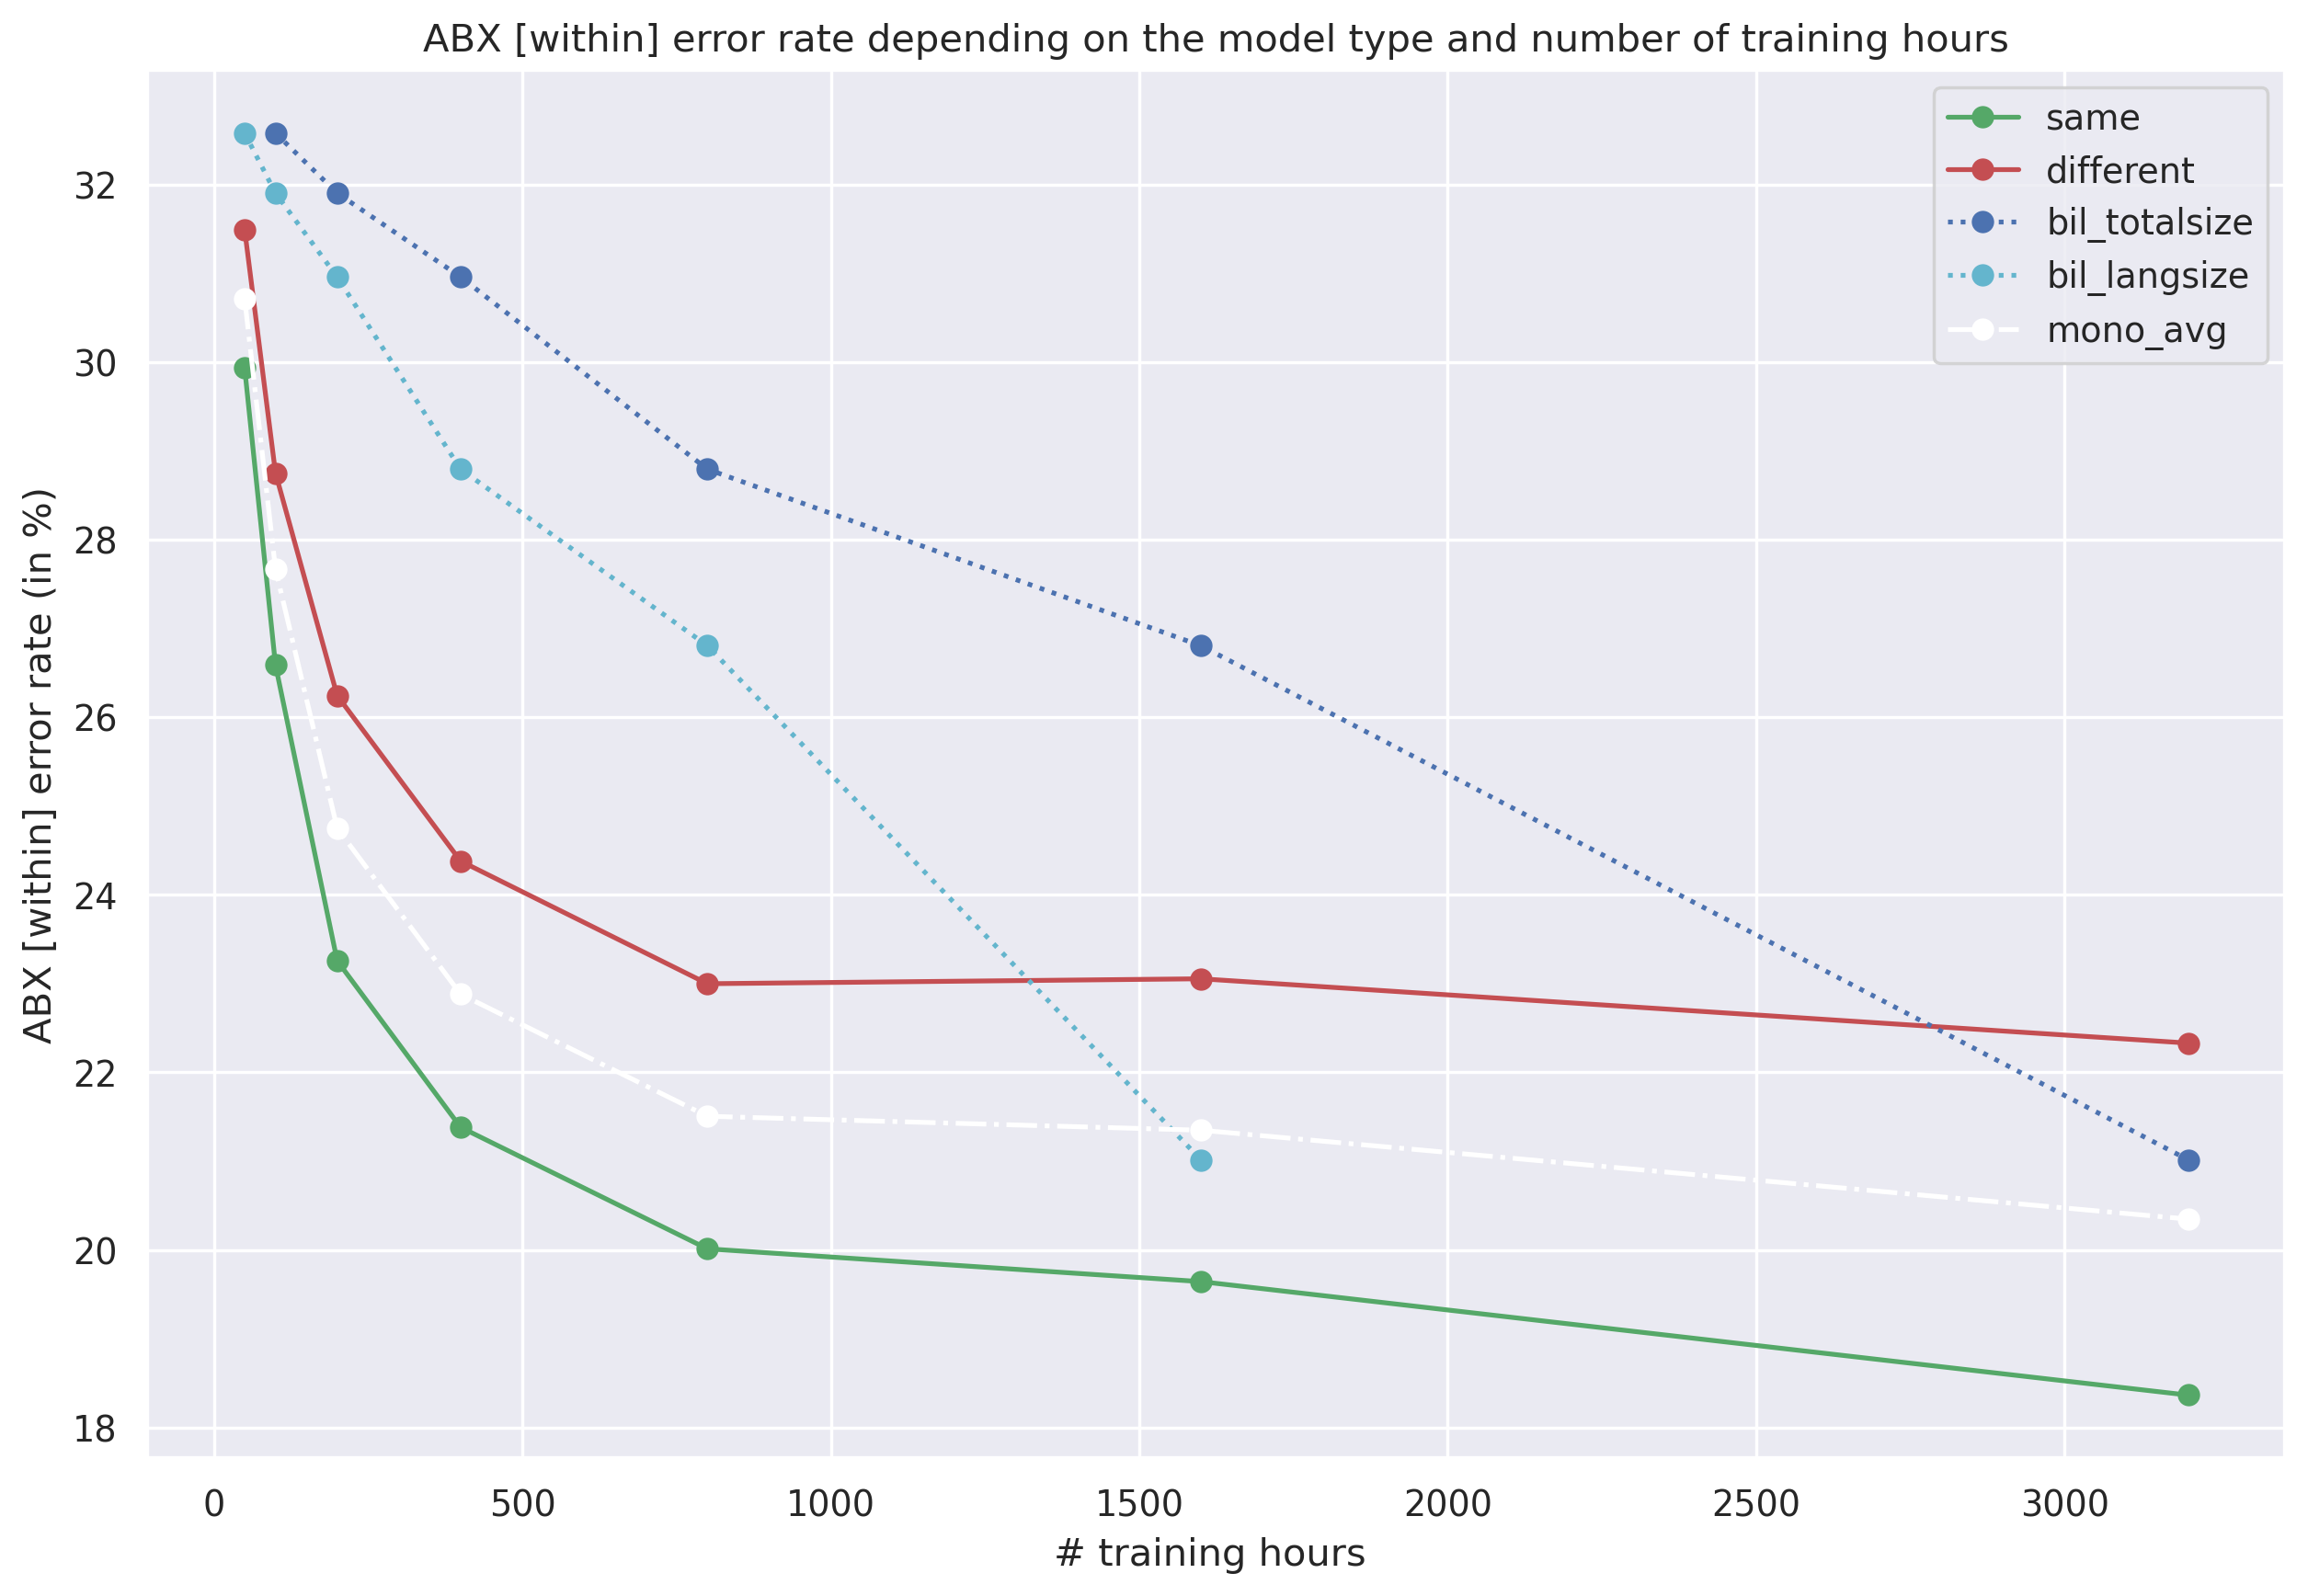

In [14]:
df_within_size[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict)
#df_within_size[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict, yerr=err_within[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']])

#df_within_size[['same', 'different']].plot(style = style_dict)

plt.xlabel('# training hours ')
plt.ylabel("ABX [within] error rate (in %)")
plt.title("ABX [within] error rate depending on the model type and number of training hours")
#plt.ylim([10,21])

Text(0.5, 1.0, 'ABX [across] error rate depending on the model type and number of training hours')

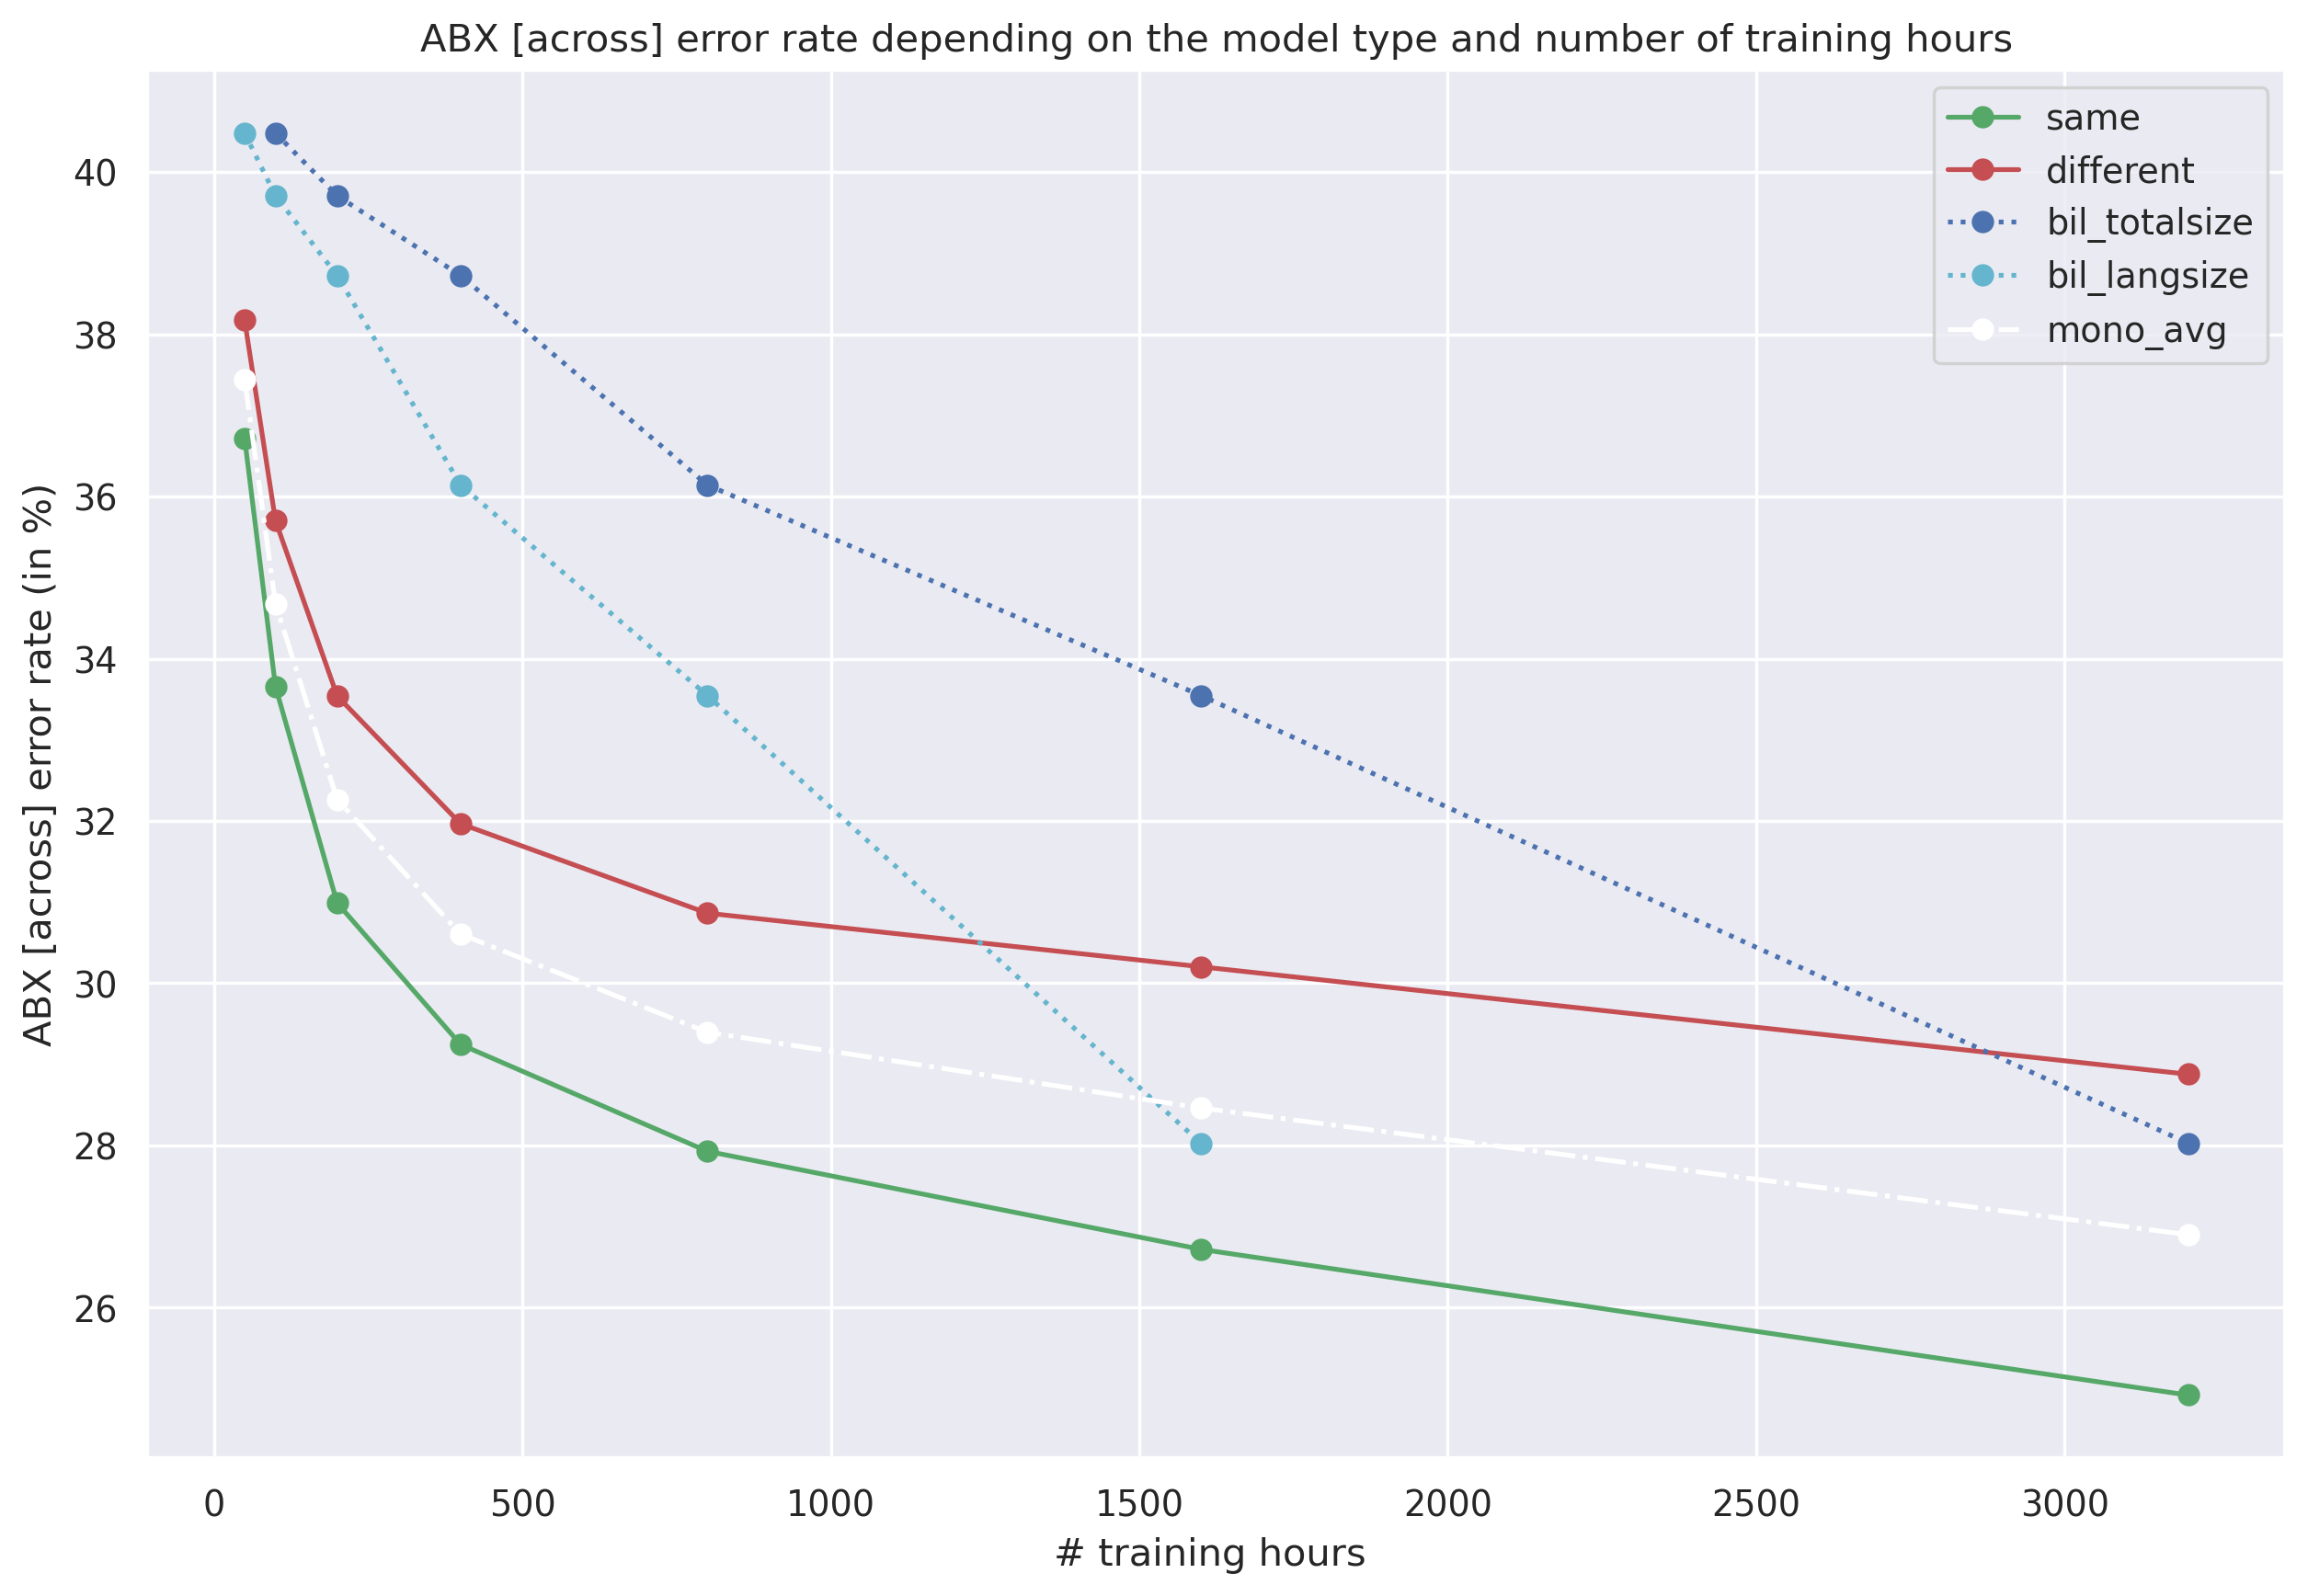

In [15]:
df_across_size[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict)
#df_within_size[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict, yerr=err_within[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']])

#df_within_size[['same', 'different']].plot(style = style_dict)

plt.xlabel('# training hours ')
plt.ylabel("ABX [across] error rate (in %)")
plt.title("ABX [across] error rate depending on the model type and number of training hours")
#plt.ylim([10,21])

In [16]:
err_within[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']]

same  different  bil_totalsize  bil_langsize  mono_avg
size                                                            
50    3.430139   3.377135            NaN      2.249157  2.057044
100   2.904513   3.295160       1.642289      2.116929  1.824468
200   2.496563   2.745480       1.554812      2.032780  1.344182
400   1.801406   1.739018       1.621397      2.292563  0.690291
800   1.953717   1.822145       2.043178      3.505724  0.629210
1600  2.006823   1.970857       1.693767      1.072259  0.239612
3200  1.654751   2.910117       0.623400           NaN  0.627683

In [17]:
df_within.groupby('size').std()


en_model  fr_model  bil_totalsize_A  bil_totalsize_B      same  \
size                                                                   
50    2.727096  3.179518              NaN              NaN  3.430139   
100   1.842355  2.951024         2.209058         2.172341  2.904513   
200   1.798210  2.766827         1.798411         2.414500  2.496563   
400   1.905904  1.599711         2.216577         1.892723  1.801406   
800   1.790042  1.867976         2.123864         2.457069  1.953717   
1600  2.010441  1.975466         3.520639         3.995856  2.006823   
3200  2.175723  3.431089         0.224090         1.470889  1.654751   

      different  bil_langsize  bil_totalsize  mono_avg  
size                                                    
50     3.377135      2.249157            NaN  2.057044  
100    3.295160      2.116929       1.642289  1.824468  
200    2.745480      2.032780       1.554812  1.344182  
400    1.739018      2.292563       1.621397  0.690291  
800    1.822145      3.505724       2.043178  0.629210  
1600   1.970857      1.072259       1.693767  0.239612  
3200   2.910117           NaN       0.623400  0.627683

Text(0.5, 1.0, 'ABX [within] error rate depending on the model type and number of training hours')

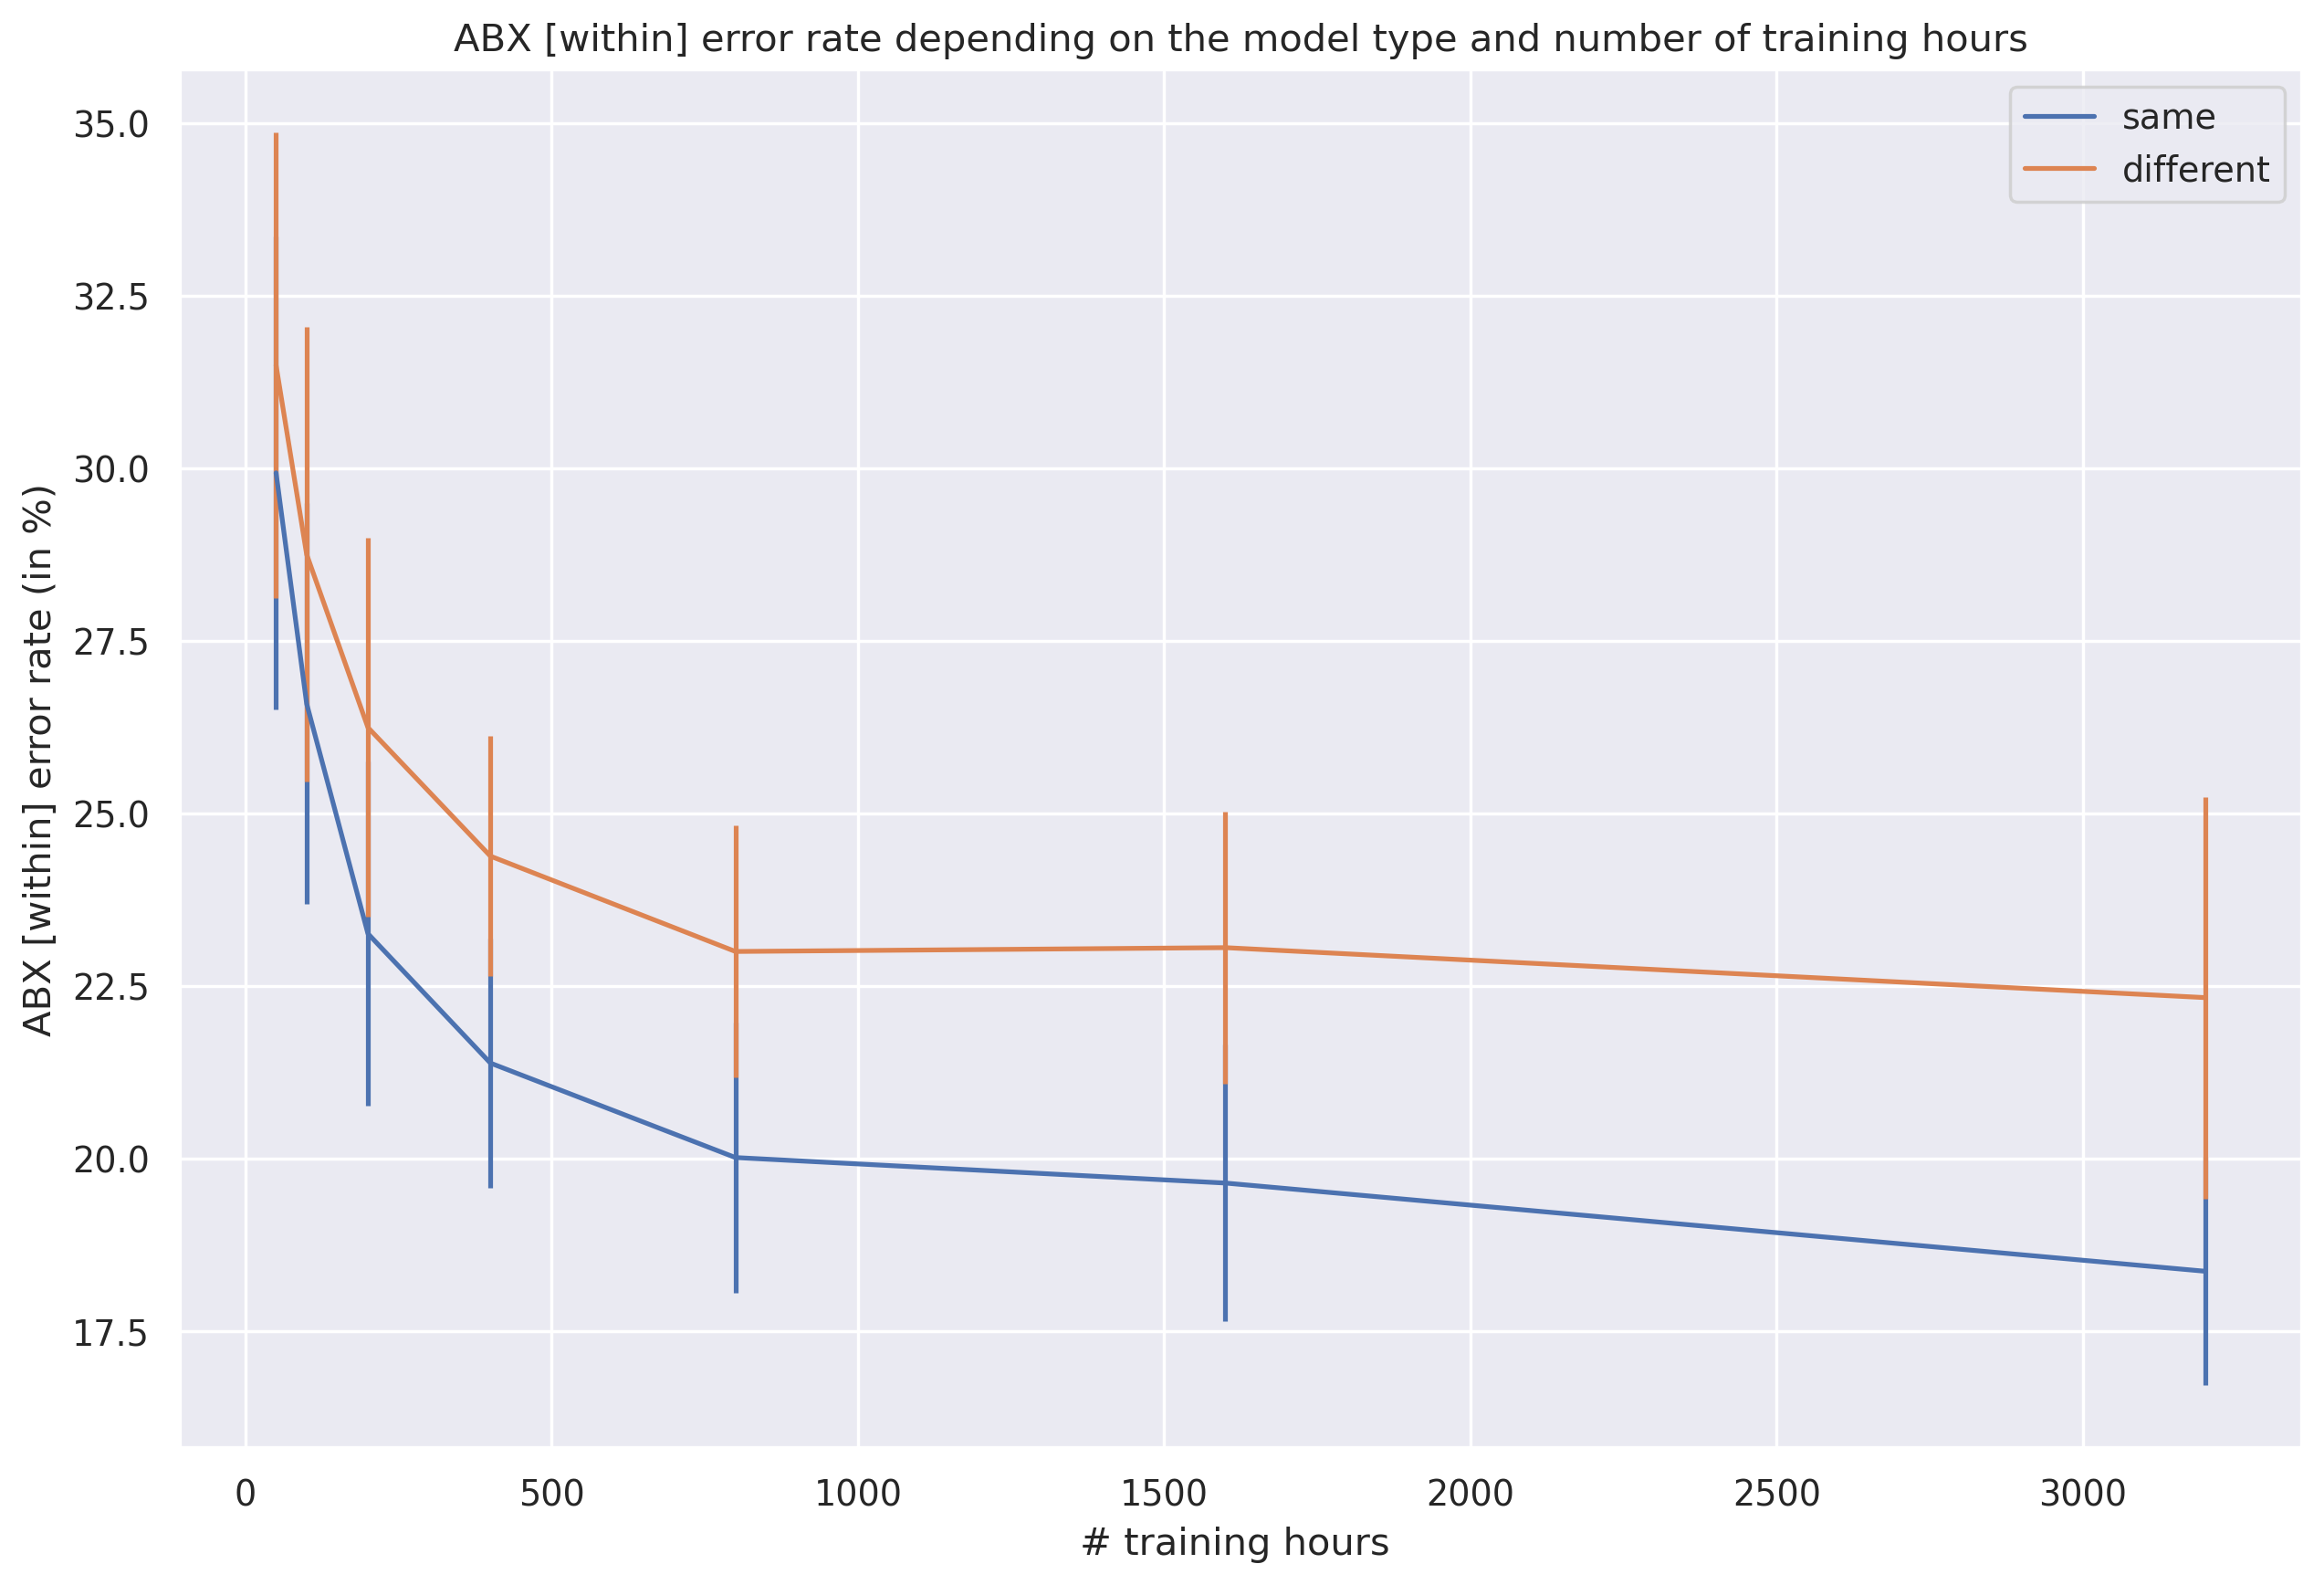

In [18]:
#doesn't work as this is not split by same vs different?

#df_within_size[['bil_totalsize']].plot(style = style_dict)
df_within_size[['same', 'different']].plot(style = style_dict, yerr=err_within[['same', 'different']])


plt.xlabel('# training hours ')
plt.ylabel("ABX [within] error rate (in %)")
plt.title("ABX [within] error rate depending on the model type and number of training hours")


Text(0.5, 1.0, 'ABX [within] error rate on both test sets depending on the model type and number of training hours (log)')

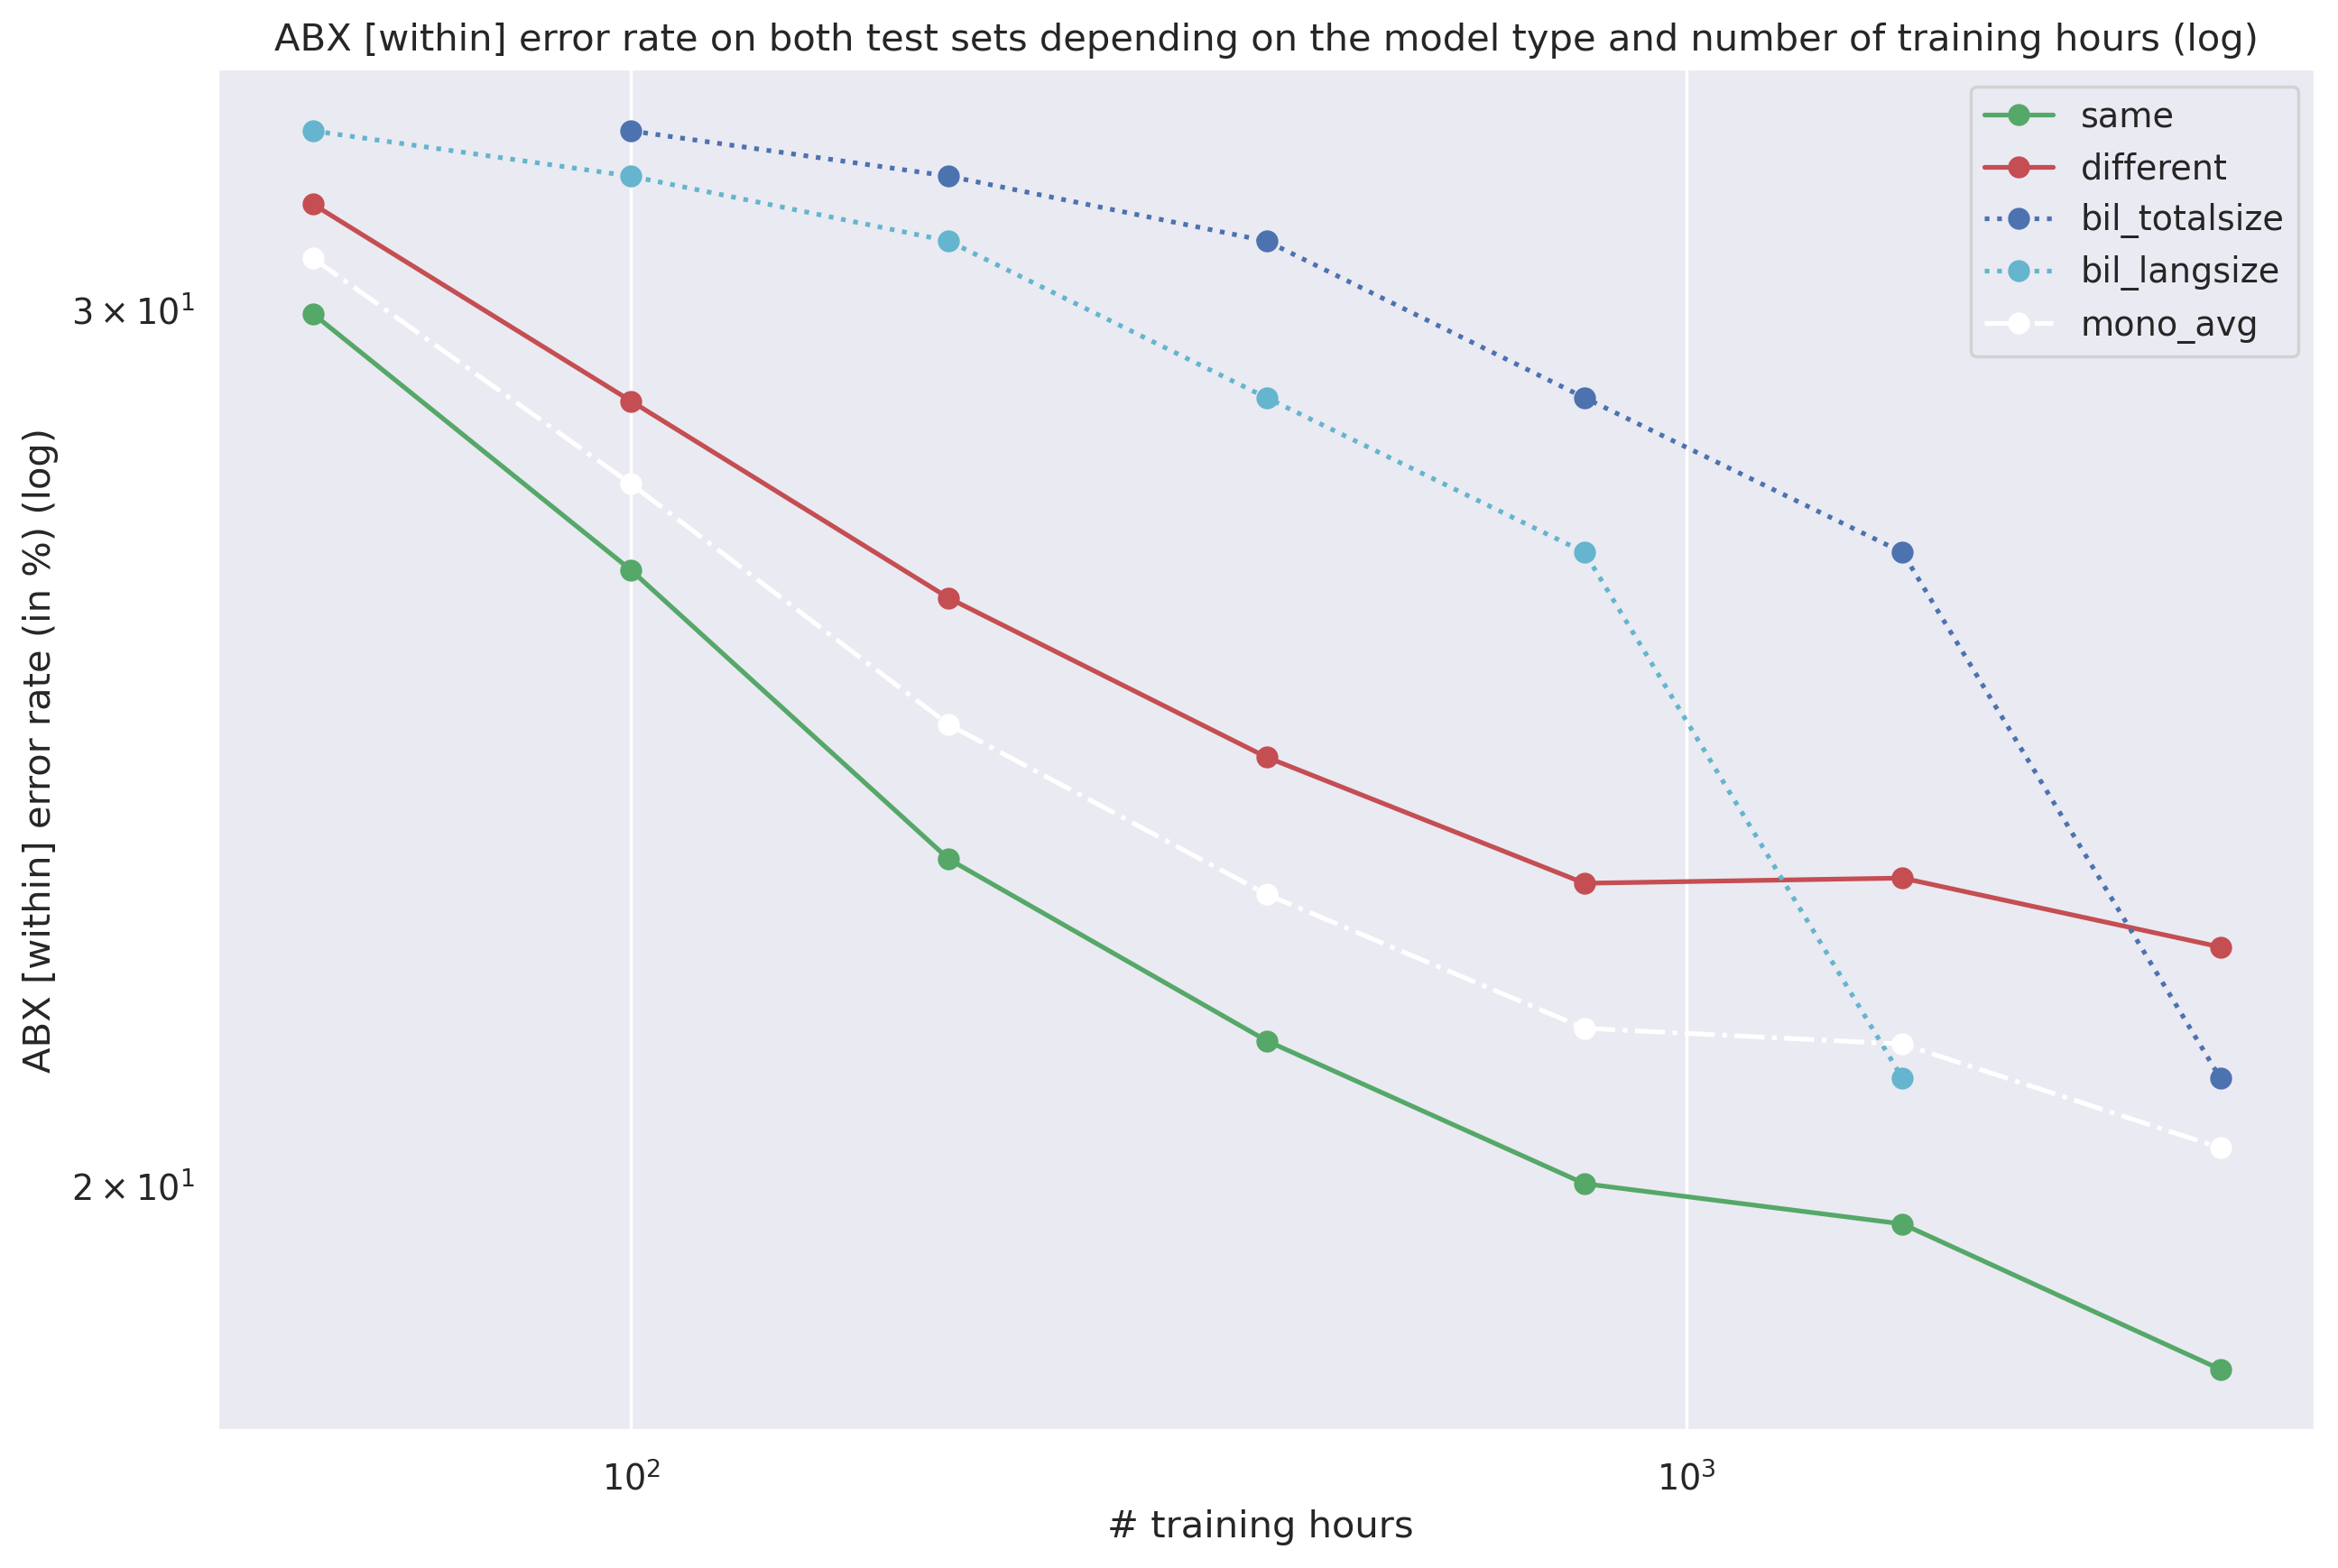

In [19]:
df_within_size[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict, loglog=True)
#df_within_size[['same', 'different']].plot(style = style_dict, loglog=True)

plt.xlabel('# training hours ')
plt.ylabel("ABX [within] error rate (in %) (log)")
plt.title("ABX [within] error rate on both test sets depending on the model type and number of training hours (log)")
#plt.ylim([10,21])

Text(0.5, 1.0, 'ABX [across] error rate on both test sets depending on the model type and number of training hours ')

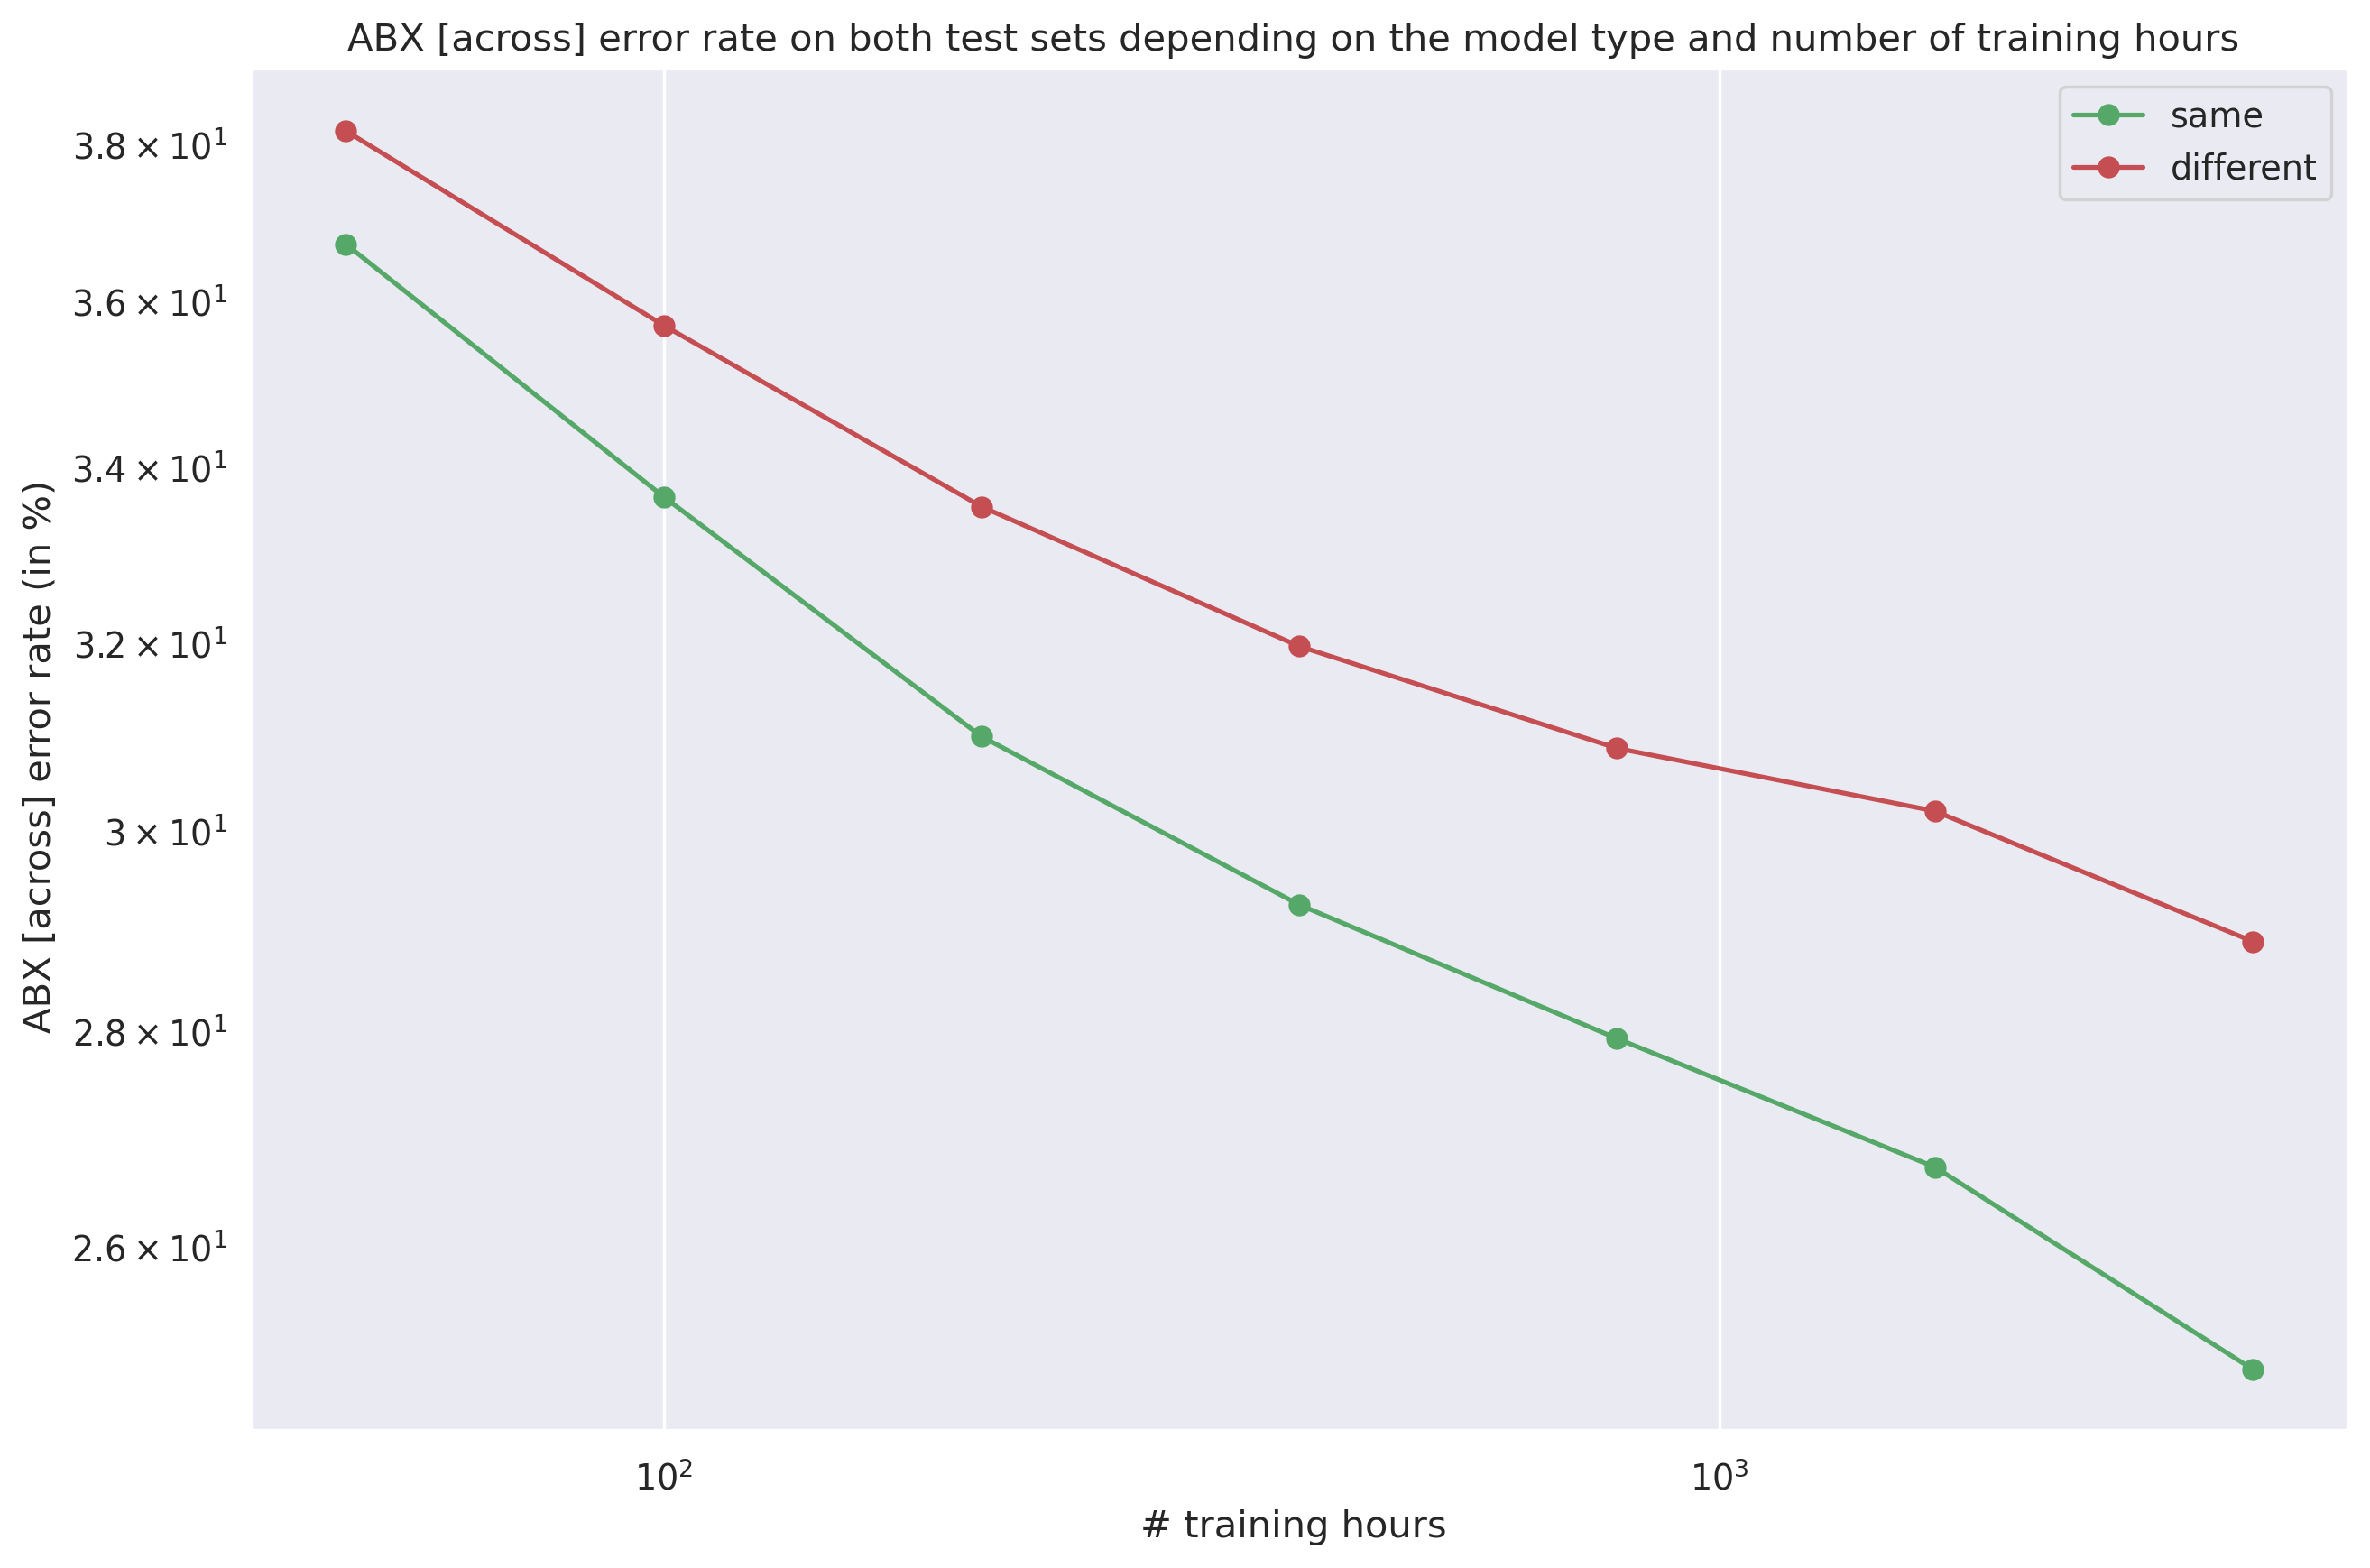

In [20]:
#df_across_size[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict)
df_across_size[['same', 'different']].plot(style = style_dict, loglog=True)

plt.xlabel('# training hours ')
plt.ylabel("ABX [across] error rate (in %) ")
plt.title("ABX [across] error rate on both test sets depending on the model type and number of training hours ")
#plt.ylim([10,21])

Text(0.5, 1.0, 'ABX [across] error rate on both test sets depending on the model type and number of training hours (log)')

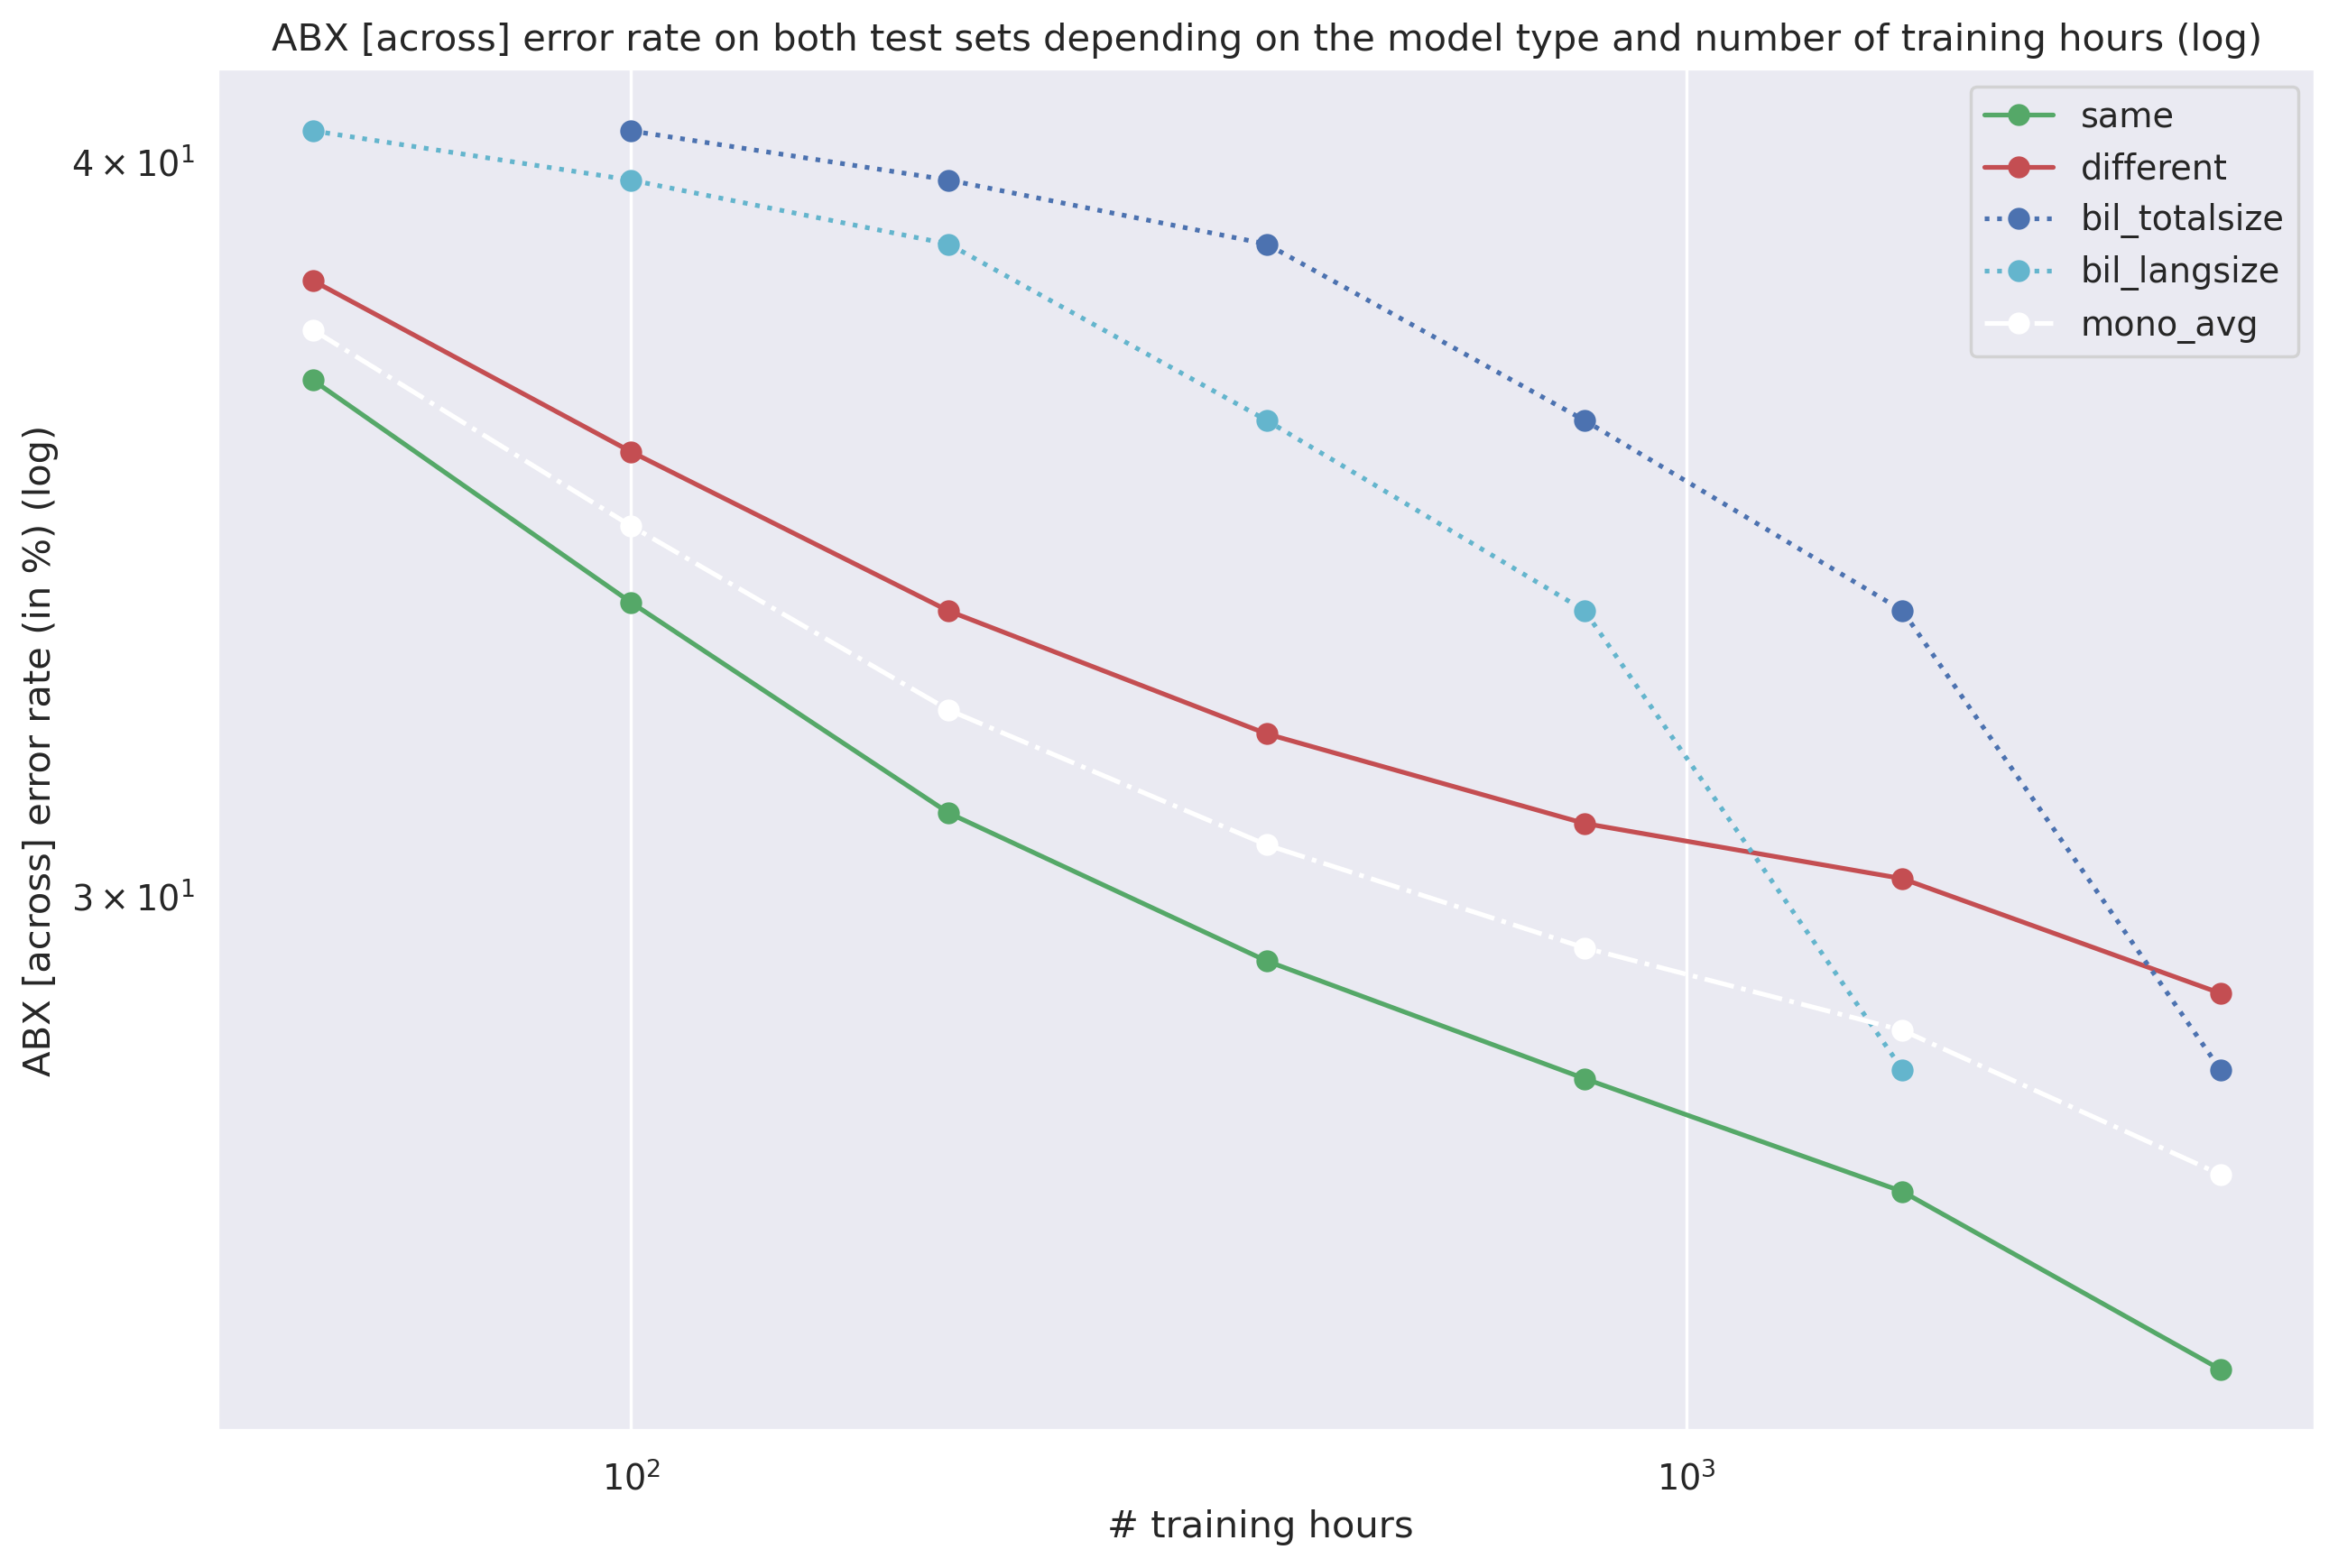

In [21]:
df_across_size[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict, loglog=True)
#df_across_size[['same', 'different']].plot(style = style_dict, loglog=True)

plt.xlabel('# training hours ')
plt.ylabel("ABX [across] error rate (in %) (log)")
plt.title("ABX [across] error rate on both test sets depending on the model type and number of training hours (log)")
#plt.ylim([10,21])

### D3a. Developmental [within] ABX  on the French test set 

Text(0.5, 1.0, 'ABX [within] error rate on the FRENCH evaluation set')

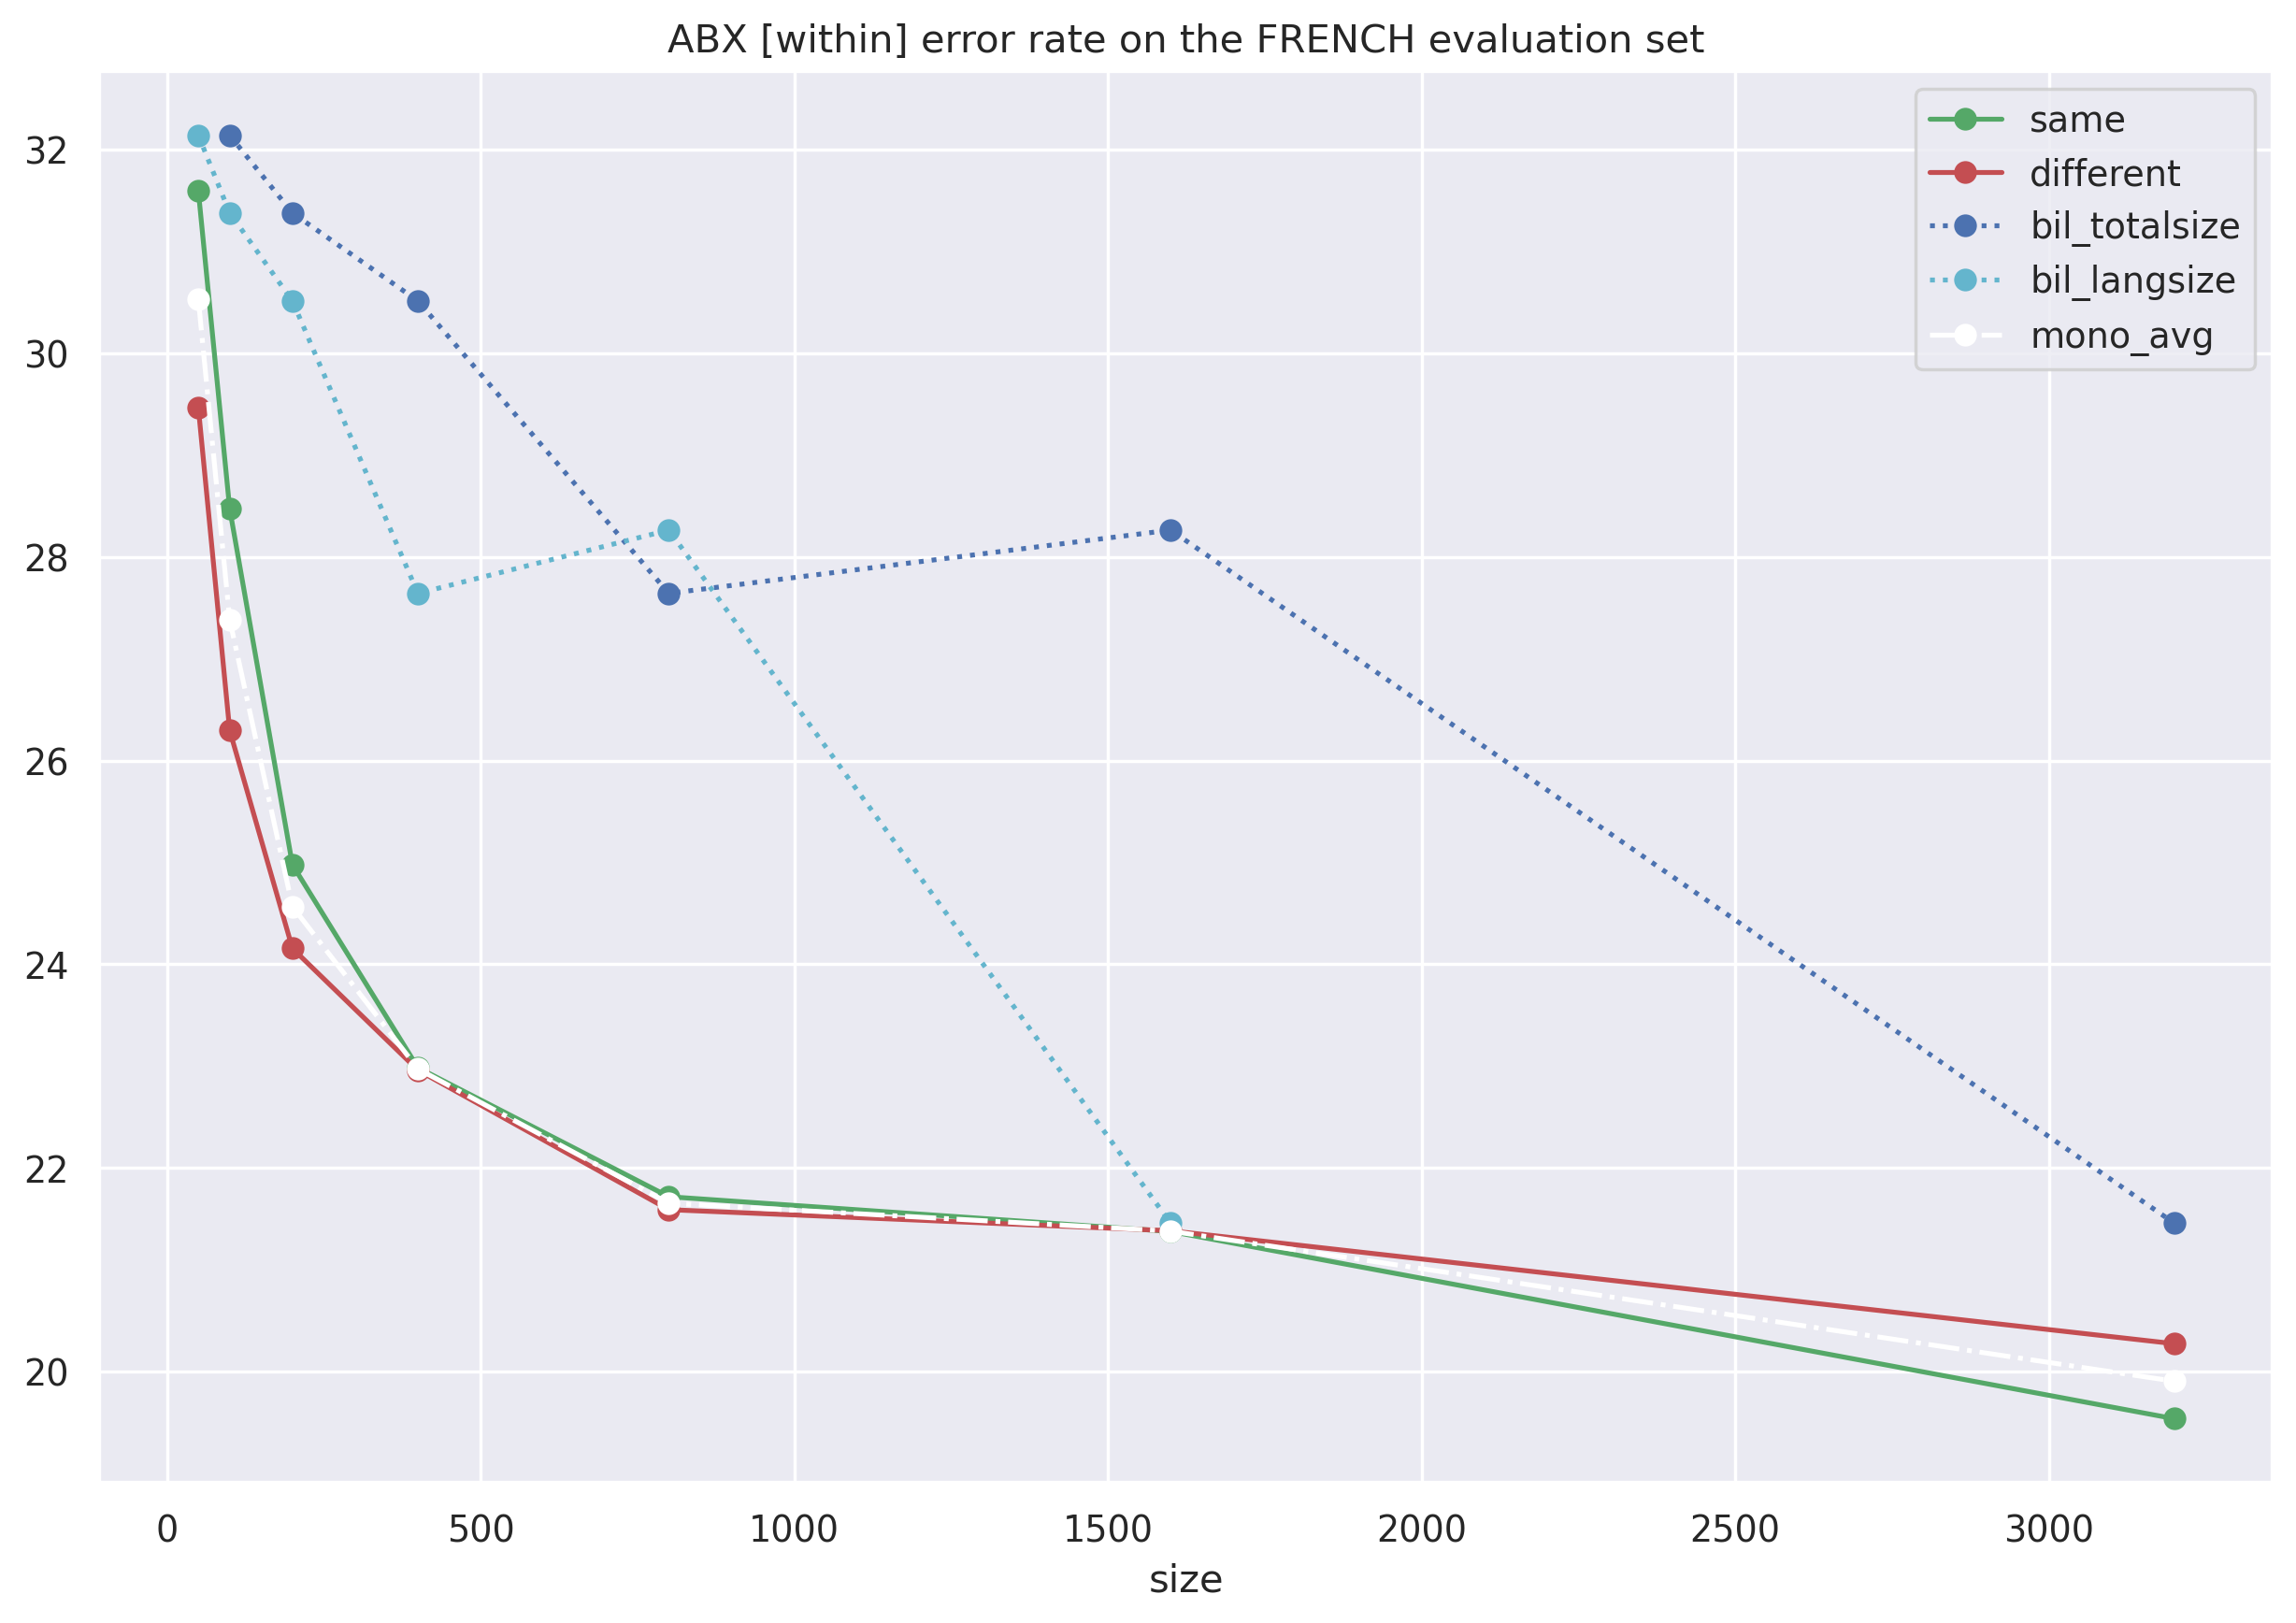

In [22]:
l="fr"
df_tmp = df_within[df_within["eval_lang"]==l].groupby(by="size").mean()
df_tmp[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict)
plt.title("ABX [within] error rate on the FRENCH evaluation set")


### D3c. Developmental [within] ABX  on the French test set - Loglog scale

Text(0, 0.5, 'ABX [within] error rate (log)')

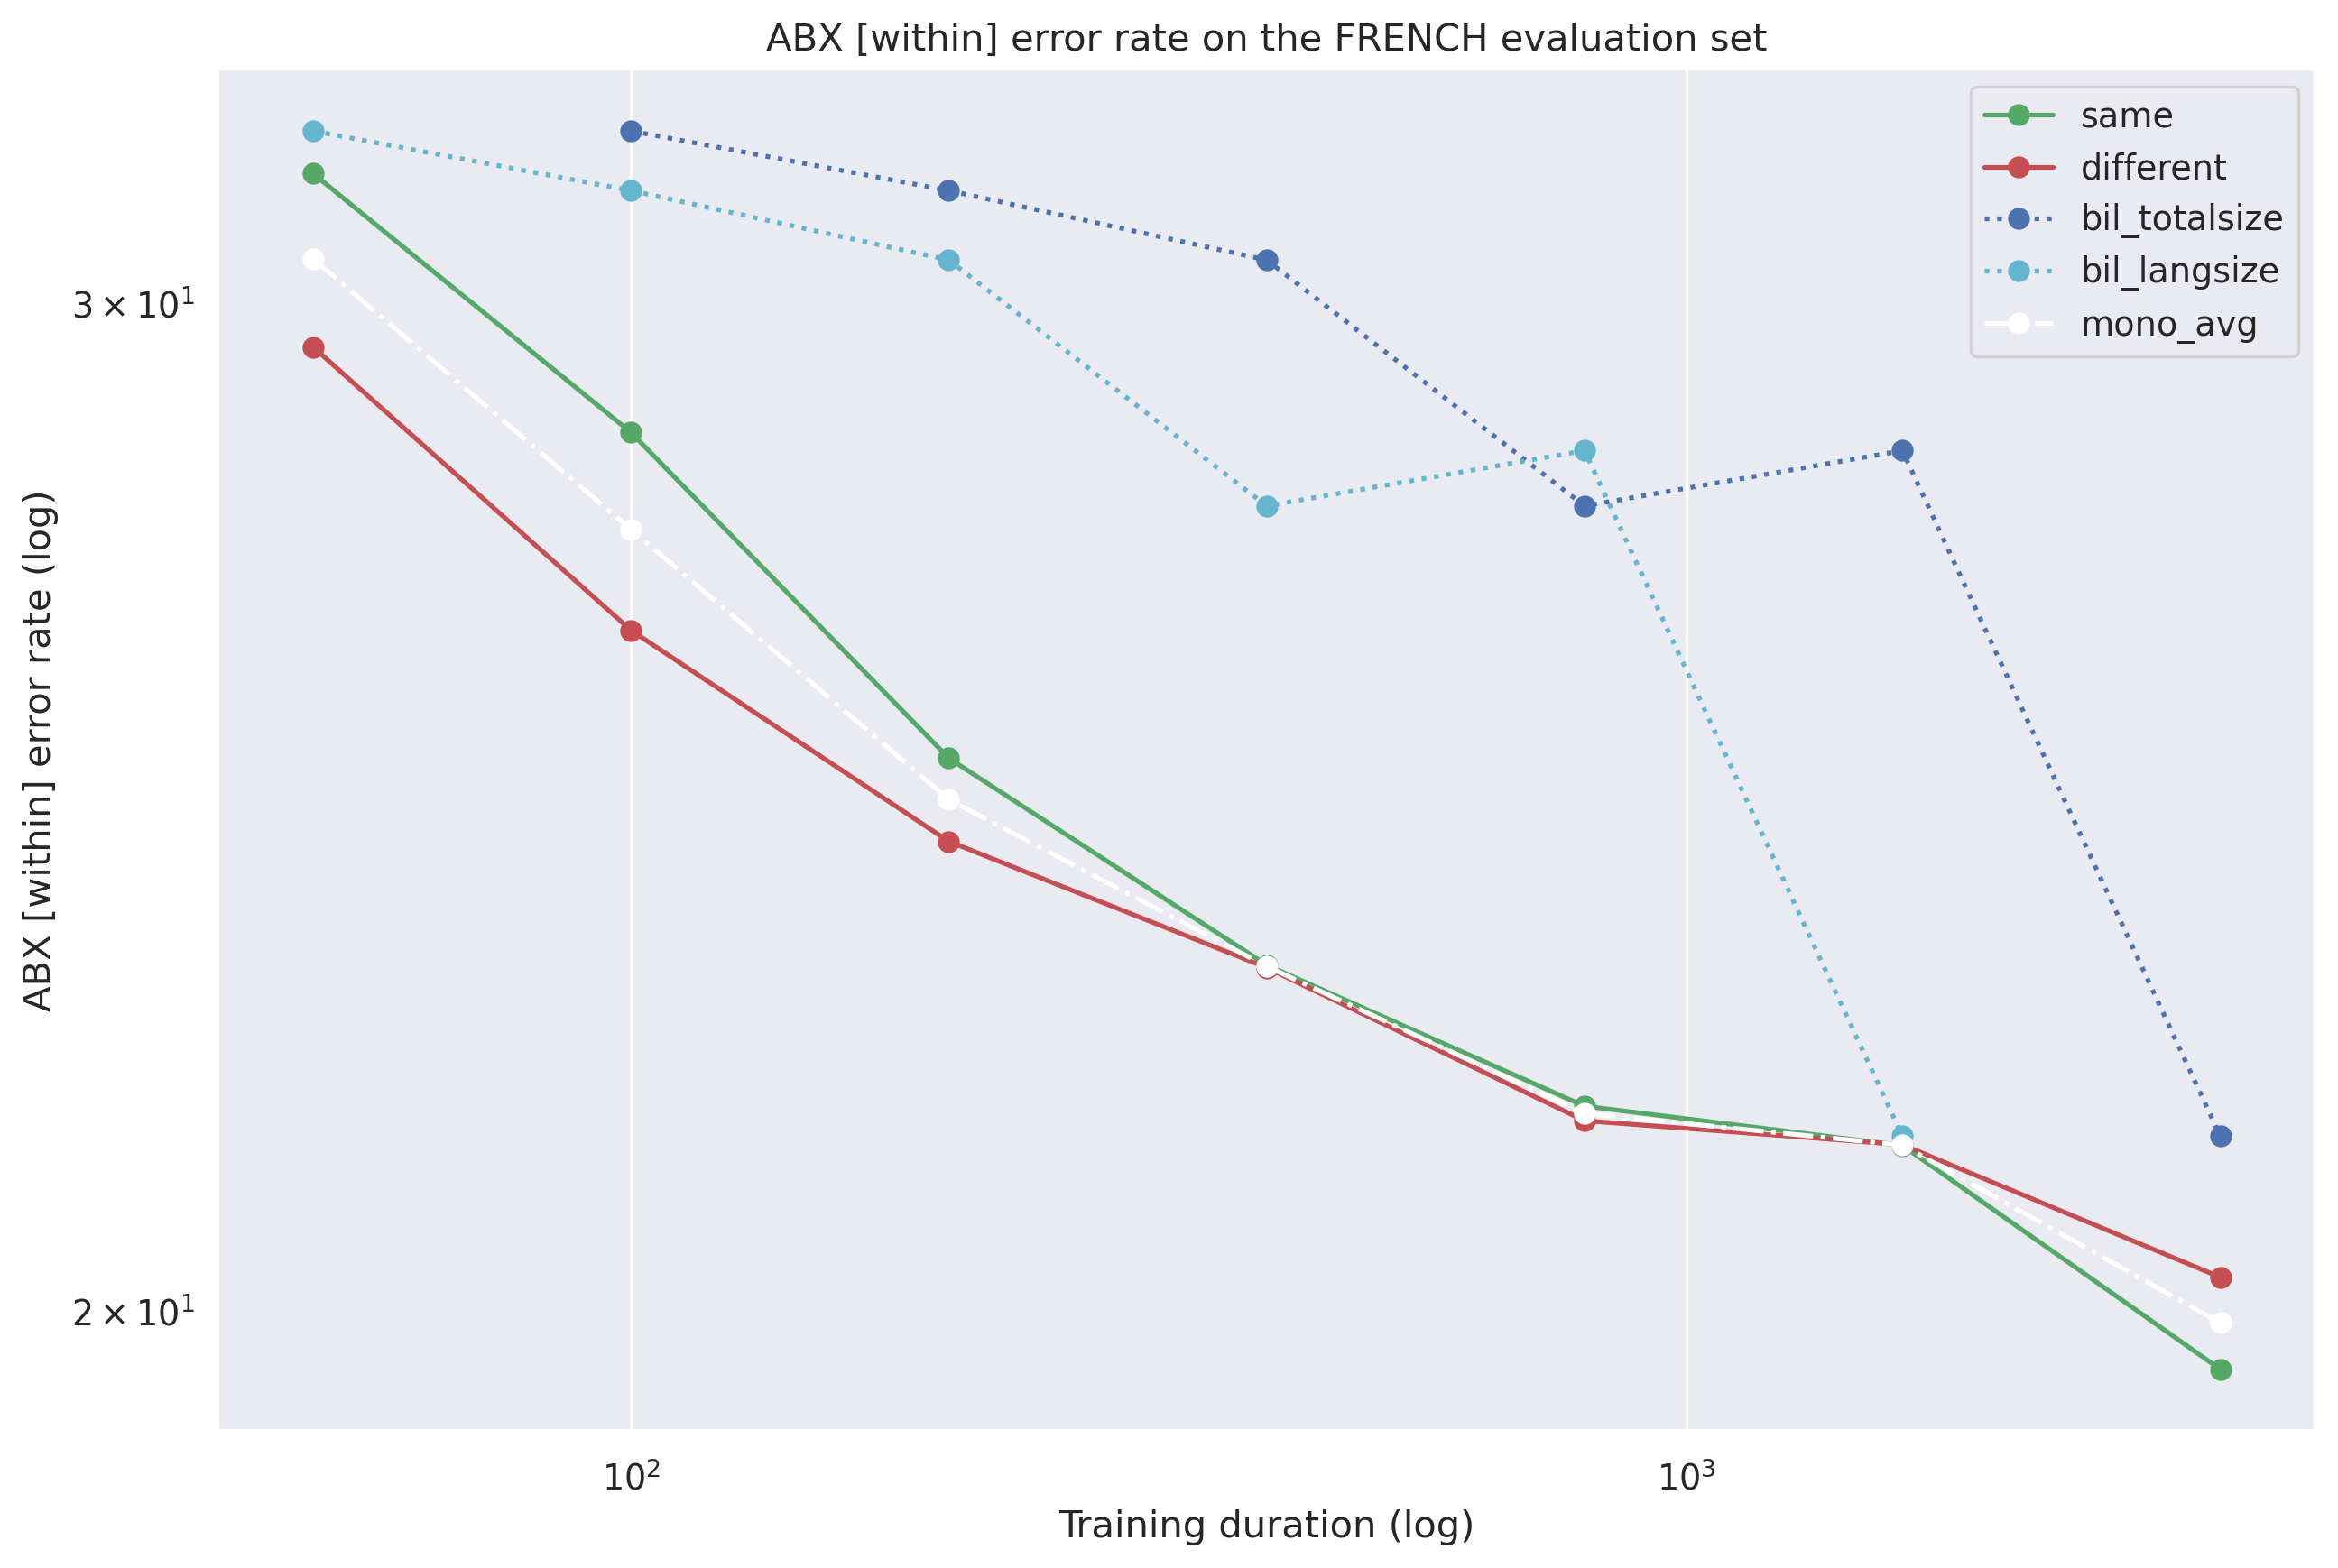

In [23]:
#log

l="fr"
df_tmp = df_within[df_within["eval_lang"]==l].groupby(by="size").mean()
df_tmp = df_tmp[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict, loglog=True)
#df_tmp = df_tmp[['same', 'different']].plot(style = style_dict, loglog=True)

plt.title("ABX [within] error rate on the FRENCH evaluation set")
plt.xlabel("Training duration (log)")
plt.ylabel("ABX [within] error rate (log)")
#plt.ylim([10,17])

### D4a. Developmental [within] ABX on the English test set

Text(0, 0.5, 'ABX [within] error rate')

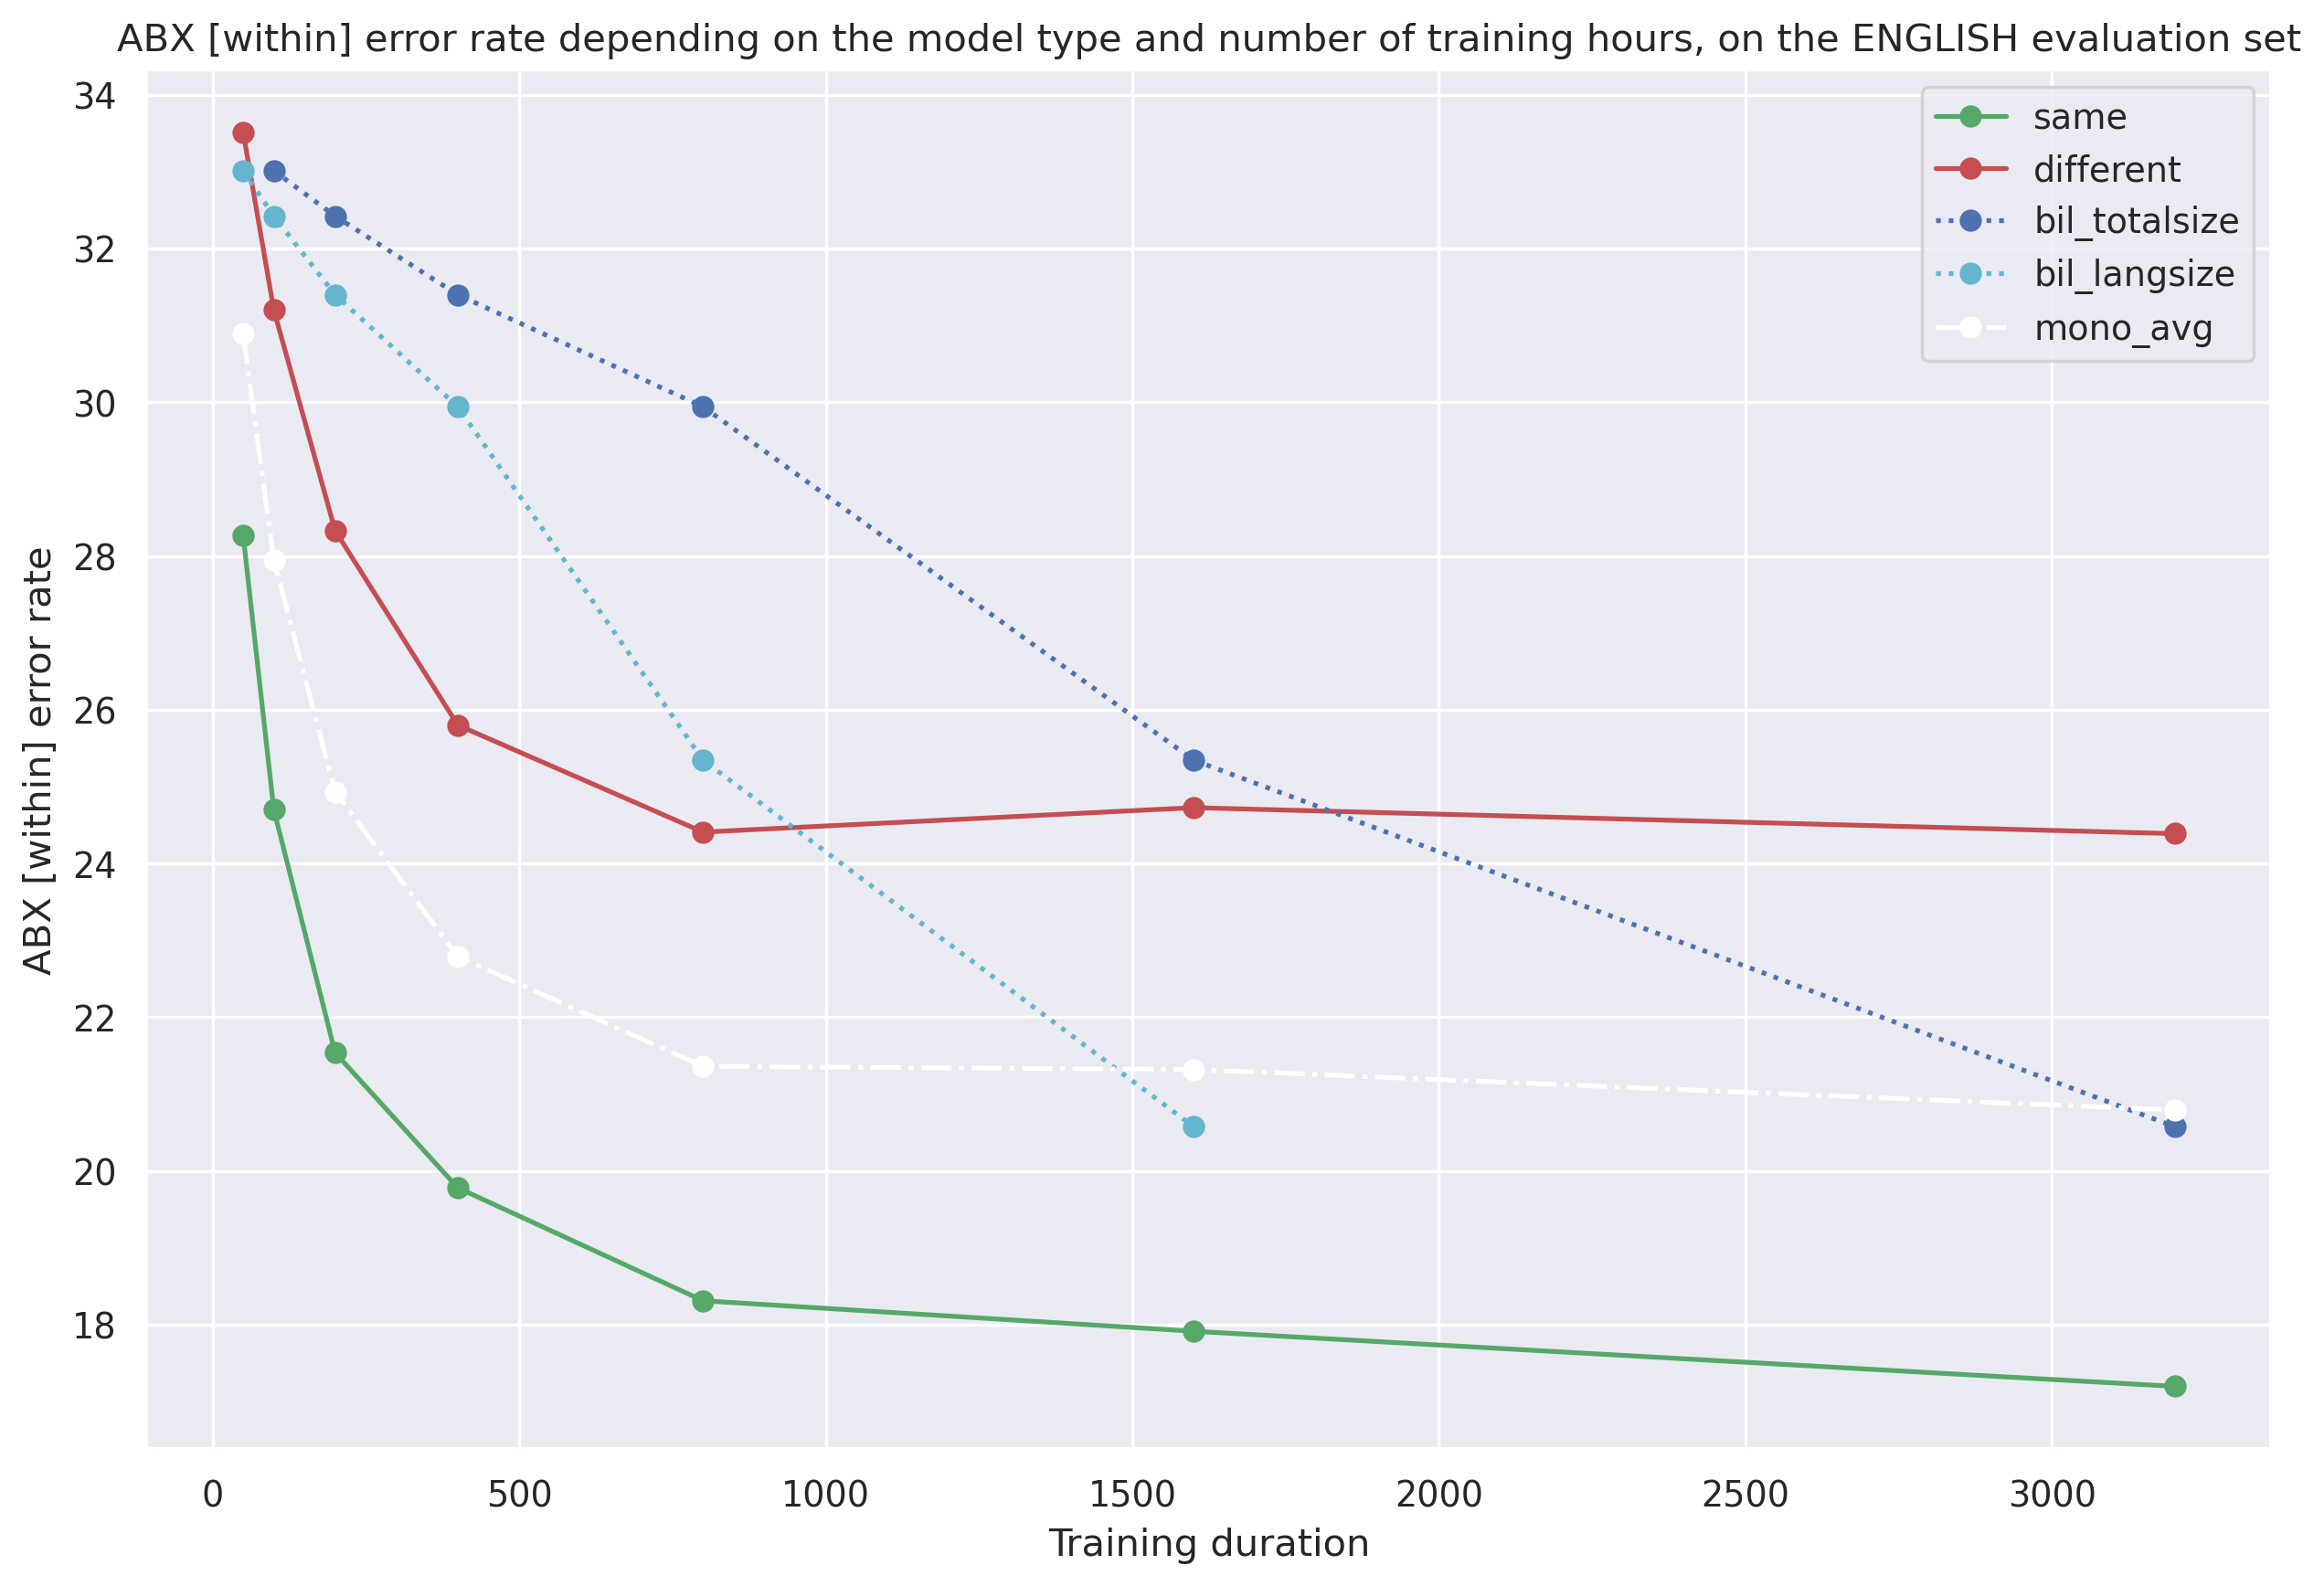

In [24]:
l="en"
df_tmp = df_within[df_within["eval_lang"]==l].groupby(by="size").mean()
df_tmp = df_tmp[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict)
plt.title("ABX [within] error rate depending on the model type and number of training hours, on the ENGLISH evaluation set")
plt.xlabel("Training duration")
plt.ylabel("ABX [within] error rate")
#plt.ylim([10,17])

### D4a. Developmental [within] ABX on the English test set - loglog scale

Text(0, 0.5, 'ABX [within] error rate (log)')

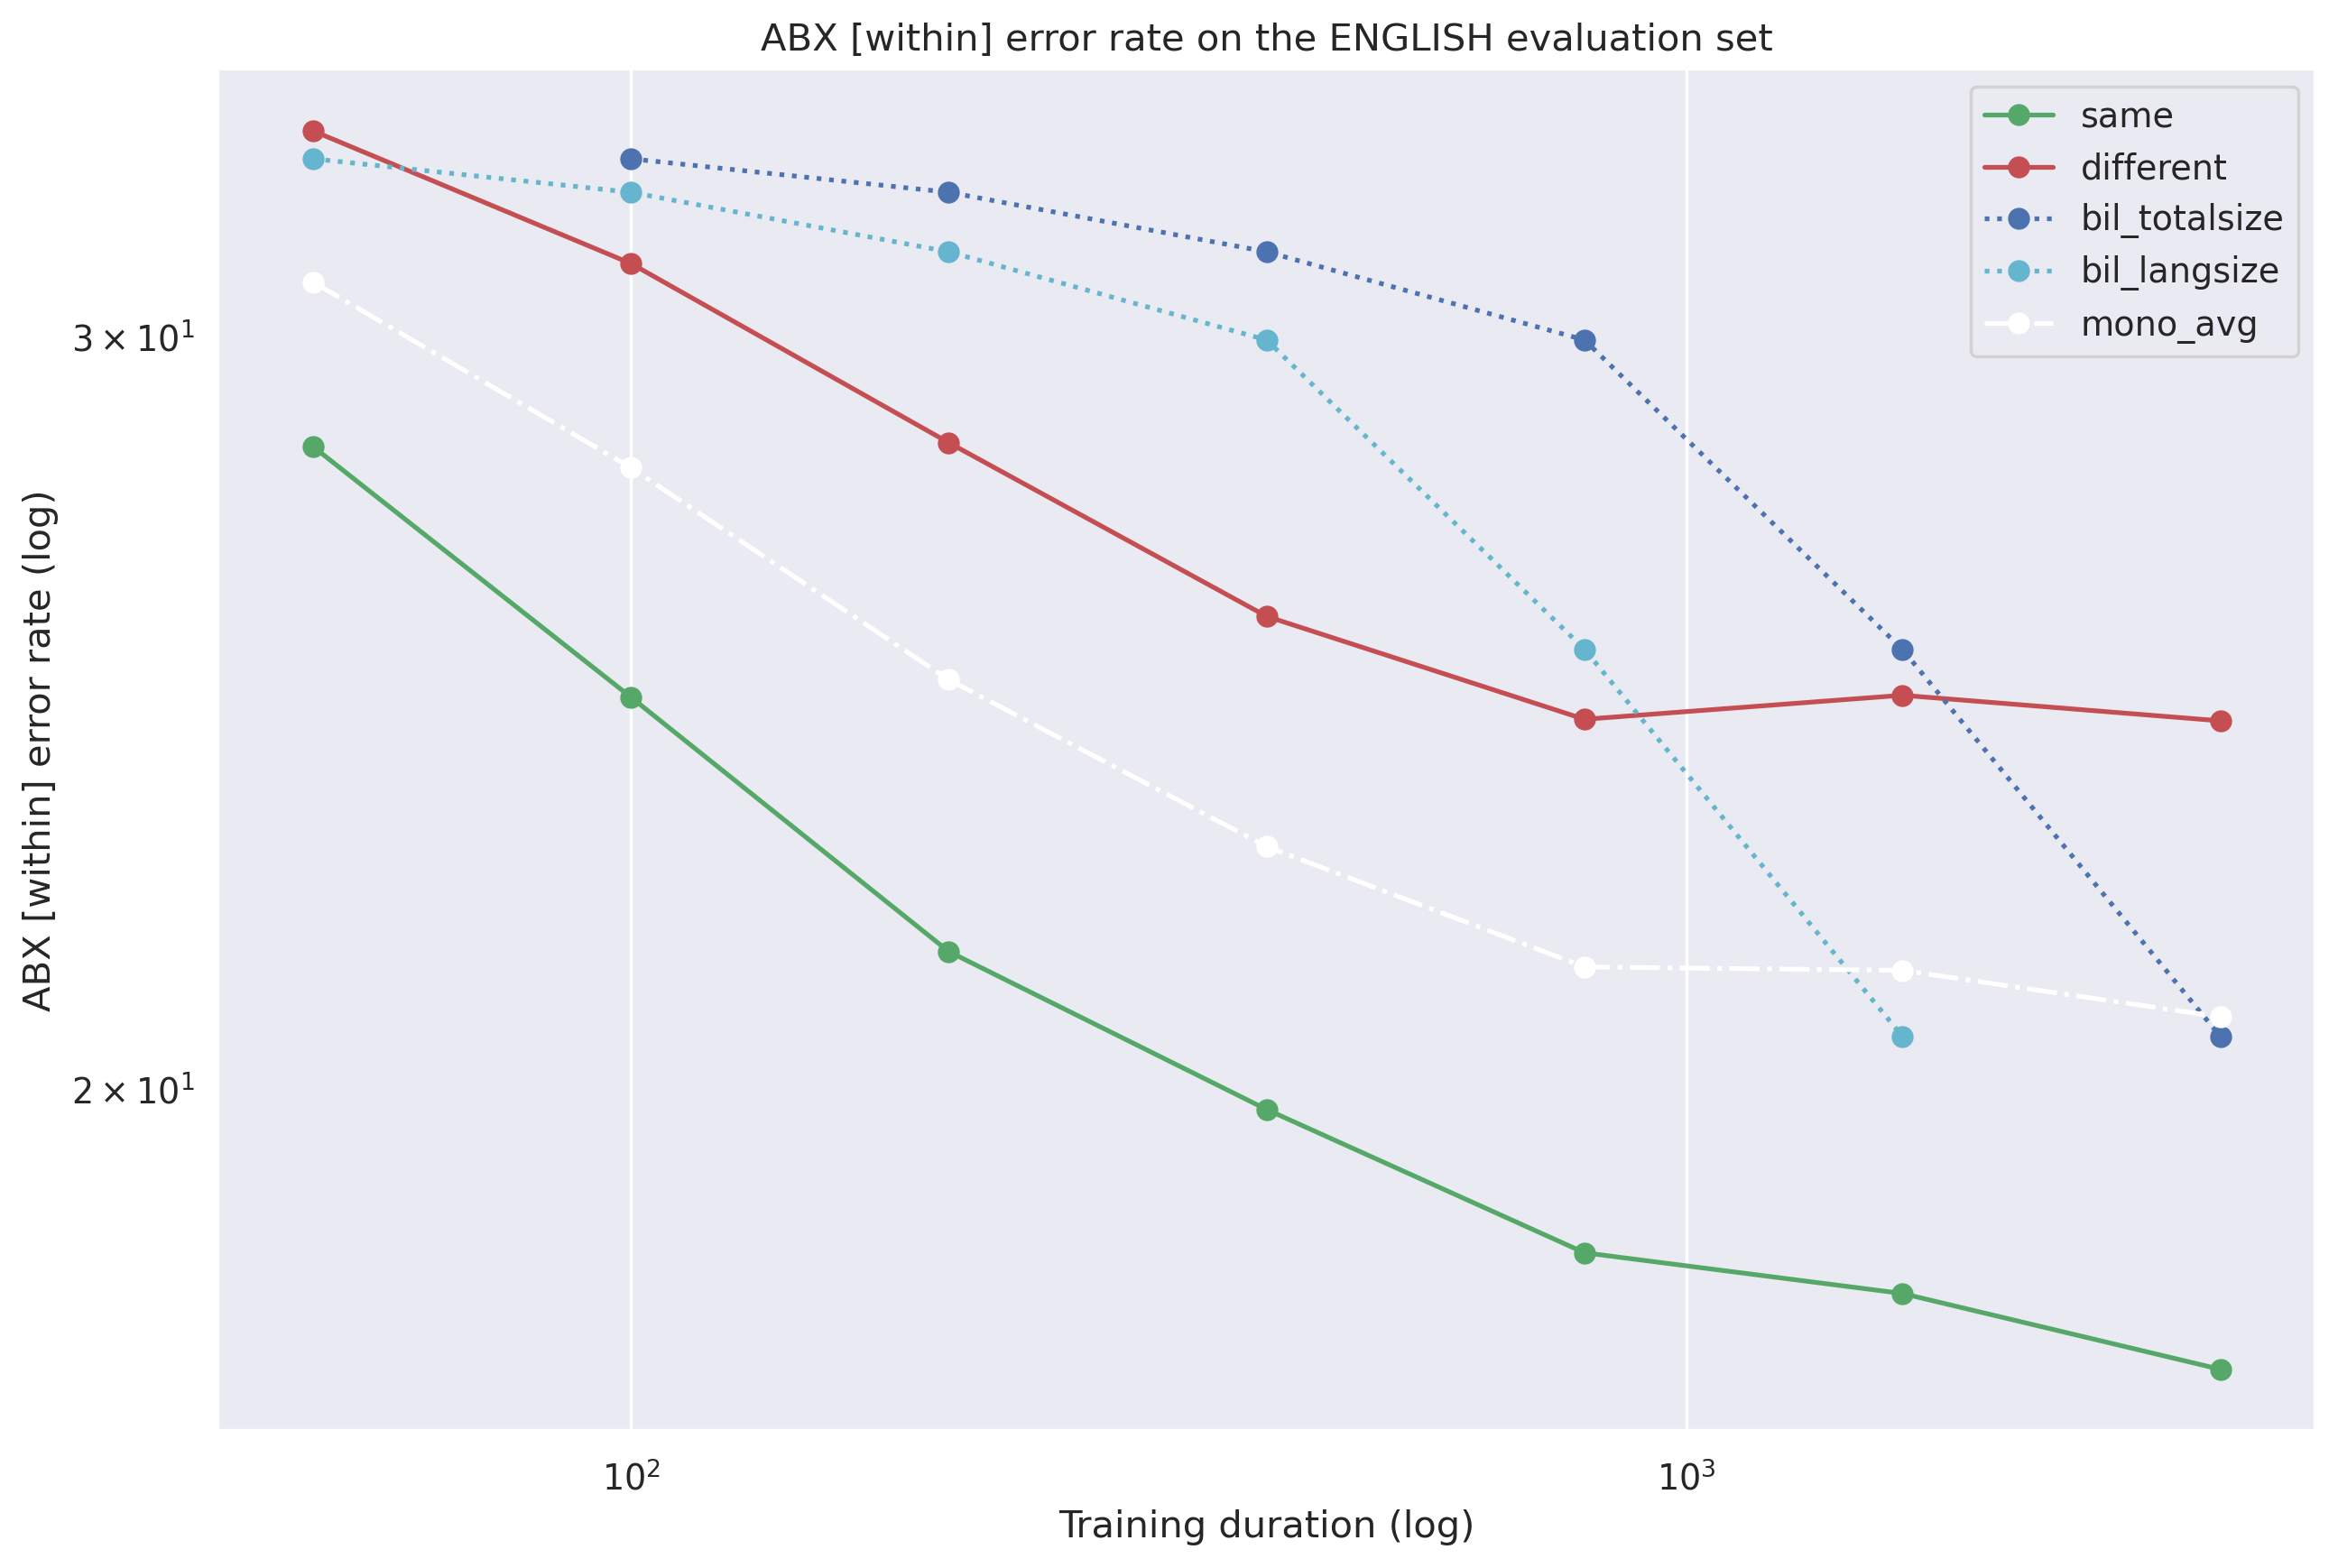

In [25]:
l="en"
df_tmp = df_within[df_within["eval_lang"]==l].groupby(by="size").mean()
df_tmp = df_tmp[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict, loglog=True)
#df_tmp = df_tmp[['same', 'different']].plot(style = style_dict, loglog=True)

plt.title("ABX [within] error rate on the ENGLISH evaluation set")
plt.xlabel("Training duration (log)")
plt.ylabel("ABX [within] error rate (log)")
#plt.ylim([10,17])

### D5. Developmental [across] ABX  on the French test set (original and QuickFix) - LogLog

(12, 21)

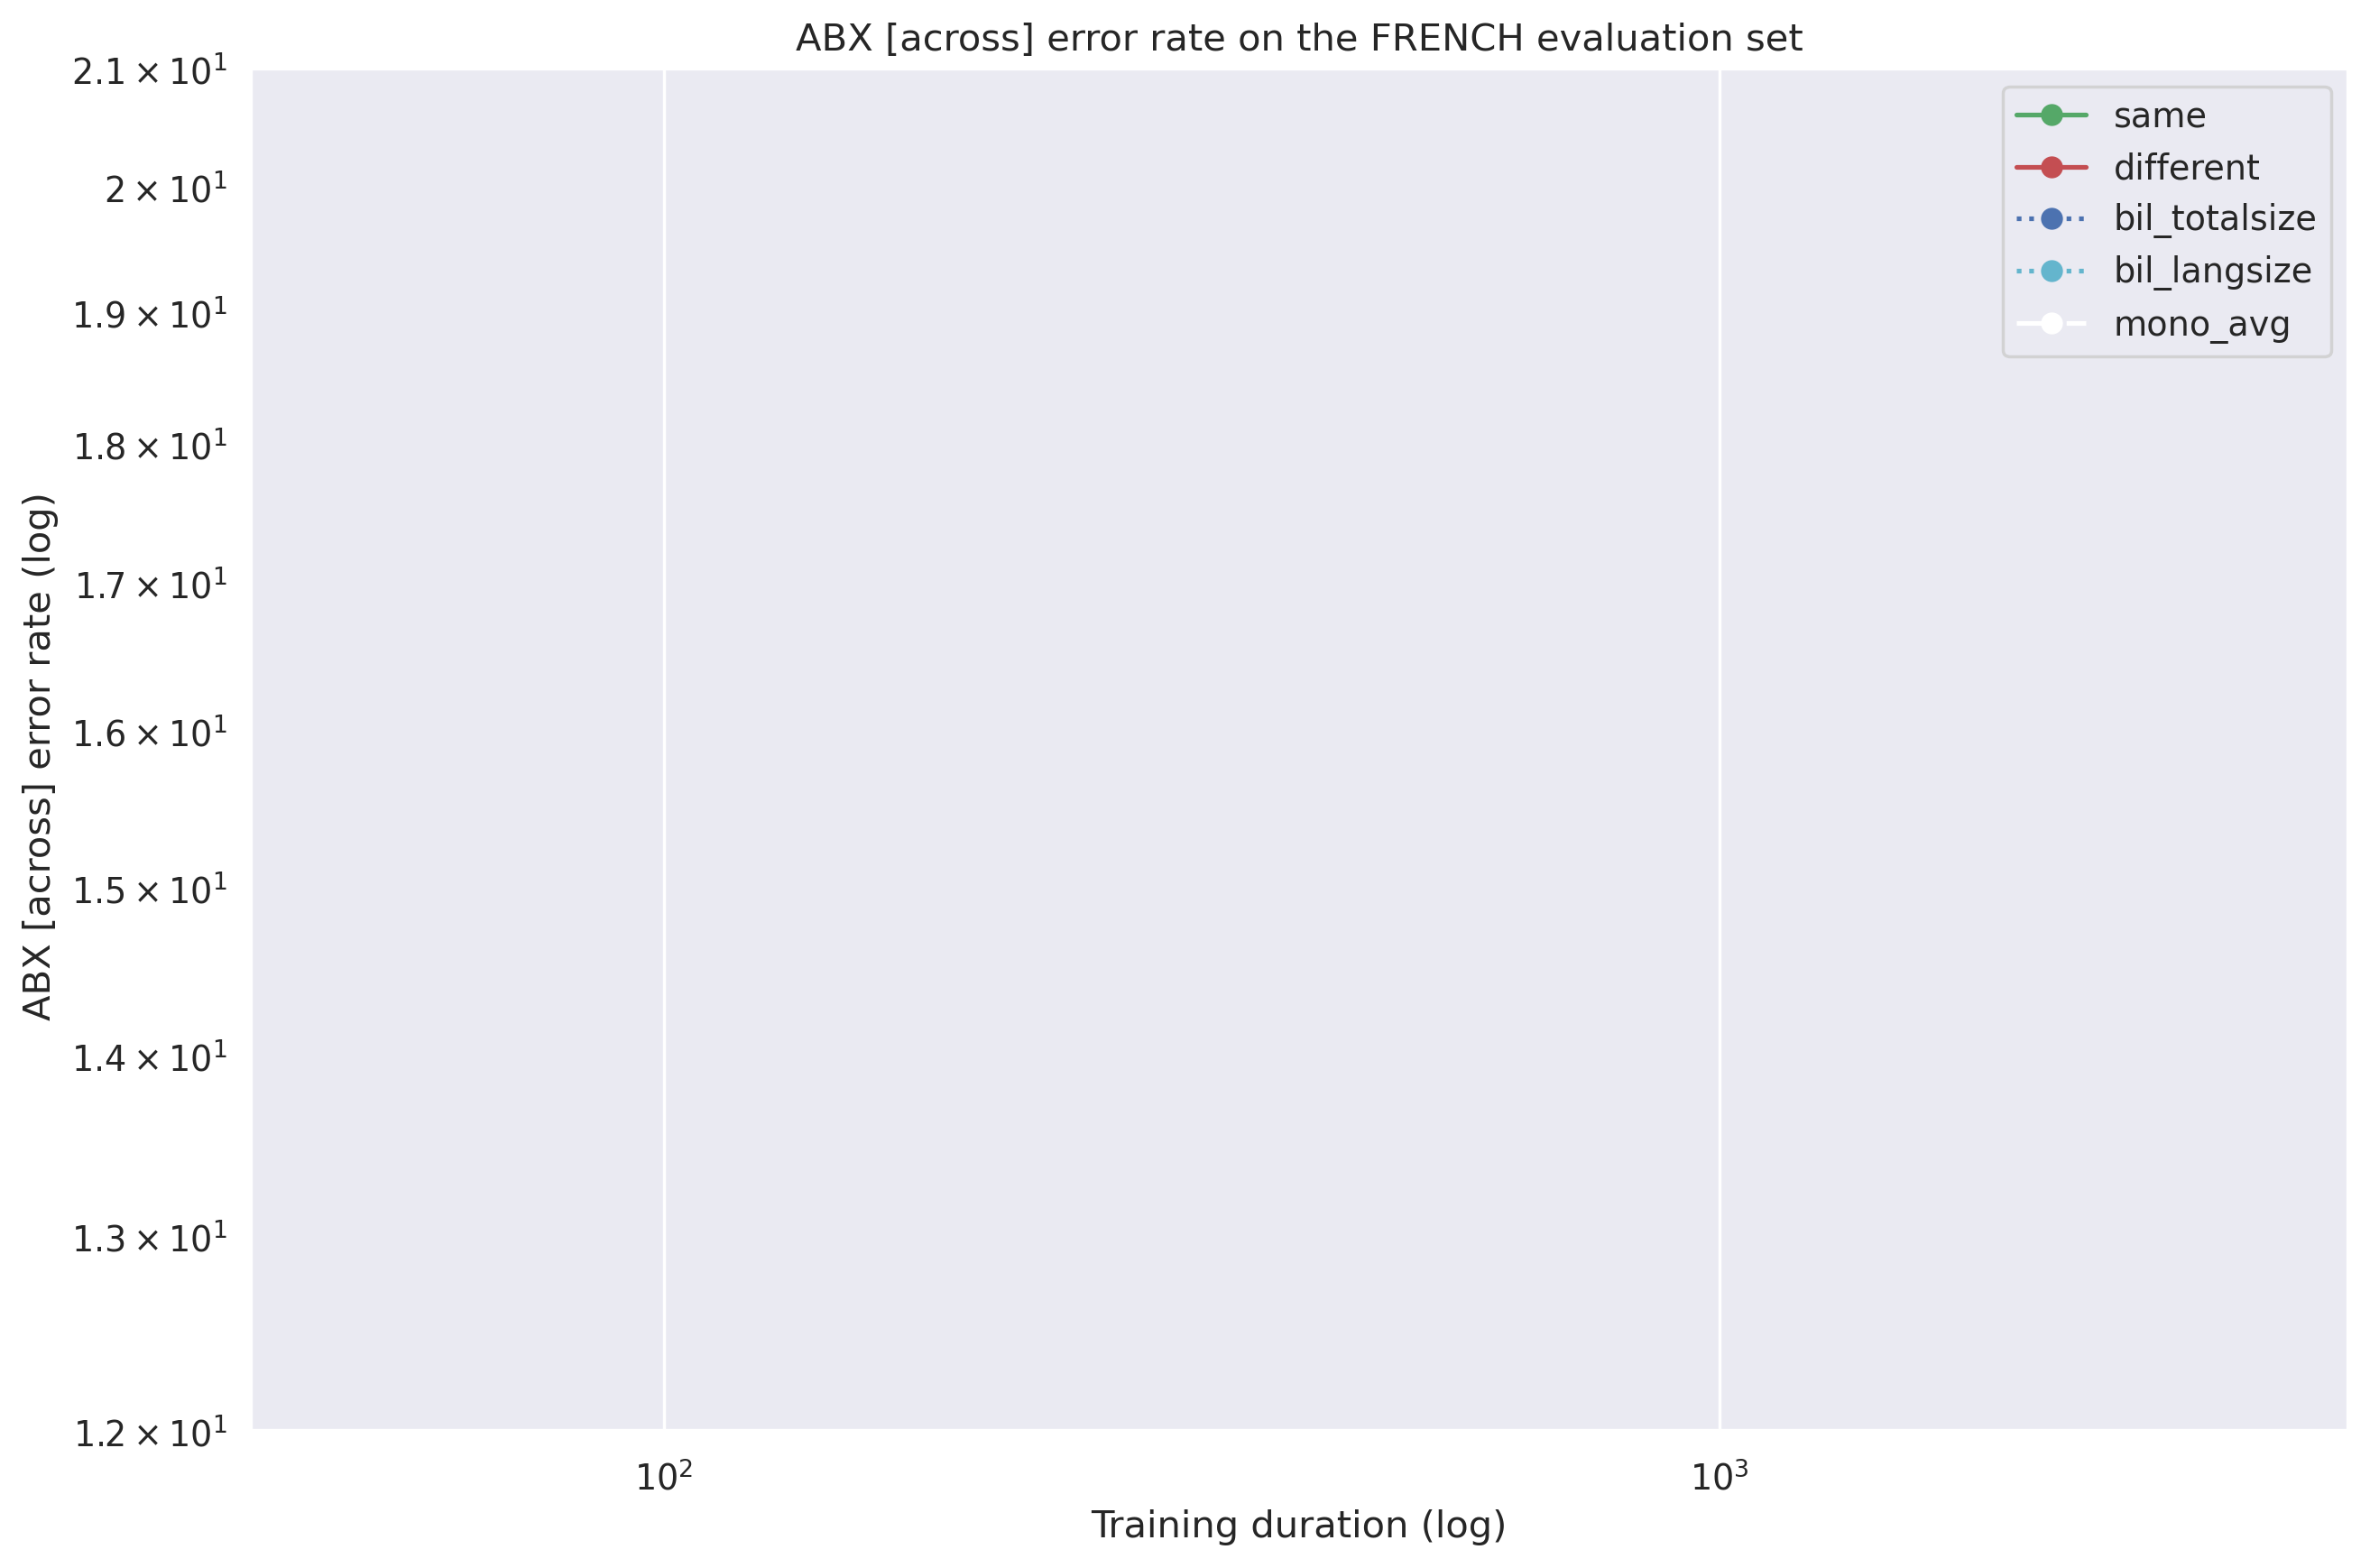

In [26]:
l="fr"
df_tmp = df_across[df_across["eval_lang"]==l].groupby(by="size").mean()
#df_tmp = df_tmp[['same', 'different']].plot(style = style_dict, loglog=True)
df_tmp = df_tmp[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict, loglog=True)
plt.title("ABX [across] error rate on the FRENCH evaluation set")
plt.xlabel("Training duration (log)")
plt.ylabel("ABX [across] error rate (log) ")
plt.ylim([12,21])


### D6. Developmental [across] ABX  on the English test set (original and QuickFix) - LogLog

(12, 21)

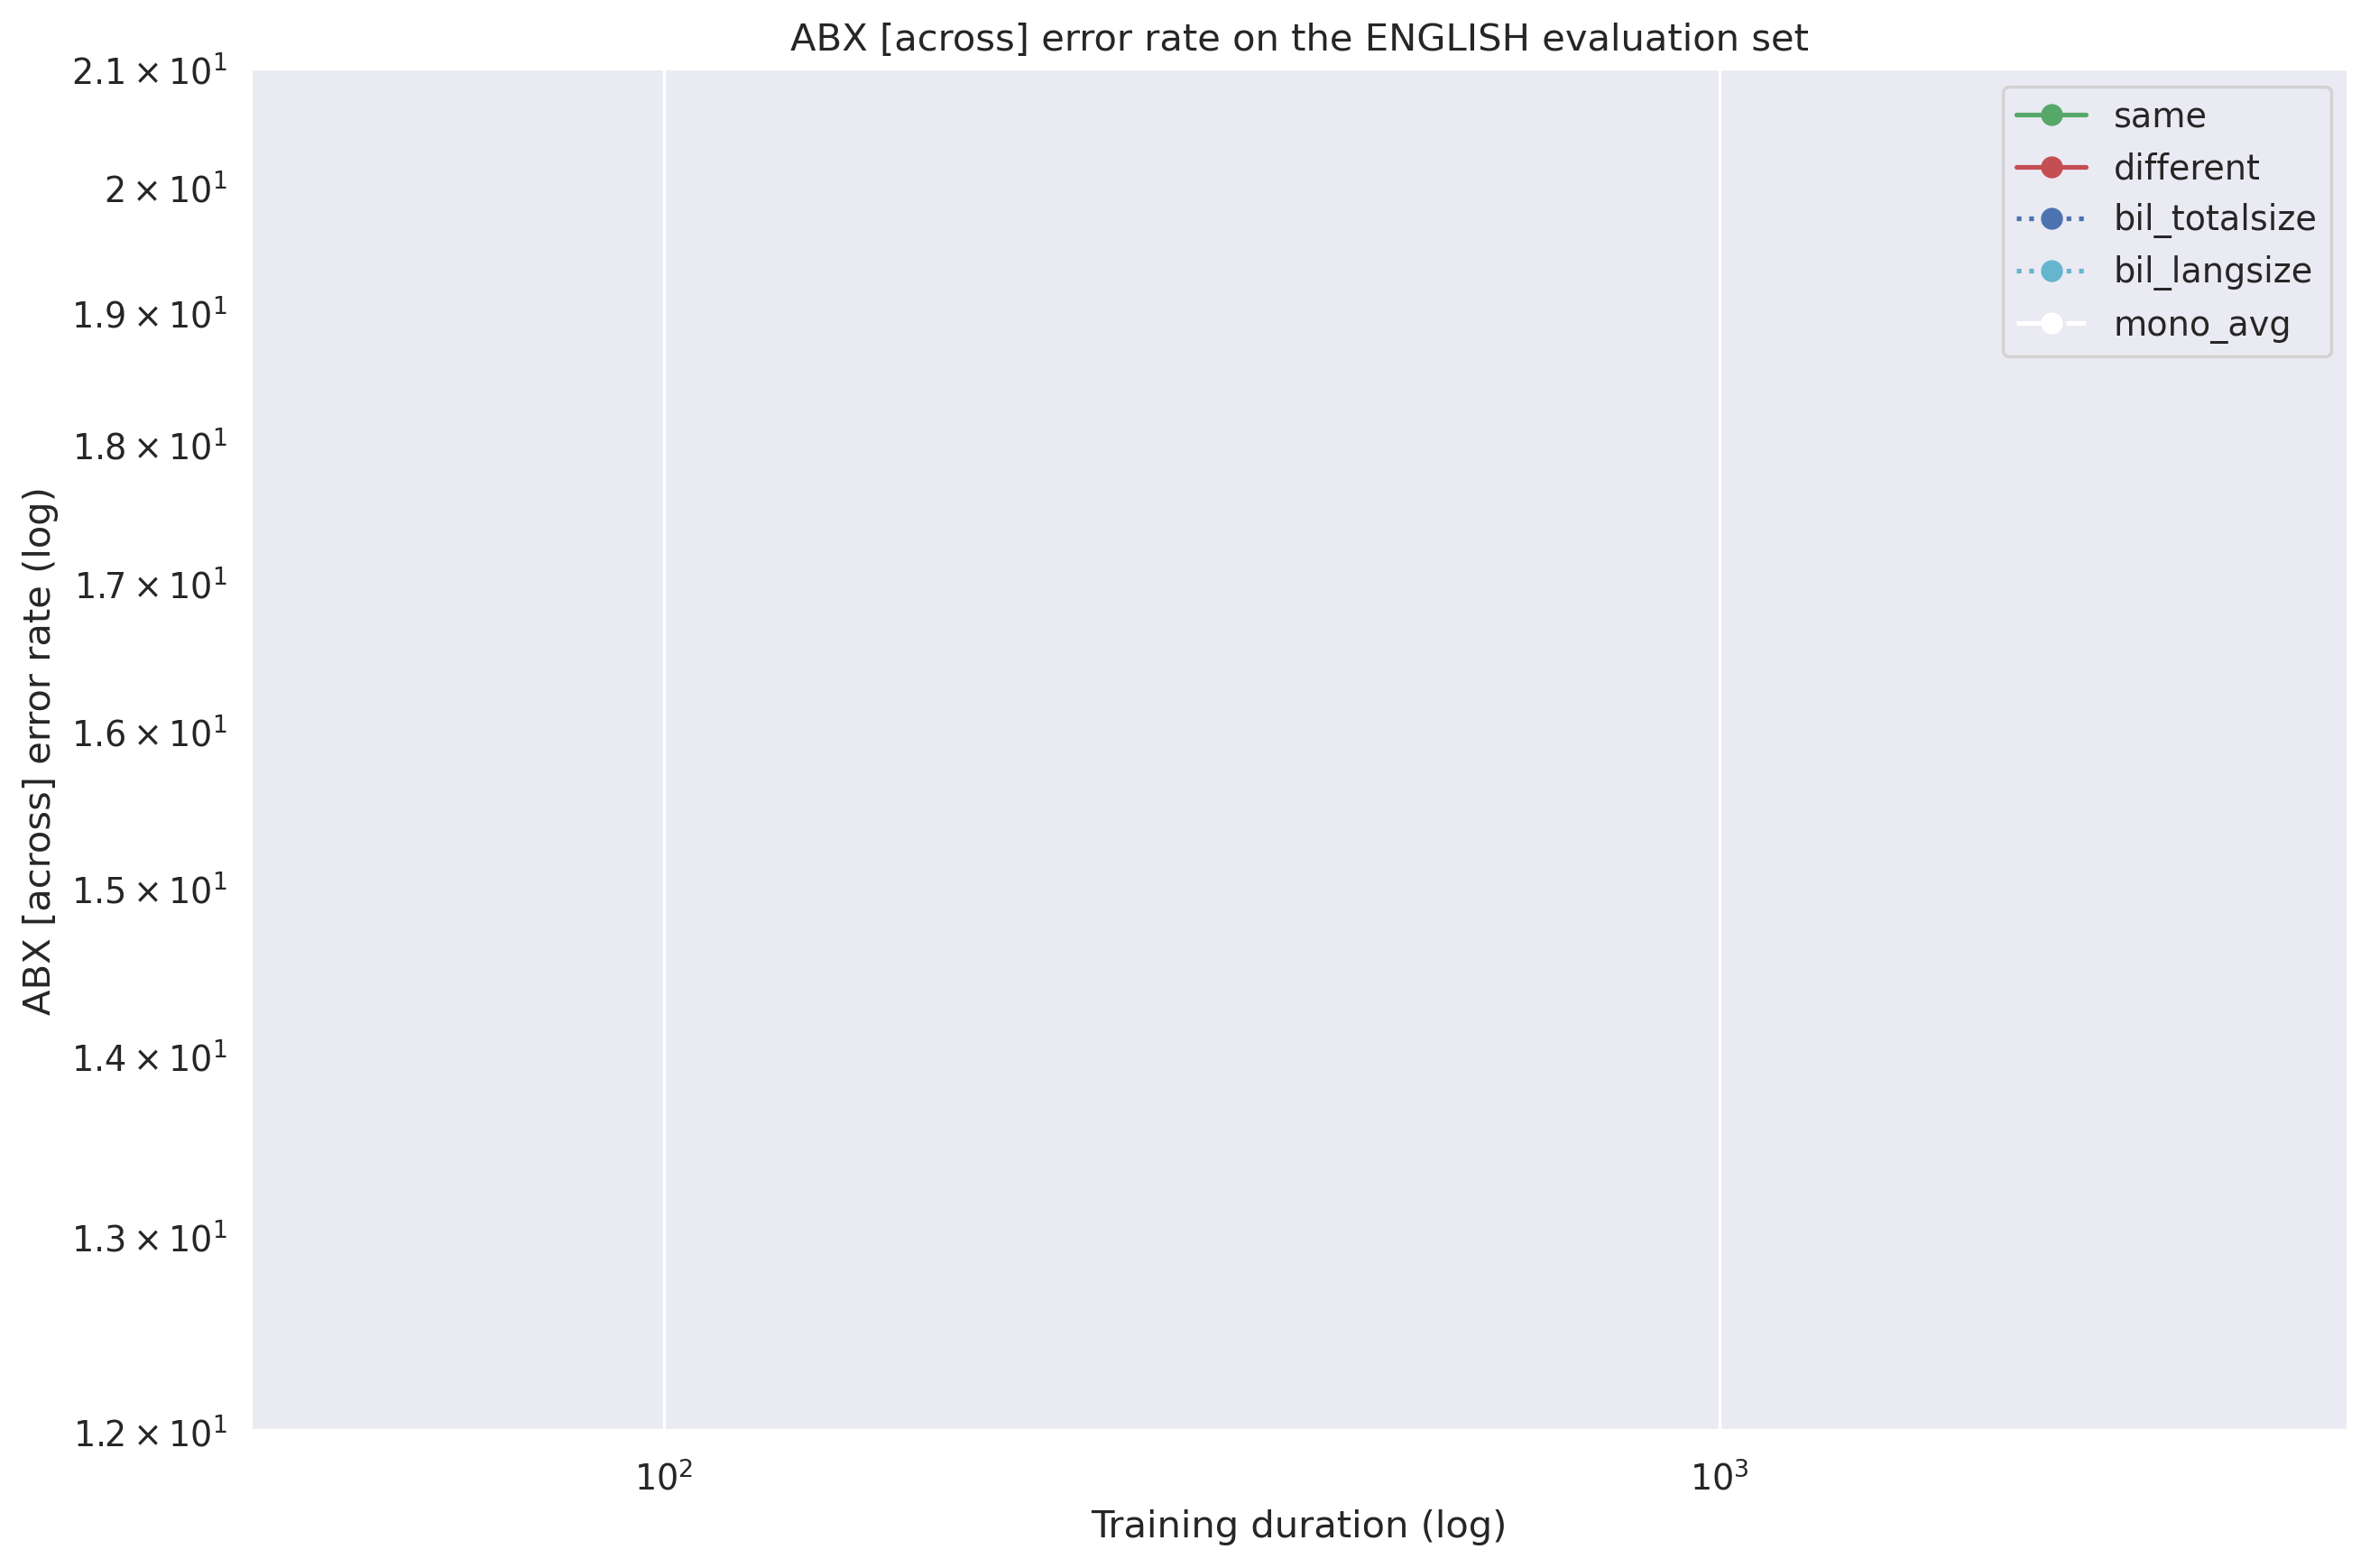

In [27]:
l="en"
df_tmp = df_across[df_across["eval_lang"]==l].groupby(by="size").mean()
#df_tmp = df_tmp[['same', 'different']].plot(style = style_dict, loglog=True)
df_tmp = df_tmp[['same', 'different', 'bil_totalsize', 'bil_langsize', 'mono_avg']].plot(style = style_dict, loglog=True)

plt.title("ABX [across] error rate on the ENGLISH evaluation set")
plt.xlabel("Training duration (log)")
plt.ylabel("ABX [across] error rate (log)")
plt.ylim([12,21])

###  Calculating Relative Advantage per data doubling :
Eg There is a **x** improvement when we double the data

In [28]:
l="fr"
df = df_within[df_within["eval_lang"]==l].groupby(by="size").mean()
df

en_model   fr_model  bil_totalsize_A  bil_totalsize_B       same  \
size                                                                      
50    29.467000  31.595405              NaN              NaN  31.595405   
100   26.294733  28.471931        32.653066        31.630127  28.471931   
200   24.154751  24.976421        31.537365        31.222115  24.976421   
400   22.958970  22.983168        30.522225        30.507993  22.983168   
800   21.588556  21.715865        27.355148        27.929650  21.715865   
1600  21.381386  21.374183        27.218097        29.310362  21.374183   
3200  20.271827  19.535062        20.300849        22.610906  19.535062   

      different  bil_langsize  bil_totalsize   mono_avg  
size                                                     
50    29.467000     32.141597            NaN  30.531202  
100   26.294733     31.379740      32.141597  27.383332  
200   24.154751     30.515109      31.379740  24.565586  
400   22.958970     27.642399      30.515109  22.971069  
800   21.588556     28.264229      27.642399  21.652210  
1600  21.381386     21.455877      28.264229  21.377785  
3200  20.271827           NaN      21.455877  19.903444

In [29]:
df = df_within.groupby(by="size").mean()
for s in ["same", "different", "bil_langsize", "bil_totalsize"] : 
    print(s, np.mean(np.diff(df[s]) / df[s][:-1] * 100))

same -7.753800540809831
different -5.514975485312273
bil_langsize -8.10640419987315
bil_totalsize -8.10640419987315


In [30]:
df = df_across.groupby(by="size").mean()
for s in ["same", "different", "bil_langsize", "bil_totalsize"] : 
    print(s, np.mean(np.diff(df[s]) / df[s][:-1] * 100))

same -6.239009984815843
different -4.532687671050005
bil_langsize -6.937006093978434
bil_totalsize -6.937006093978434


In [31]:
l="fr"
df = df_within[df_within["eval_lang"]==l].groupby(by="size").mean()
for s in ["same", "different", "bil_langsize", "bil_totalsize"] : 
    print(s, np.mean(np.diff(df[s]) / df[s][:-1] * 100))

same -7.639216672963895
different -5.995399777386009
bil_langsize -7.275685247866721
bil_totalsize -7.275685247866721


In [32]:
l="en"
df = df_within[df_within["eval_lang"]==l].groupby(by="size").mean()
for s in ["same", "different", "bil_langsize", "bil_totalsize"] : 
    print(s, np.mean(np.diff(df[s]) / df[s][:-1] * 100))

same -7.867103997991911
different -5.082856525690441
bil_langsize -8.75299756247043
bil_totalsize -8.75299756247043


In [33]:
l="fr"
df = df_across[df_across["eval_lang"]==l].groupby(by="size").mean()
for s in ["same", "different", "bil_langsize", "bil_totalsize"] : 
    print(s, np.mean(np.diff(df[s]) / df[s][:-1] * 100))

same -6.712350077303768
different -4.581441401338634
bil_langsize -6.604366594679251
bil_totalsize -6.604366594679251


In [34]:
l="en"
df = df_across[df_across["eval_lang"]==l].groupby(by="size").mean()
for s in ["same", "different", "bil_langsize", "bil_totalsize"] : 
    print(s, np.mean(np.diff(df[s]) / df[s][:-1] * 100))

same -5.692647125820773
different -4.473320833372889
bil_langsize -7.158681041556948
bil_totalsize -7.158681041556948
